**Engine Design Part 1:** *Engine Parameter Selection and Contour Sizing*: By Saaketh Ramoju

### Preface

This guide is meant to be a very high level walkthrough on choosing your overarching engine parameters, assessing your engine efficiencies, and designing an engine contour (the internal shape of the thrust chamber assembly) from these parameters. Obviously, engine design is a very deep rabbit hole that could go on and on forever, but there are some concepts that are universal to every LRE (Liquid Rocket Engine) design process. This guide does not cover any heat transfer analysis or manufacturing methods (maybe I will in another part). I also assume you know some basic thermodynamics and fluids topics, including isentropic flow and conservation equations; if you're not already familiar with that stuff, consider checking out Professor Seitzman's AE 2010 slides:

https://seitzman.gatech.edu/classes/ae2010/

I hope you find this notebook helpful!

### Table of Contents

1. Imports and Initialization
    - Package Installations
    - Imports
    - Checks and Initialization
2. What are our Primary Engine Parameters
    - Chemical Equilibrium Theory
        - Atom Balances
        - Conservation of Energy
        - Formation Reactions, $K_p$ and Gibbs Functions
3. Adiabatic Flame Temperature
    - Equivalence Ratio
    - $T_c$ vs $P_c$
    - $MR_{T_{max}}$ vs $P_c$
4. Specific Heat and Exhaust Molecular Weights
5. $C^{*}$ and $C^{*}_{eff}$
6. $C_{\tau}$, Thrust Coefficient
7. Relating $C^*$ and $C_{\tau}$ to Thrust and Mass Flow Rate
    - Ideal Case ($C^*_{eff} = 100\%$)
    - $C^*_{eff} = 85\%$
8. $I_{sp}$, Specific Impulse
9. $I_{sp}$ and $\tau$ for Varying Ambient Conditions
    - What function (NASA CEA vs RocketCEA) gives the most realistic $I_{sp}$ and how does it inform nozzle design?
    - Thrust vs. $P_e$
    - What should our $P_e$ be and which set of ambient conditions should we use for design?
        - Flow Separation
10. Optimal MR vs Chamber Pressure
    - Equilibrium or Frozen?
    - Optimum Mixture Ratio as a function of $P_c$
    - Fully Equilibrium
    - $NFZ = 1$, Frozen from Chamber
    - $NFZ = 2$, Frozen from the Throat
11. Preliminary $MR$ Selection
12. Efficiencies
    - Chamber Efficiencies
    - Nozzle Efficiencies
    - $C_d$, Discharge Coefficient
    - Finite Area Combustors
13. Contour Design Process
    - $R_t$, Throat Radius
    - Converging Section
    - Combustion Chamber
        - $L^*$, Characteristic Length
        - Constraints and Optimization
    - Diverging Section
        - $MR$ vs $\epsilon$
        - $P_c$ vs $\epsilon$
        - De Laval Nozzles and The Method of Characteristics
        - Conical Nozzles
        - Bell Nozzles
14. Summary
15. Sources


# Imports and Initialization

If you're having trouble running this code, I would suggest checking your numpy, scipy, or matplotlib installations. If you're running this in VSCode and having issues with the code, then simply try uninstalling the Jupyter extensions and reinstalling them. The other alternative is to just uninstall VScode and reinstall. You can also try *pip3 uninstall rocketcea* and then rerun the code again.

**AVOID** restarting the kernel, for some reason it screws everything up. If you accidentally do, restart the your coding environment and then run a rocketCEA function (e.g. print(*rocket.get_eps_at_PcOvPe(400, 2.2, 50, 1, 0))*) after the rocket definition. The code in the *Efficiencies* section usually works after a restart, so run a code block there and then try running all of the code blocks after.

For reference, I am running this code on my local Python 3.13.2. You can also use a virtual environment in VSCode.

In general, Google Colab is the ideal Jupyter environment, but because the server is remote, code execution takes a little longer. You also only get two processors by default. That being said, if you have any issues with VSCode, Google Colab is another great place to run the code.

### Package Installations

These packages need to be installed in order for this notebook to operate

In [82]:
# the "> /dev/null 2>&1" at the end of each line simply suppresses the 
# installation log
!pip3 install rocketcea > /dev/null 2>&1 
# in case it's not installed already (will be used to model NASA CEA)
!pip3 install rocketisp > /dev/null 2>&1 
# used to model chamber and nozzle losses
!pip3 install ambiance > /dev/null 2>&1 
# this is the standard atmosphere model that we will use 
# later in the notebook
!pip3 install cantera > /dev/null 2>&1 
# thermophysical, fluids, and kinetics toolbox
!pip3 install ipywidgets > /dev/null 2>&1 
# for the engien design widget at the end

### Imports

All of the imports you see here will be used at some point in the guide.

In [83]:
from rocketcea.cea_obj_w_units import CEA_Obj
import numpy as np
import matplotlib.pyplot as plt
from ambiance import Atmosphere
import multiprocessing
from rocketisp.rocket_isp import RocketThruster
from rocketisp.geometry import Geometry
from rocketisp.stream_tubes import CoreStream
from rocketisp.efficiencies import Efficiencies
from rocketisp.nozzle.nozzle import Nozzle
from rocketisp.geometry import solidCylVol, solidFrustrumVol
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.interpolate import griddata
import ipywidgets as widgets
from IPython.display import display
import cantera as ct
from PIL import Image
import csv

### Checks and Initialization

Let's check to see how many processors you have so that you can keep your computer form using all of them when running the code but also use enough to make the code faster.

In [84]:
print(f"You have {multiprocessing.cpu_count()} processors")

You have 8 processors


It would be a good idea to familiarize yourself with the RocketCEA documentation:

https://rocketcea.readthedocs.io/en/latest/functions.html

And also the RocketIsp documentation:

https://rocketisp.readthedocs.io/en/latest/functions.html

The following code represents the rocket object I will use for essentially every code block in the notebook. It is essential that you run this code before moving on.

In [85]:
rocket = CEA_Obj(oxName='LOX', fuelName='RP-1', temperature_units='degK', 
                 cstar_units='m/sec', specific_heat_units='kJ/kg degK', 
                 sonic_velocity_units='m/s', enthalpy_units='J/kg', 
                 density_units='kg/m^3')
# This rocket object will be used going forward
# This initialization assumes an inifite area combustor. 
# This is will later be changed

# What are our Primary Engine Parameters?

In order to start designing an engine, a few important parameters have to have to be established. Some of these have to decided early on since they inform the construction of the whole vehicle, and others can be tweaked as the analysis goes along. Here the ones you should care about when it comes to preliminary sizing:

- **$\tau$, Thrust**: This is not necessarily the thrust that the engine will produce during the entire flight but rather the thrust produced at maximum efficiency, which is when the flow out through the nozzle is perfectly expanded. More on this in the *Isp for Varying Ambient Conditions* section

- **$P_c$, Chamber Pressure**: Although it might seem like this should be a function of mass flow or something else, chamber pressure is something you get to choose. Very roughly speaking, for a given nozzle, a desired thrust is easier to reach with a higher chamber pressure. The opposite is also true: for a lower pressure, you need a bigger,better nozzle to get a higher thrust ($\tau = C_{\tau} * A_t * P_c$). There are a lot of considerations that go into choosing this value with the primary one being your feed system architecture. If you have a pressure-fed system, you're going to need much higher COPV pressures to sustain a higher Pc. With electric pumps, gas generators, etc. it's a lot easier to get higher pressures. This one should be chosen pretty early on as it will determine the necessary feed system, your injector stiffness, and tank sizes.

- **$P_e$, Exit Pressure**: This is pressure that the gases exit the nozzle with, NOT the outside ambient pressure. This one is usually chosen based on thrust level curve simulations of your flight, but it can also inform some of the other parameters in this list as well. Exit pressure determines how over or underexpanded your nozzle is, which affect your sea-level thrust and also the weight of your engine. More on this in the *Isp for Varying Ambient Conditions* and *Optimal MR vs Chamber/Exit Pressure* sections.

- **$MR$, Mixture Ratio**: As we normally define it, it's the ratio of mass flow rates of the oxidizer to fuel. This one needs to be chosen really early on since it greatly determines your tank sizes and pump flow rates. Moreover, $MR$ plays a huge role in determining how hot your engine will get, which will inform your engine material selection and sealing. This one requires a good amount of work to determine, and most of this notebook will be dedicated to optimizing $MR$ from an efficiency standpoint, not a materials and cooling standpoint.

There are certainly many other efficiency-related and geometric nozzle parameters you can tweak, but these are the primary ones to start with.

The next few sections will deal with choosing $MR$

# Chemical Equilibrium

 Calculating combustion chamber temperatures from $P_c$ and $MR$ is not something that can be done easily by hand. In fact, it takes solving a system of nonlinear equations and several atom balances to find the *equilibrium* temperature. A computer, however, is quite good at doing this, and I would encourage anyone who is interested to try and write their own code to solve for final temperature and product composition given $P_c$ and $MR$. If you're interested in implementing your own chemical equilibrium code, check out Professor Seitzman's guide:

https://seitzman.gatech.edu/classes/ae6765/GenlSolutionChemicalEquilibrium.pdf

For the majority of this notebook, I will use *NASA CEA* or *Chemical Equilibrium with Applications*, a NASA legacy software that iterates through a bunch of temperatures to find the correct final temperature and composition. *RocketCEA* is a python library that allows us to use the results of CEA directly in our code, and it's the library I will be using to demonstrate the parameter selection. The following code uses RocketCEA's in-built CEA functions to establish a relation between chamber pressures and temperatures.

cea.jpeg

If you want to know more about combustion theory and kinetics, I recommend the following sources:
- Professor Seitzman's 6765, Kinetics and Thermodynamics of Gases, Lecture Notes: https://seitzman.gatech.edu/classes/ae6765/
- Professor Seitzman's 6766, Combustion, Lecture Notes: https://seitzman.gatech.edu/classes/ae6766/
- *Introduction to Physical Gas Dynamics*: Walter G. Vencenti & Charles H. Krueger, Jr

### Chemical Equilibrium Theory

Much like a lot of the thermodynamics we do, implementing chemical equilbrium really just comes down to mass and energy conservation. I think this is best demostrated through an example. Let's take, for example, the fuel used in the Raptor Engine: methane, $CH_4$. We shall react this substance with LOX, $O_2$. Let us first write out the stoichiometric reaction, which is defined to be a complete combustion at standard pressure and temperature:

$CH_4 + 2O_2 \leftrightharpoons CO_2 + 2H_2O$

Because $CO_2$ and $H_2O$ require the lowest *enthalpies of formation* at conditions that we are used to, they are what tend to form during complete combustion. However, as soon as there are excess molecules of the reactants or the temperature and pressure change, we will start to get many *minor* species.

$CH_4 + 2O_2 \leftrightharpoons CO_2 + H_2O + $ (many minor species)

Notice that we could not balance this reaction. That is because we do not know what the starting conditions are nor do we know what the final composition is. This is the essence of chemical equilibrium calculations: we try different ending compositions until one works. 

Let's define our problem a little better. Let's say that we are reacting methane and LOX isobarically at 5100 psia, where the inlet temperatures of the $CH_4$ and LOX are 110 K and 90 K, respectively (obviously these are not what the Raptor chamber conditions are, but with staged combustion engines, finding the exact pressures is difficult. However, if the system is assumed to be adiabatic from the tank to the combustion chamber, using the cryo starting conditions is fine since the total energy is conserved). We can safely assume that all of the fuel vaporizes and gets used up. So that leaves us with the following *conversion reaction*, the one-way reaction formula that depicts all of the starting and ending species:

$\phi CH_4 + 2O_2 \rightarrow CO_2 + H_2O + CO + OH + H_2 + O_2 + $ (many minor species)

$\phi$ here represents the *equivalence ratio*, the ratio that compares the amount of fuel we actually have over the amount of fuel needed to have a stoichiometric reaction, so $\phi$ would be $1$ for stoich. Also notice that we have $O_2$ is on both sides of the reaction; this is helpful in case we have excess oxidizer left over, so that way, it will also show up in the final composition after our analysis. We assumed that essentially all of the fuel will be used, which is why $CH_4$ doesn't show up with the other products. 


#### Atom Balances

We know the pressure and temperature of the reactants as well as what species are reacting. We also know the final pressure and what elements are present in the reaction: $C$, $H$, and $O$. Is this enough information to solve the problem? Let's first simplify our reaction a little (for the sake of explanation), and we will see. 

$\phi CH_4 + 2O_2 \rightarrow n_{CO_2}CO_2 + n_{H_2O}H_2O + n_{CO}CO$

Obviously, those aren't the only species that show up, but this will get the idea across. Now we must conserve the number of atoms on either side of the reaction using *atom balances*.

Carbon: $n^C = \phi = n_{CO_2} + n_{CO}$

Hydrogen: $n^H = 4\phi = 2n_{H_2O}$

Oxygen: $n^O = 4 = 2n_{CO_2} + n_{H_2O} + n_{CO}$

If our goal is to solve for the composition wih $n_{CO_2}$, $n_{H_2O}$, and $n_{CO}$, these three linear equations need to be solvable. That means we have to know what $\phi$ is in order to find a final composition. We will have to define what $\phi$ is moving forward. Let's say our rocket has a mixture ratio of 3.6 (same as Raptor). What is the equivalence ratio?

In [86]:
gas = ct.Solution('gri30.yaml')
fuel = 'CH4:1'
oxidizer = 'O2:1'
MR = 3.6
# cantera defines MR as fuel/ox
gas.set_mixture_fraction(1/(1+MR), fuel, oxidizer)
phi = gas.equivalence_ratio(fuel, oxidizer, basis='mole')
print(f"Equivalence Ratio = {phi:.2f}")

Equivalence Ratio = 1.11


Since $\phi = 1.11$, the reactant is considered to be *fuel-rich* since there is relatively more fuel than in the stoichiometric reaction. It looks like we now have enough information create a well-defined problem with solveable atom balances.

$n^C = 1.11 = n_{CO_2} + n_{CO}$

$n^H = 4.44 = 2n_{H_2O}$

$n^O = 4 = 2n_{CO_2} + n_{CO} + n_{H_2O}$

While we could proceed from here, we usually generalize the solution by solving for *mole fractions* instead of moles directly.

$\frac{n^C}{n^H} = 0.25 = \frac{n_{CO_2} + n_{CO}}{2n_{H_2O}} = \frac{\chi_{CO_2} + \chi_{CO}}{2\chi_{H_2O}}$

$\frac{n^H}{n^O} = 1.11 = \frac{2n_{H_2O}}{2n_{CO_2} + n_{CO} + n_{H_2O}} = \frac{2\chi_{H_2O}}{2\chi_{CO_2} + \chi_{CO} + \chi_{H_2O}}$

Our third, "missing" equation will come from the fact that

$\chi_{CO_2} + \chi_{CO} + \chi_{H_2O} = 1$

All three of these equations can still be solved as linear equations, which is convenient. We have three equations and three unknowns, so let's solve this system.

In [87]:
#        0      1      2
# X = [X_CO2, X_CO, X_H2O]
def linear_equations(X):
    eq1 = np.sum(X) - 1
    eq2 = X[0] + X[1] - 0.5*X[2]
    eq3 = 2.22*X[0] + 1.11*X[1] + 1.11*X[2] - 2*X[2]
    return [eq1, eq2, eq3]

X0 = [1, 1, 1]
X = fsolve(linear_equations, X0)
print(f"CO2: {X[0]*100:.2f}%, CO: {X[1]*100:.2f}%, H2O: {X[2]*100:.2f}%")


CO2: 20.12%, CO: 13.21%, H2O: 66.67%


Already, without solving any nonlinear equations or iterations, we have a pretty good guess of what our final composition is. Notice that we were able to solve these equations fully linearly because we had exactly as many equations as we did the number of atoms participating in the reaction. In solving this, we used what is called the *Major-Minor Model*: we found the major constituents of the equilibrium mixture using simple, linear, atom balances. These major species are what will decompose to create the minor species. We can now use this as a starting guess to find the minor species. 

#### Conservation of Energy

In the problem we defined, we have a prescribed a pressure at the final state, but nothing else. Our goal is to find the ending composition, but in order to do that, we need the final temperature (if you recall the state postulate, you need two independent, intensive thermodynamic properties to determine the state. Composition is a state property). But to find the final temperature, we need the equilibrium composition; this has now become a recursive problem. The solution method will therefore be to first guess an equilibrium composition and use that find a temperature. This temperature will be used to find a better composition.

Once you get a composition and use that to find your temperature, how do you know if that's the right temperature? The is where conservation of energy plays a critical role: unless we add or remove heat, the energy we started with at the inlet of the flow must be the same as the outlet of the flow. This is why the equilibrium temperature is called the *adiabatic flame temperature*: it's the temperature that the products would achieve if there's no heat addition or loss. 

Assuming that the flow is steady and that the bulk kinetic energy difference is small (good assumption for a small axial element), we have:

$\dot{m}_1 = \dot{m}_2$

$\dot{m}_1 h(T_1) + \dot{Q} = \dot{m}_2 h(T_2)$

steady 2.png

Now, if we assume adiabatic, we know that $h(T_1) = h(T_2)$, so any temperature $T_2$ that we get as a result must allow the final enthalpy to be the same as the initial enthalpy (if you're wondering why we use enthalpy and not internal energy, I recommend reading the following pdfs: https://seitzman.gatech.edu/classes/ae6765/AuxFunctions.pdf and https://www.aapt.org/docdirectory/meetingpresentations/sm14/mungan-poster.pdf). Through measurement, we are only capable of ever finding a change enthalpy. So then how do we define an absolute enthalpy at $T_1$ and $T_2$? We do so by referring to the *enthalpies of formation*, which are standard enthalpies representing the amount of chemical energy needed to break or form the set of bonds needed to form a molecule. These values of $\Delta \bar{h}_f$ are tabulated in the JANNAF or NIST tables. Certain molecules, called *elements* (not to be confused by periodic table elements) are defined to have $\Delta \bar{h}_f = 0$ at all temperatures. For the JANNAF standard, the elements conveniently happen to be very common molecules like $O_2$, $H_2$, and $C(s)$ (graphite). 

Now, we can write the energy conservation in terms of the formation enthalpies:

$\frac{\sum{\chi_{i1}\bar{h}_{i1}(T_1)}}{MW_1} = \frac{\sum{\chi_{i2}\bar{h}_{i2}(T_2)}}{MW_2}$

Here, $\bar{h}_i$ values represent the partial molar enthalpies for each species on the reactant and product side. $MW$ is the molecular weight of either the reactant or product mixture. $\bar{h}$ can be represented as:

$\bar{h}_i(T) = (\bar{h}(T) - \bar{h}(T_{ref})) + \Delta \bar{h}_f(T_{ref})$

The first term in this expression is tabulated as a single value known as the *sensible enthalpy*. This is the enthalpy that's actually calculated with $c_p$ and what's easiest to measure. For ideal gases (ideal gas is a good assumption for our case because of the extremely high temperatures and the relatively low molecular weights of the reaction products), these values of enthalpy should not change with pressure. Of course, that's not entirely accurate, but not a terrible assumption. But in our case, the reactants, $CH_4$ and LOX, actually start off as liquids! Therefore, the starting enthalpies will vary with pressure more than after the combustion.

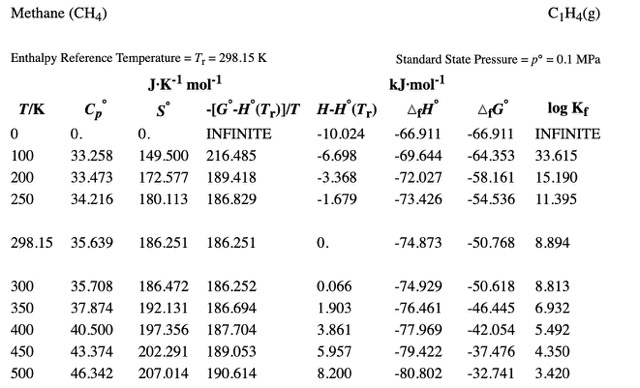

#### Formation Reactions, $K_p$, and Gibbs Functions

So now that we have a way to figure out what temperatures are within our practical range, but how do we refine our chemical composition with minor species? For one, we can continue writing more minor species. 

$1.11CH_4 + 2O_2 \rightarrow n_{CO_2}CO_2 + n_{H_2O}H_2O + n_{CO}CO + n_{H_2}H_2 + n_{OH}OH + n_{O_2}O_2$

We only added two more species, but the atom balances are already insufficient to describe the entire system. In fact, we would only get three linear atom balance equations, and we need five equations total.

One thing that would simplify our life a litte is if there was table somewhere that told us the exact composition of the reaction we wrote at every temperature imaginable. Obviously that table doesn't exist: the reaction itself is way too specific. But what if there was a reaction that did have tabulated values? Before, we discussed how the major species themselves decompose to create the minor species. This true the other way around too: the minor species combine to form major species. So, we can write a separate equilibrium reaction to characterize this process. For example:

$H_2 + \frac{1}{2}O_2 \leftrightharpoons H_2O$

This type of reaction is called a *formation reaction*. It represents the process needed to form a single mole of a certain substance from the JANNAF elements. This one is particularly useful because all of the species in the formation reaction are present in the product mixture. But what does this have to do with temperature? It turns out the that ratio of the partial pressures of the species in the formation reaction are only dependent on temperature (for ideal gases). So, that means if we know the temperature, we can figure out the relative amount of each species in the formation. 

$\frac{p_{H2O}}{p_{H_2}p{O_2}^{\frac{1}{2}}} = p^{-\frac{1}{2}}\frac{\chi_{H2O}}{\chi_{H_2}\chi_{O_2}^{\frac{1}{2}}} = constant$

The constant here is only a function of temperature, even though pressure is in the equation. This means that the values of this constant can be tabulated with $T$. This constant is called the *equilibrium constant*, $K_p$. So, if we know $K_p$ for a given temperature, we can use the $K_p$ formula for this formation reaction as a fourth equation. For the fifith equation, we can use the water-gas shift reaction:

$H_2O + CO \leftrightharpoons H_2 + CO_2$

$K_p(T) = \frac{p_{H_2}p_{CO_2}}{p_{H_2O}p_{CO}} = \frac{\chi_{H_2}\chi_{CO_2}}{\chi_{H_2O}\chi_{CO}}$

Keep in mind that $K_p$ equations are really only usefull when all of the species in the "helper" reaction are involed in the overall reaction. So now, we have five equations, which is all that we needed. We should be done right?

Not exactly.

Pretty much no equilibrium solver uses $K_p$ equations, and there's a good reason why. In fact, $K_p$ equations are pretty much only good if we're trying to solve the nonlinear equations by hand. But to understand why they may not be so good for computer use, we will have to explore how $K_p$ is derived for a given temperature. 

By definition, $K_p = e^{-\frac{\Delta G°}{\bar{R}T}}$. $\Delta G°$ is known as the Gibbs function for a given reaction: it's a value that's minimized when a system has reached equilibrium at constant temperature and pressure. Keep in mind, $T$ and $p$ do not necessarily need to be constant during process. It's kind of like saying, "For a given $T$ and $p$, what's the minimum Gibbs free energy?" Like enthalpy or energy, $G°$ is determined as a function of temperature and pressure, so it can also be tabulated. Now imagine a final temperature and pressure at which the $\Delta G°$ for a reaction is a very large number. Now, when you calculate $e^{-\frac{\Delta G°}{\bar{R}T}}$, $K_p$ will be very close to zero, and to the computer, $K_p$ is effectively indistinguishable from 0, so the solution would diverge. 

To get around this, computational methods choose to avoid using $K_p$ and instead just minimize $G(T, p)$ directly. This has to be done through iteration, but it usually only takes 2-3 iterations to solve accurately. This way, we can just jump straight to using a lot of minor species instead of just starting with the major species and working our way down. The equations used in Gibbs minimization are thoroughly described in the NASA CEA reference documentation, *Computer Program for Calculation Complex Chemical Equilibrium Compositions and Applications* (https://ntrs.nasa.gov/citations/19950013764).

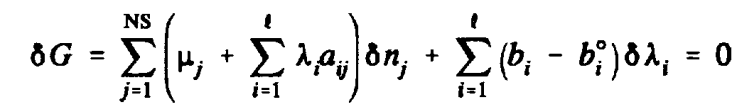

Luckily for us, these methods have been implemented many times. Let's use Cantera's built-in equilibrium solver to figure out our adiabtic flame temperature.

In [88]:
T_O2 = 90 # K
T_CH4 = 110 # K
P = 5100 * 6894.76 # psia --> Pa

reactants = ct.ThermoPhase('gri30.yaml')
O2 = ct.Quantity(reactants, constant='HP')
O2.TPX = T_O2, P, 'O2:1'
O2.moles = 2
CH4 = ct.Quantity(reactants, constant='HP')
CH4.TPX = T_CH4, P, 'CH4:1'
CH4.moles = 1.11
products = O2 + CH4
# Find equilibrium composition with 
# known h and p at the end of the process
products.equilibrate('HP', solver='gibbs')
print(products.report())


  gri30:

       temperature   3833.6 K
          pressure   3.5163e+07 Pa
           density   24.829 kg/m^3
  mean mol. weight   22.507 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -1.2483e+06       -2.8094e+07  J
   internal energy       -2.6645e+06       -5.9969e+07  J
           entropy             11468         2.581e+05  J/K
    Gibbs function       -4.5211e+07       -1.0176e+09  J
 heat capacity c_p            2314.1             52083  J/K
 heat capacity c_v            1944.7             43769  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2         0.0055762          0.062253           -18.672
                 H        0.00070729          0.015793           -9.3361
                 O         0.0071317          0.010033           -14.4

We can see that, with Gibbs minimization, Cantera can calculate more than 50 species in the product mixture at once on top of calculating the adiabatic flame temperature. Of course, Gibbs isn't the only equilibrium technique. There's Helmholtz minimization or the VCS method, but they all follow the same basic idea: maximize the entropy of the mixture. This is really what Gibbs is doing in the background, it's just that it's easier to use Gibbs when all we can measure is $T$ and $p$.

As for assuming constant pressure during the equilibrium calculation, we can do that because we are calculating the composition at a single axial station in the engine, so the control volume is infinitesimally small. This means the pressure throughout the control volume is effectively constant since the combustion process is a *deflagration*: a flame with a subsonic flame speed.

# Adiabatic Flame Temperature

Adiabatic flame temperature ($T_{ad}$) is the temperature that the chamber gases would reach if there was no loss of heat into the surroundings. Since the job of a nozzle is convert chemical energy into kinetic energy, $T_{ad}$ is a good indicator of how much of the energy is actually being extracted from our propellants before the gases are accelerated. In combustion theory, instead of mixture ratio, $T_{ad}$ is usually given as a function of a similar quanitity: equivalence ratio. This is simply the given mixture ratio over the stoichiometric mixture ratio (in this case, the mixture ratio is fuel-to-oxidizer. For rocketry, we usually do oxidizer-to-fuel).

### Equivalence Ratio

 The following plot gives $T_{ad}$ as a function of $\phi$, the equivalence ratio.

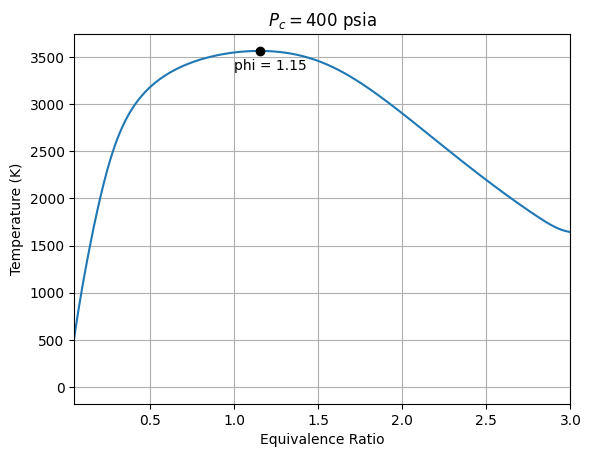

In [89]:
Pc = 400 # psia
Pe = 8 # psia
phi = np.linspace(0, 5, 1000)


Tad = np.zeros((len(phi)))
for j in range(len(phi)):
    #print(rocket.getMRforER(phi[j]))
    MR = rocket.getMRforER(phi[j])
    Tad[j] = rocket.get_Tcomb(Pc, MR)
Tad_max_index = Tad.argmax()

plt.figure
plt.scatter(phi[Tad_max_index], Tad[Tad_max_index], c = 'k', zorder = 3)
plt.annotate(f"phi = {(phi[Tad_max_index]):.2f}", 
             (phi[Tad_max_index], Tad[Tad_max_index]), 
             (phi[Tad_max_index] - 0.15, Tad[Tad_max_index]-200))
plt.plot(phi, Tad)
plt.xlim([0.05, 3])
plt.ylabel('Temperature (K)')
plt.xlabel('Equivalence Ratio')
plt.grid(True)
plt.title(fr"$P_c = ${Pc} psia");

As you can see, the temperature is highest near $\phi$ = 1 but slightly greater than 1. This is primarily because going slightly fuel rich makes up for energy that would be lost due to dissociation of the major species at those high temperatures. At high temperatures, species like $CO_2$ and $H_2O$ will start to form $CO$ or $OH$, which require high enthalpies of formation. Some of the energy that could have gone into generating thermal energy (translations, rotations, and vibrations of molecules) goes into breaking bonds (chemical energy). The occurs the least when the mixture is slightly richer for many hydrocarbon fuels (the relation may not necessarily hold if the hydrocarbons are heavier than the oxidizer, for example). You can kind of think of this by using the fact that $dh = C_p dT$, so maximizing the thermal energy requires a smaller molecular weight since that leads to higher $C_p$.

It would then seem plasuible to simply design the engine to operate close to stoich so that we get the highest energy release. However, the highest chamber temperature does not necessarily correspond to the highest exhaust kinetic energy (and therefore exhaust velocity, $V_e$), which is what *actually* needs to be maximized. Moreover, a high chamber temperature would make the TCA (thrust chamber assembly) hotter through convective heating, which leads to TCA yielding under thrust loads. To avoid this, we can run fuel rich or lean: whichever one gives the best efficiency.

To make this chart a bit more friendly for our discussion, $T_{ad}$ can plotted with respect to $MR$ (oxidizer-to-fuel)

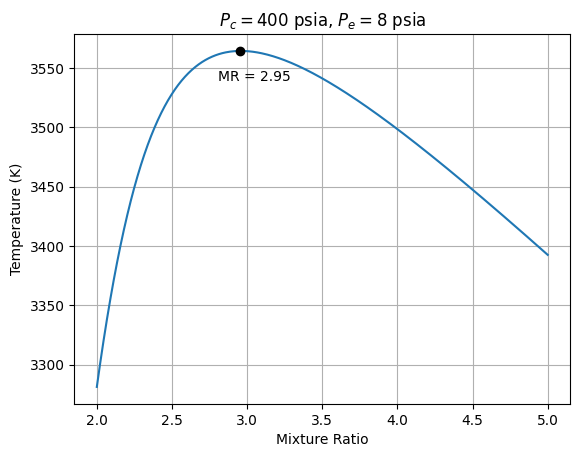

In [90]:
MR = np.linspace(2, 5, 400)
Tad = np.zeros((len(MR)))
for i in range(len(MR)):
    Tad[i] = rocket.get_Tcomb(Pc, MR[i])
Tad_max_index = Tad.argmax()
plt.figure
plt.scatter(MR[Tad_max_index], Tad[Tad_max_index], c = 'k', zorder = 3)
plt.annotate(f"MR = {(MR[Tad_max_index]):.2f}", 
             (MR[Tad_max_index], Tad[Tad_max_index]), 
             (MR[Tad_max_index] - 0.15, Tad[Tad_max_index]-25))
plt.plot(MR, Tad)
plt.ylabel('Temperature (K)')
plt.xlabel('Mixture Ratio')
plt.grid(True)
plt.title(fr"$P_c = ${Pc} psia, $P_e = ${Pe} psia");

### $T_c$ vs. $P_c$

Before moving on, I think it would also be good to observe the effect of altering chamber pressure on chamber temperature.

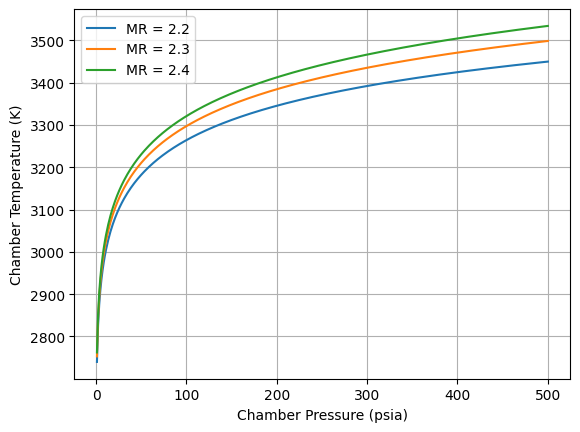

In [91]:
Pc = np.linspace(1, 500, 400) # psia
MR = np.array([2.2, 2.3, 2.4])

Tc = np.zeros((len(MR), len(Pc)))
for i in range(len(MR)):
    for j in range (len(Pc)):
        Tc[i, j] = rocket.get_Tcomb(Pc[j], MR[i])
plt.Figure
for i in range(len(MR)):
    plt.plot(Pc, Tc[i, :], label = f"MR = {MR[i]}")
plt.xlabel('Chamber Pressure (psia)')
plt.ylabel('Chamber Temperature (K)')
plt.grid(True)
plt.legend();

In the chamber pressure region that is most likely to concern YJSP (200 - 500 psia), it's clear that temperature seems to increase monotonically with pressure and that, as shown before, increasing $MR$ appears to also increase $T_c$. While the it's essential to know the exact magnitudes of these changes, having a general intution for how tweaking certain overall parameters can affect your engien conditions is very helpful for communicating with other engineers.

### $MR_{T_{max}}$ vs $P_c$

To better understand how the adiabatic flame temperature is affected by the chamber pressure, let's plot the relationship between the $MR$ that produces the highect $T_c$ and $P_c$

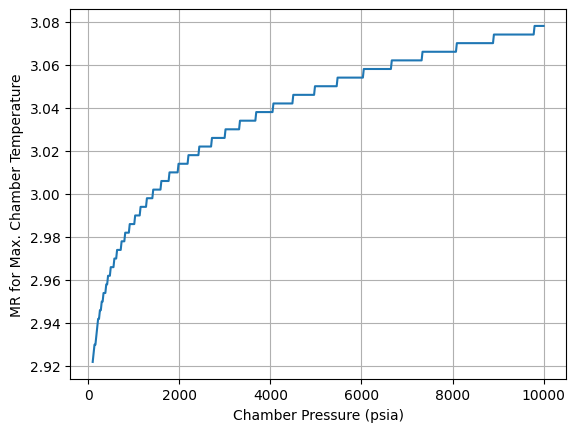

In [92]:
Pc = np.linspace(100, 10000, 500) # psia
MR = np.linspace(2, 4, 500) # arbitrary

MR_max_T = np.zeros(len(Pc))
for i, p in enumerate(Pc):
    Tc = np.zeros(len(MR))
    for j, mc in enumerate(MR):
        Tc[j] = rocket.get_Tcomb(p, mc)
    ind = Tc.argmax()
    MR_max_T[i] = MR[ind]

plt.Figure
plt.plot(Pc, MR_max_T)
plt.grid(True)
plt.xlabel("Chamber Pressure (psia)")
plt.ylabel("MR for Max. Chamber Temperature");

We can see pretty clearly that the chamber pressure increasing corresponds to an increase in the $MR$ required to induce the maximum chamber temperature. Each of the points on this curve theoretically corresponds to $\phi = 1$, but how? Shouldn't $\phi$ to get the maximum temperature stay the same? Not necessarily, because when the pressure that the combustion occurs at changes, so to does the equilibrium composition. It's not a simple as balancing a simple chemical reaction like for photosythesis. Instead, for combustion, many minor and major products all form is varying in concentrations depending on the pressure. As the pressure increases, certain molecules that were low in concentration before could now become a more relevant. 

Therefore, it's somewhat of a weird question to ask, "What is stoich for these propellants?" without specifying the chamber pressure. 

You may have also noticed that this curve looks a little **chopped** if you didn't index enough point for $P_c$ and $MR$. However, using a lot of points can take forever. A technique to get around this is discussed in the later sections.

# Specific Heat and Exhaust Molecular Weights

With a rocket engine, your goal is to take all of the stored chemical energy in your propellants and convert it into as much kinetic energy as you can. This means that for a given nozzle, there is a given amount of "exhaust kinetic energy" (the kinetic energy of the molecules exiting the nozzle).This fact can be shown with steady-flow conversation of energy (assume the chamber has negligible fluid velocity):

$h_{c} = h_{e} + \frac{1}{2}V_e^2$

Both $h_c$ and $h_e$ are functions of their respective temperatures, $T_c$ and $T_e$, respectively. Since $T_c$ is set by the chamber pressure and $T_e$ and is set by the shape of the nozzle, $V_e$ (and therefore the exhaust kinetic energy) is also fixed. The goal, then, is to maximize $h_c$ and minimze $h_e$ so that $V_e$ is as large as possible. Why? Using conservation of momentum gives:

$\tau = \dot{m}V_e + (P_e - P_{amb})A_e$

This means that increasing mass flow rate AND $V_e$ are essential to getting the most thrust that we can out of our engine. Usually, since our $P_c$ and throat area are set, our mass flow rate will be fixed due to flow choking. Therefore, we're most interested in maximizing our exhaust velocity, which, assuming we are perfectly expanded, is the thrust per unit mass flow rate. So in reality, getting most thrust for a given mass flow (which is a set function of a our nozzle shape and pressure) is really about minimizing $h_e$ because with a fixed $P_c$ and $T_c$, $h_c$ is also fixed.

Rearranging the energy equation and assuming that the gas is thermally perfect (which is a valid assumption due to the extremely high temperatures) gives:

$V_e = \sqrt{\int_{T_e}^{T_c}c_p dT}$

For the sake of this modeling, we will assume that the flow is calorically perfect (which isn't necessarily a bad assumption when doing preliminary sizing):

$V_e = \sqrt{c_p(T_c - T_e)}$

We can see that maximizing $V_e$ requires increasing $c_p$, the specific heat at constant pressure. This makes sense because having a higher specific heat for given $h_c$ means that you're effectively dropping $h_e$ more for the same $\Delta T = T_c - T_e$. Therefore, the question now becomes *how do we maximize $c_P$*?

The following chart gives some insight into how we can do that:


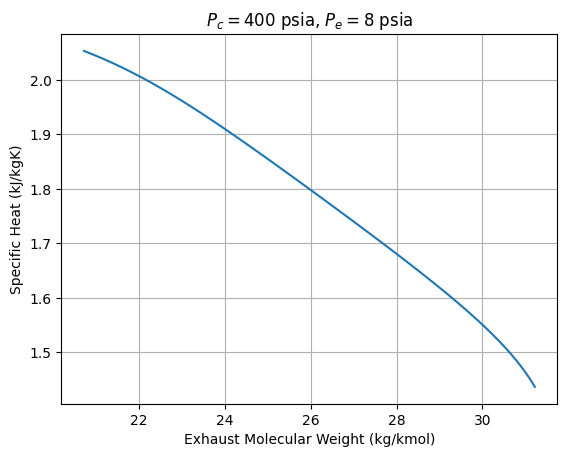

In [93]:
Pc = 400 # psia
Pe = 8 # psia
MR = np.linspace(2, 10, 400)

Cp = np.zeros((len(MR)))
MW = np.zeros((len(MR)))
for i in range(len(MR)):
    epsilon = rocket.get_eps_at_PcOvPe(Pc, MR[i], Pc/Pe, 1, 0) 
    # don't worry about these last two parameters, 
    # they will be explained later on
    cp_avg = np.average(rocket.get_HeatCapacities(Pc, MR[i], 
                                                  epsilon, 1, 0))
    mc, _ = rocket.get_exit_MolWt_gamma(Pc, MR[i], epsilon, 1, 0)
    Cp[i] = cp_avg
    MW[i] = mc

plt.figure
plt.plot(MW, Cp)
plt.xlabel('Exhaust Molecular Weight (kg/kmol)')
plt.ylabel('Specific Heat (kJ/kgK)')
plt.grid(True)
plt.title(fr"$P_c = ${Pc} psia, $P_e = ${Pe} psia");


Let's also see how $MW$ changes with $MR$

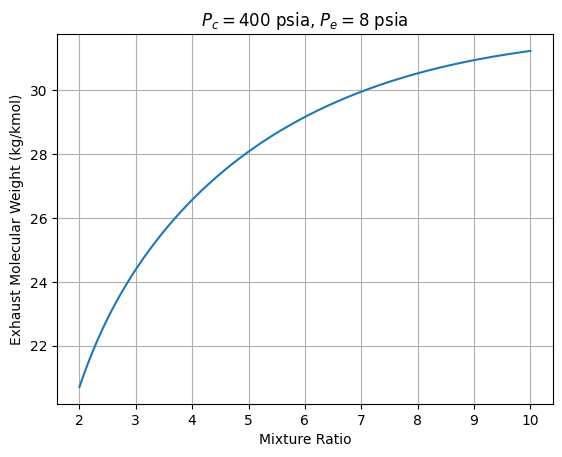

In [94]:
plt.figure
plt.plot(MR, MW)
plt.xlabel('Mixture Ratio')
plt.ylabel('Exhaust Molecular Weight (kg/kmol)')
plt.grid(True)
plt.title(fr"$P_c = ${Pc} psia, $P_e = ${Pe} psia");

As we can see, decreasing the molecular weight of the gases can increase the specific heat. Therefore, when trying to increase the exhaust velocity, it is best to aim for a lower molcular weight. Logically, this makes sense: for a given amount of kinetic energy, the smaller molecules will have higher velocity. Going back to the energy equation, it can be rewritten as:

$\frac{T_c}{T_e} = 1 + \frac{V_e^2}{2c_pT_e}$

This is more commonly recogrnized in the form:

$\frac{T_c}{T_e} = 1 + \frac{\gamma - 1}{2}M^2$

While this is used frequently with isentropic relations, this equation in particular is not necessarily an isentropic relation but rather an energy conservation equation for a steady, adiabatic system. With $T_c$ and $T_e$ fixed, it is clear that maximizing $V_e$ (or $M$) is the same as maximizing $c_p$ or minimizing $\gamma$.

This makes sense since for an ideal gas:

$\gamma = \frac{c_p}{c_v} = \frac{c_p}{c_p - R}$

Since $R < c_p$ is always true, the larger that $c_p$ gets, the smaller and closer to 1 that the $\gamma$ gets.

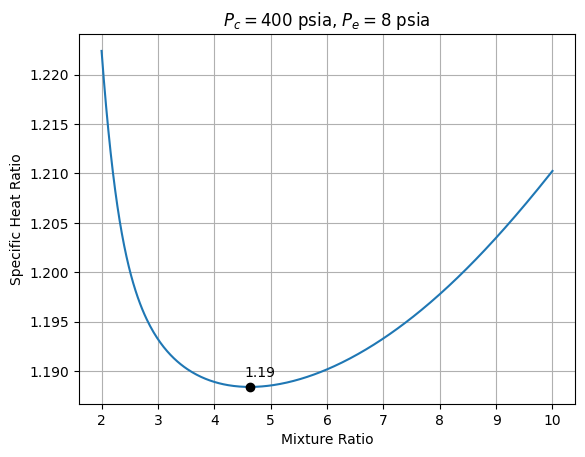

In [95]:
gamma = np.zeros((len(MR)))
for i in range(len(MR)):
    epsilon = rocket.get_eps_at_PcOvPe(Pc, MR[i], Pc/Pe, 1, 0)
    _, gc = rocket.get_Chamber_MolWt_gamma(Pc, MR[i], epsilon)
    _, gt = rocket.get_Throat_MolWt_gamma(Pc, MR[i], epsilon, 1)
    _, ge = rocket.get_exit_MolWt_gamma(Pc, MR[i], epsilon, 1, 0)
    gamma[i] = np.average((gc, gt, ge))

plt.figure
plt.plot(MR, gamma)
plt.ylabel('Specific Heat Ratio')
plt.xlabel('Mixture Ratio')
plt.grid(True)

gamma_min_ind = gamma.argmin()
plt.scatter(MR[gamma_min_ind], gamma[gamma_min_ind], c = 'k', zorder = 3)
plt.annotate(f"{(gamma[gamma_min_ind]):.2f}", 
             (MR[gamma_min_ind], gamma[gamma_min_ind]), 
             (MR[gamma_min_ind]-0.1, gamma[gamma_min_ind]+0.001))
plt.title(fr"$P_c = ${Pc} psia, $P_e = ${Pe} psia");

There is clearly a minimum gamma point, but whether it's in a practical MR is yet to be shown. Notice that the gamma values tend to hover around ~1.2. In fact, $\gamma = 1.2$ is a decent estimate when doing preliminary engine sizing. The big takeaway from this plot is that we can decrease $\gamma$ by increasing mixture ratio up until a certain point.

So far, we have tried to optimize our mixture ratio by increasing our $T_{ad}$ and decreasing our $\gamma$ (which was equivalent to minimizng our molecular weight) as much as possible. Together these parameters are great for figuring out how maximize orur $V_e$. Wouldn't it be great to have a single value that lets us analyze both at the same time?

# $C^{*}$ and $C^{*}_{eff}$

The characteristic velocity, $C^{*}$, is how we quantify how much chemical energy is available to be converted into kinetic energy at the nozzle exit. In other words, it's directly proportional to how much useful energy exists in the engine at any given time. This is why NASA CEA's $C^*$ values are the same at the throat and exit. It accounts for all of the effects of maximizing adiabatic flame temperature and specific heat. The higher your $C^{*}$, the more energy your engine is able to get out of your propellants. Let's plot $C^{*}$ as function of mixture ratio.

$C^{*} = \frac{P_cA_t}{\dot{m}}$

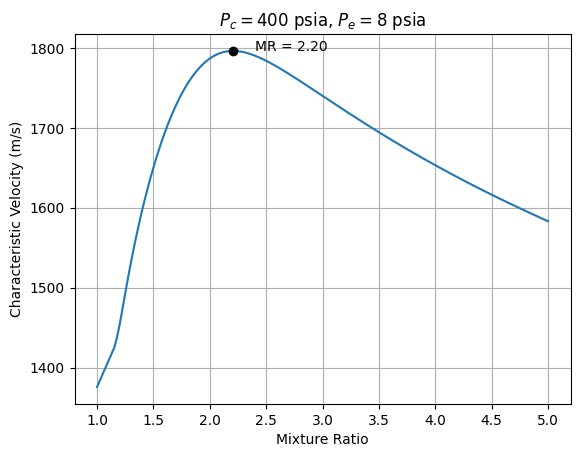

In [96]:
Pc = 400 # psia
Pe = 8 # psia
MR = np.linspace(1, 5, 400)

cstar = np.zeros((len(MR)))
cstar_test = np.zeros((len(MR)))
for i in range(len(MR)):
    eps = rocket.get_eps_at_PcOvPe(Pc, MR[i], Pc/Pe, 1, 0)
    cstar[i] = rocket.get_Cstar(Pc, MR[i])
    _, Tt, _ = rocket.get_Temperatures(Pc, MR[i], eps, 1, 0)
    mw, g = rocket.get_Throat_MolWt_gamma(Pc, MR[i], eps, 1)
    cstar_test[i] = ((1 + (g-1)/2)**(g/(g-1)))*np.sqrt(8314*Tt/(mw*g))

plt.Figure
plt.plot(MR, cstar)
plt.grid(True)
plt.xlabel("Mixture Ratio")
plt.ylabel("Characteristic Velocity (m/s)")

max_cstar_ind = cstar.argmax()
plt.scatter(MR[max_cstar_ind], cstar[max_cstar_ind], c = 'k', zorder = 3)
plt.annotate(f"MR = {(MR[max_cstar_ind]):.2f}", 
             (MR[max_cstar_ind], cstar[max_cstar_ind]), 
             (MR[max_cstar_ind] +0.2, cstar[max_cstar_ind]))
plt.title(fr"$P_c = ${Pc} psia, $P_e = ${Pe} psia");


**BE AWARE**: Rocket CEA tends to calculate $C^*$ to be around 2-3% higher than what NASA CEA calculates. NASA CEA is more accurate to what the value should actually be, which I found out by manually calculating $C^*$. This is important to note when we are trying to gather efficiency data from testing. Here's a quick plot showing the difference

Max Percent difference: 2.66%


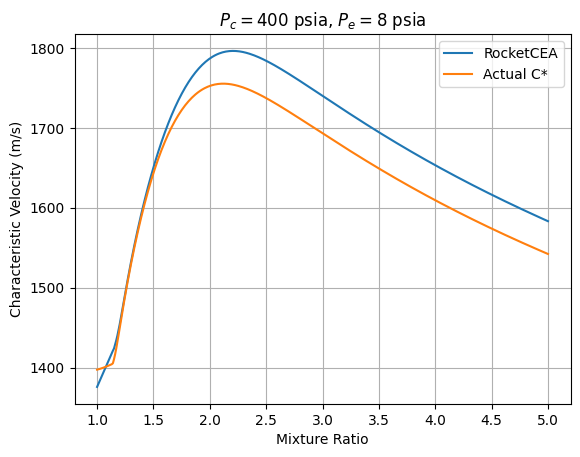

In [97]:
plt.Figure
plt.plot(MR, cstar, label = "RocketCEA")
plt.grid(True)
plt.xlabel("Mixture Ratio")
plt.ylabel("Characteristic Velocity (m/s)")

plt.plot(MR, cstar_test, label= "Actual C*")
plt.legend()

print(f"Max Percent difference: {((cstar[-1]*100/cstar_test[-1]) - 100):.2f}%")
plt.title(fr"$P_c = ${Pc} psia, $P_e = ${Pe} psia");

Let's also plot $C^*$ as a function of $P_c$.

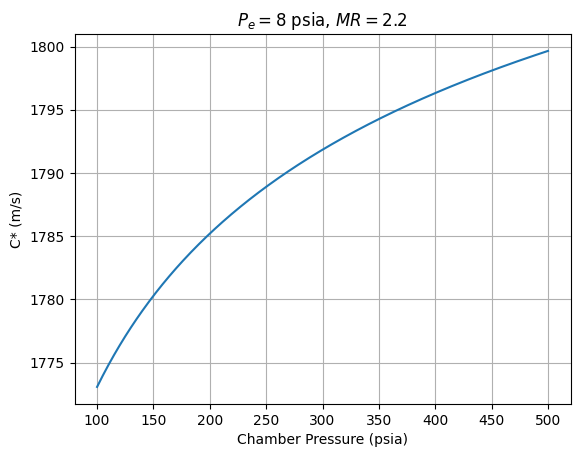

In [98]:
Pc = np.linspace(100, 500, 400) #psia
Pe = 8 # psia
MR = 2.2

cstar = np.zeros(len(Pc))
for i, p in enumerate(Pc):
    cstar[i] = rocket.get_Cstar(p, MR)

plt.figure
plt.plot(Pc, cstar)
plt.grid(True)
plt.xlabel("Chamber Pressure (psia)")
plt.ylabel("C* (m/s)")
plt.title(fr"$P_e = ${Pe} psia, $MR = ${MR}");

$C^*$ goes up with chamber pressure! This ties in to how well the energy is being released from our propellants: the higher the $P_c$, the higher the $T_c$, so there will be more energy to use to generate thrust, making the thrust higher for a given mass flow rate.

$C^*$ gives a bit more of a complete picture because now the curves for $T_{ad}$ and $\gamma$ have essentially combined to give an $MR$ that encompases all of the previously discussed effects. In fact, if we put together all of our isentropic relations and substitute into our earlier $C^{*}$ equation, we get:

$C^{*} = \sqrt{\frac{1}{\gamma}\left(\frac{\gamma + 1}{2}\right)^{\frac{\gamma+1}{\gamma -1}}\frac{\bar{R}}{MW}T_c}$

We see in this equation all of the design choices that were previously mentioned: to maximize $C^*$, it's best to minimize $\gamma$, minimze $MW$, and maximize $T_c$.

Say that you've now designed the engine to operate at an $MR$ that gives you the highest possible $C^{*}$. How do we know we're actually hitting that $C^{*}$? In reality, we can never actually achieve the design $C^{*}$, but we can get pretty close. How close we get to this value is called $C^{*}$ *efficiency* : it's a direct result of how well our propellants actually combine to release energy. $C^{*}_{eff}$ is function of a few variables but mainly:

1) **injector atomization and mixing**: the better your injector can bring the propellants together, the better they'll react. This usually plays the biggest role in affecting $C^{*}_{eff}$, which is why $C^{*}_{eff}$ is usually seen as a direct measure of injector performance.
2) **$L^{*}$, characteristic length**: propellants need time to react, and they get that time through the space in the chamber they have before accelerating through the nozzle. Bulkier propellants need more time and space to react. Check out Figure 4-7 in H&H (*Design of Liquid Propellant Rocket Engines* by Huzel and Huang) for more info on how $L^{*}$ and $C^{*}_{eff}$ are related. These kinds of relations can be determined through kinetics simulations but primarily through testing.
3) **Vaporization Loss**: All liquid propellants need energy to turn into gases. This is easier when they're atomized, but it takes some energy from the combustion process nonetheless.
4) **Film Cooling Loss**: fuel vapor jets can be used to create a higher equivalence ratio along the chamber walls, cooling them. This however, reduces the overall $T_c$, altering the exhaust velocity.
5) **Rayleigh Line Losses**: These are losses due to heat being absorbed through the chamber walls, which is effectively a straight cooling duct. This will take away some the energy from the low, reducing the exhaust velocity.

$C^{*}_{eff}$ is defined as $\frac{C^{*}_{actual}}{C^{*}_{ideal}}$, so the plot above actually reads the *ideal* $C^{*}$. When testing, we have a theoretical $C^{*}$ that we would like to hit. We compare that value to what we actually got to get a measure of how good our combustion is. Good injectors and engines can reach $C^{*}_{eff}$'s of 95% or even above that. A key takeway from this section is that because all of these variables were being used to optimize $V_e$, $C^{*}_{eff}$ is a direct measure of how close we are to the desired $V_e$.

Returning back to our original energy conservation equation, $h_{c} = h_{e} + \frac{1}{2}V_e^2$, we determined that the way to maximize our kinetic energy output was to maximize the difference $h_{c} - h_{e}$. Before, because we held $T_c$ (which is essentially $T_{ad}$ for our purposes) and $P_c$ constant, $h_c$ was also fixed. To clarify, *this is not because $P_c$ and $T_c$ are indpendent variables* that we can claim that $h_c$ is fixed but rather because $P_c$ and the composition, $MR$, are fixed for an engine. In fact, we literally saw $T_{ad}$ changing with mixture ratio and chamber pressure earlier. This is why $MR$ and $P_c$ are chosen as independent chamber parameters and not $T_{ad}$. Does this make the analysis done in the *Specific Heat and Exhaust Molecular Weight* section invalid? Not at all. It simply means that while we chose to observe the effects of altering mixture ratio on a single variable, in reality, many variables are affected by messing around with our key parameters. This is why $C^*$ is so helpful, it takes into the effects of changing $P_c$ and $MR$ on $T_c$ (and therefore $h_c$) and $c_p$.

Another parameter that we assumed to be fixed during this analysis was the nozzle itself, which, for a given $T_c$, assuming isentropic flow, also fixes your $T_e$. But maybe we can also strike a balance between our nozzle shape and the $MR$ to alter $T_e$ in such a way that gets us the highest $V_e$?

# $C_{\tau}$, Thrust Coefficient

From $h_{c} = h_{e} + \frac{1}{2}V_e^2$, we derived $V_e = \sqrt{c_p(T_c - T_e)}$, and previously, we focused primarily on adjusting $c_p$ and $T_c$, using $C^*$. However, if we now allow the nozzle shape to change as well, it's possible to also alter $T_e$ for a given $T_c$ and $MR$. Let's break apart $h_e$ using the definition of enthalpy:

$h_e(T_e) = u_e(T_e) + \frac{P_e}{\rho_e} = u_e(T_e) + RT_e$

Therefore, minimizing $h_e$ is all about making $u_e$ and $T_e$ as low possible. Since $u_e$ will decrease with temperature, it's really all about $T_e$. This the same as what $V_e = \sqrt{c_p(T_c - T_e)}$ is telling us. So how can this be done? Let's write $V_e = \sqrt{c_p(T_c - T_e)}$ in terms of Mach number and $\gamma$ instead:

$M_e = \sqrt{\left(\frac{T_c}{T_e} - 1\right)\frac{2}{\gamma - 1}}$

We will then substitute into the equation relating nozzle cross-sectional area to $M$: $\frac{A}{A_t} = \frac{1}{M}\left(\frac{1 + \frac{\gamma - 1}{2}M^2}{\frac{\gamma + 1}{2}}\right)^{\frac{\gamma + 1}{2(\gamma-1)}}$

$\frac{A_e}{A_t} = \frac{1}{\sqrt{\left(\frac{T_c}{T_e} - 1\right)\frac{2}{\gamma - 1}}}\left(\frac{T_c/T_e}{\frac{\gamma + 1}{2}}\right)^{\frac{\gamma + 1}{2(\gamma-1)}}$

The quantity $\frac{A_e}{A_t}$ is also known as $\epsilon$, the expansion ratio. For a fixed mass flow rate, $A_t$ will be fixed as well, so the $T_e$ can be plotted as a function of $\epsilon$

In [99]:
Pc = 400 # psia
MR = 2.4
epsilon = np.linspace(5, 70, 400)

Te = np.zeros((len(epsilon)))
Pe = np.zeros((len(epsilon)))
for i in range(len(epsilon)):
    _, _, Te[i] = rocket.get_Temperatures(Pc, MR, epsilon[i], 1, 0)
    Pe[i] = Pc / (rocket.get_PcOvPe(Pc, MR, epsilon[i], 1, 0))

plt.Figure
plt.plot(epsilon, Te)
plt.grid(True)
plt.xlabel('Expansion Ratio')
plt.ylabel('Exit Temperature (K)')
plt.title(f"$P_c =$ {Pc} psia, $MR = $ {MR}");

Let's do the same for exit pressure.

In [100]:
plt.Figure
plt.plot(epsilon, Pe)
plt.grid(True)
plt.xlabel('Expansion Ratio')
plt.ylabel('Exit Pressure (psia)')
plt.title(f"$P_c =$ {Pc} psia, $MR = $ {MR}");

Not only does the temperature get lower with expansion ratio, but so does the pressure. This makes sense from a few standpoints. With $\frac{T_c}{T_e} = \left(\frac{P_c}{P_e}\right)^{\frac{\gamma}{\gamma - 1}}$, we can see that for the fixed chamber condtions, if $T_e$ goes lower, $P_e$ goes lower. Addtionally, just from intuition, if we want a higher flow speed, we need a greater $\Delta p$, hence $P_e$ must be lower.

Therefore, since an expanded nozzle decreases $T_e$ and $P_e$, it's clear that expanding the nozzle (increasing the exit area) plays a substantial role in how high the exhaust velocity gets. In fact, we could have simply seen that fact in this equation, $\frac{A}{A_t} = \frac{1}{M}\left(\frac{1 + \frac{\gamma - 1}{2}M^2}{\frac{\gamma + 1}{2}}\right)^{\frac{\gamma + 1}{2(\gamma-1)}}$, but I think it's helpful to see how energy conservation plays a role in optimizing our nozzle.

So as we increase our $\epsilon$, we get a higher $V_e$, and since our mass flow rate is fixed by $P_c$ and $MR$, by $\tau = \dot{m}V_e$ (perfect expansion case), our thrust goes up! So, in other words, by adding a nozzle, we've increased the amount of thrust that we would have gotten as opposed to just having a cylindrical engine. The thrust generated by this theoretical cylinder engine would just be the chamber pressure times some reference area. We will use the throat as our reference, so the reference thrust is $P_cA_t$. To compare this to how good our thrust actually is with the nozzle, we can do $\frac{\tau}{P_cA_t}$. This quantity has a special name: the *Thrust Coefficient*, $C_{\tau}$. If $C^*$ is a measure of how good our propellant chemistry is at generating thrust, $C_{\tau}$ is a measure of how good our nozzle is. This does not mean that it is independent of chamber pressure, however. Let's verify this

**BE CAREFUL** when using RocketCEA's *getFrozen_PambCf()* or *get_PambCf()* functions. They output a tuple of form (perfect expansion $C_{\tau}$ (what NASA CES gives), actual $C_{\tau}$, and the type of expansion).

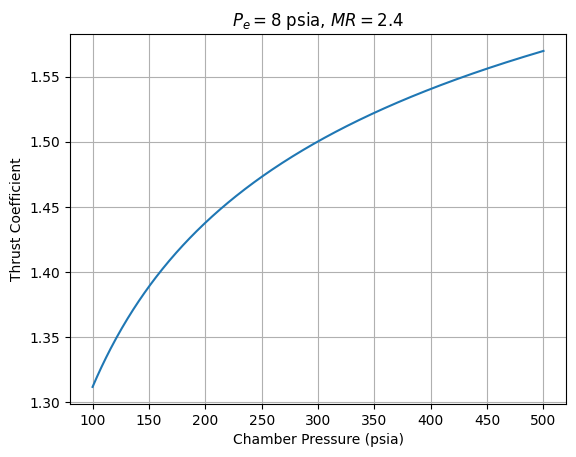

In [101]:
Pc = np.linspace(100, 500, 400) # psia
Pe = 8 # psia
MR = 2.4

Ct = np.zeros((len(Pc)))
for i in range(len(Pc)):
    epsilon = rocket.get_eps_at_PcOvPe(Pc[i], MR, Pc[i]/Pe, 1, 0)
    _, Ct[i], _ = rocket.getFrozen_PambCf(Pe, Pc[i], MR, epsilon, 0)
plt.figure
plt.plot(Pc, Ct)
plt.xlabel("Chamber Pressure (psia)")
plt.ylabel("Thrust Coefficient")
plt.grid(True)
plt.title(f"$P_e = ${Pe} psia, $MR = ${MR}");

**NOTICE** that I never used thrust to calculate the thrust coefficient! This implies that $C_{\tau}$ is more a function of the nozzle and the chamber conditions rather than our desired thrust. We can see why by expanding the definition of thrust coefficient using mass conservation for the perfectly expanded case:

$C_{\tau} = \frac{\tau}{P_cA_t} = \frac{\dot{m}V_e}{P_cA_t} = \frac{\dot{m}V_e}{P_cA_t} = \frac{\rho_t V_tV_e}{P_c} = \frac{\rho_t \sqrt{\gamma R T_t}V_e}{P_c} = \frac{P_t\sqrt{\gamma R T_t}V_e}{RT_tP_c}$

Because we know all of the upstream conditions and the fact that $M_t = 1$, $C_{\tau}$ can be calculated without $\tau$. This relationship can be neatly summarized in this formula: $C_{\tau} = \sqrt{\frac{2\gamma^2}{\gamma - 1}\left(\frac{2}{\gamma + 2}\right)^{\frac{\gamma + 1}{\gamma - 1}}\left(1 - \left(\frac{P_e}{P_c}\right)^{\frac{\gamma - 1}{\gamma}}\right)}$. If the nozzle is not perfectly expanded, then the formula becomes:

$C_{\tau} = \sqrt{\frac{2\gamma^2}{\gamma - 1}\left(\frac{2}{\gamma + 2}\right)^{\frac{\gamma + 1}{\gamma - 1}}\left(1 - \left(\frac{P_e}{P_c}\right)^{\frac{\gamma - 1}{\gamma}}\right)} + \epsilon\left(\frac{P_e - P_{amb}}{P_c}\right)$


Even though $C_{\tau}$ changes with pressure, when discussing changes in pressure that are over hundreds of psia, it's safe to assume that the thrust coefficient does not change too much. For example, between 300 and 400 psia, the thrust coefficient increases by less than 0.1. Therefore, when testing, with slight errors in hitting the target chamber pressure, it is safe to say that $C_{\tau}$ remains roughly constant. When deciding on what chamber pressure to use for a given thrust, we can refer to $\tau = C_{\tau}P_cA_t$. Because we know that $C_{\tau}$ increases with $P_c$, we can safely say that a given thrust is easier to achieve with a higher pressure. We can also conclude that a higher thrust can be achieved using a lower pressure with a better nozzle. It should be noted that $C_{\tau}$ by itself is not a measure of efficiency but rather a theoretical values that represents how much more thrust we can get. Similar to characteristic velocity, whether or not we hit a $C_{\tau}$ would be determined by our manufacturing ability and validating in testing.

Let's check out how the thrust coefficient is affect by the ambient pressure

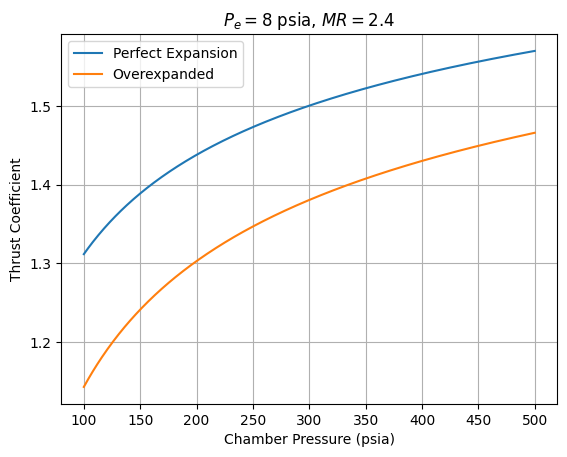

In [102]:
Ct = np.zeros((2, len(Pc)))
for i in range(len(Pc)):
    epsilon = rocket.get_eps_at_PcOvPe(Pc[i], MR, Pc[i]/Pe, 1, 0)
    Ct[0, i], Ct[1, i], _ = rocket.getFrozen_PambCf(14.67, Pc[i], MR, 
                                                    epsilon, 0)

plt.figure
plt.plot(Pc, Ct[0, :], label = 'Perfect Expansion')
plt.plot(Pc, Ct[1, :], label = "Overexpanded")
plt.xlabel("Chamber Pressure (psia)")
plt.ylabel("Thrust Coefficient")
plt.legend()
plt.grid(True)
plt.title(f"$P_e = ${Pe} psia, $MR = ${MR}");

This tells us that $\frac{\tau}{\dot{m}}$ goes down as the ambient pressure increases relative to the exit pressure. Therefore, if we want to get same amount of the thrust as we increase ambient pressure, we need a higher mass flow rate.

Let's see how our thrust coefficient changes with $MR$, assuming that the nozzle is perfectly expanded.

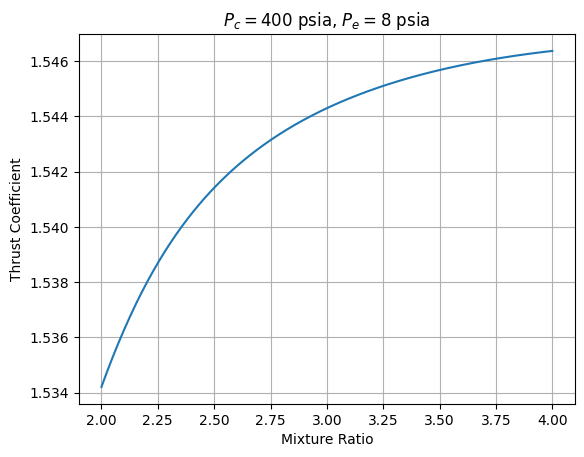

In [103]:
Pc = 400 # psia
Pe = 8 # psia
MR = np.linspace(2, 4, 400)

Ct = np.zeros((len(MR)))
for i in range(len(MR)):
    epsilon = rocket.get_eps_at_PcOvPe(Pc, MR[i], Pc/Pe, 1, 0)
    #print(rocket.getFrozen_PambCf(Pe, Pc, MR[i], epsilon, 0))
    _, Ct[i], _ = rocket.getFrozen_PambCf(Pe, Pc, MR[i], epsilon, 0)
plt.Figure
plt.plot(MR, Ct)
plt.grid(True)
plt.xlabel("Mixture Ratio")
plt.ylabel("Thrust Coefficient")
plt.title(f"$P_c = ${Pc} psia, $P_e = ${Pe} psia");

While $MR$ does effect thrust coefficient, the change is slight in the region that anyone would be designing an RP-1/LOX engine. This means that while we can try to land on a compromise between nozzle shape and mixture ratio, choosing a mixture ratio that improves mixing efficiency should be the priority. That being said, it's clear from the calculation of $C_{\tau}$ that $C_{\tau}$ itself is dependent on $\gamma$, which, as we discussed, plays a huge role in determining the exhaust velocity. Therefore, both $C_{\tau}$ and $C^*$ should be taken into account when choosing an MR to get the highest possible exhaust velocity.

Before diving into how that's done, I think it would be a good idea to see how these variables play together.

# Relating $C^*$ and $C_{\tau}$ to Thrust and Mass Flow Rate

Let's say that you're sizing vehicle and engine with the following assumptions and parameters:

- $\tau = 2500$ lbf
- $P_c = 300$ psia
- $P_e = 10$ psia
- $MR = 2$
- $\epsilon_c$ = 4.3
- $L^* = 40$ inches
- $C^*_{eff} = 85\%$

To size your tanks, you need to know your engine's mass flow rate. How do we find this value?

In [104]:
T = 2500 # lbf
Pc = 300 # psia
Pe = 10 # psia
MR = 2
C_star_eff = 0.85

Just based on $C^*_{eff}$, you may have already guessed that our propellant mixing isn't happening as well as we'd like or that some other phenomenon is taking away energy from the combustion gases. This would decrease $V_e$, so the ideal mass flow rate for $C^*_{eff} = 100\%$ isn't going to achieve the thrust we want. The $C^*_{eff}$ could be lower either because of our injector's mixing capabilities or because our $L^*$ is too short. Let's first figure out what the ideal case would be.

IMG_6379 copy.PNG

### Ideal Case ($C^*_{eff} = 100\%$)

When we're doing this kind of analysis, we should do it for the perfectly expanded case (more on why we do this in later sections). Therefore, $\tau = \dot{m}V_e$. CEA, using energy conservation, can actually determine $V_e$ for us.

In [105]:
epsilon = rocket.get_eps_at_PcOvPe(Pc, MR, Pc/Pe, 1, 0)
_, _, ae = rocket.get_SonicVelocities(Pc, MR, epsilon, 1, 0) 
# exit sonic velocity
Me = rocket.get_MachNumber(Pc, MR, epsilon, 1, 0) 
# exit Mach number
Ve_ideal = ae*Me
print(f"Exhaust Velocity = {Ve_ideal:.2f} m/s")

Exhaust Velocity = 2556.47 m/s


Since we know thrust and $V_e$, we can find $\dot{m}$. Let's make sure to convert our thrust units to Newtons from lbf.

In [106]:
mdot_ideal = (T * 4.44822) / Ve_ideal # lbf --> N
print(f"Ideal Mass Flow Rate = {mdot_ideal:.2f} kg/s")

Ideal Mass Flow Rate = 4.35 kg/s


With our mixture ratio, we can actually figure out our individual fuel and oxidizer flow rates.

In [107]:
fuel_mdot = (1/(MR+1))*mdot_ideal # 1 part fuel for MR parts oxidizer
ox_mdot = (MR/(MR+1))*mdot_ideal
print(f"Fuel: {fuel_mdot:.2f} kg/s, Oxidizer: {ox_mdot:.2f} kg/s")

Fuel: 1.45 kg/s, Oxidizer: 2.90 kg/s


We can also calculate the necessary throat area for this scenario using the isentropic mass flow rate equation:

In [108]:
def throat_area(Pc, Pe, MR, mdot, rocket): # psia, psia, _, kg/s, _
    epsilon = rocket.get_eps_at_PcOvPe(Pc, MR, Pc/Pe, 1, 0)
    #_, _, ae = rocket.get_SonicVelocities(Pc[i], MR, epsilon, 1, 0)
    #ve = ae * rocket.get_MachNumber(Pc[i], MR, epsilon, 1, 0)
    mc, gc = rocket.get_Chamber_MolWt_gamma(Pc, MR, epsilon)
    mt, gt = rocket.get_Throat_MolWt_gamma(Pc, MR, epsilon, 1)
    me, ge = rocket.get_exit_MolWt_gamma(Pc, MR, epsilon, 1, 0)
    gamma = np.average((gc, gt, ge))
    m = np.average((mc, mt, me))
    R = 8314 / m
    _, T_t, _ = rocket.get_Temperatures(Pc, MR)
    P_t = Pc / (rocket.get_Throat_PcOvPe(Pc, MR))
    At = ((mdot / (P_t*6894.76))*np.sqrt(R*T_t/gamma)) * 1550 # m2 --> in2
    return At

In [109]:
At_ideal = throat_area(Pc, Pe, MR, mdot_ideal, rocket)
print(f"Throat Area = {At_ideal:.2f} in^2")

Throat Area = 5.72 in^2


### $C^*_{eff} = 85\%$

Now let's check if we can achieve the desired thrust with this flow rate and 85% $C^*$ efficiency. Let's start by using the definitions of thrust, $C^*$ and $C_{\tau}$ for perfect expansion:

$\tau = \dot{m}V_e$

$C^*_{ideal} = \frac{P_cA_t}{\dot{m}}$

$C_{\tau, ideal} = \frac{\tau}{P_cA_t}$

We can rewrite $C^*_{ideal}$ in terms of efficiency as $C^*_{eff}C^*_{actual} = \frac{P_cA_t}{\dot{m}}$. Combining this equation with the $C_{\tau, ideal}$ equation gives

$(C^*_{eff}C^*_{actual})C_{\tau, ideal} = \frac{\tau}{\dot{m}} = V_e$

If we were worried about nozzle efficiency, we could also write

$(C^*_{eff}C^*_{actual})(C_{\tau, eff}C_{\tau, ideal}) = \frac{\tau}{\dot{m}} = V_e$

With this formulation, we can see that the quantity we've been trying to maximize this whole time is just the product of $C_{\tau}$ and $C^*$. In other words, how much thrust we get for a given flow rate is a a combination of how well our reaction releases energy and how well our nozzle converts the energy relased by our reaction and converts it into kinetic energy. All effects regarding $T_{ad}$, $\gamma$, $MW$, and $\epsilon$ are combined into these two parameters to optimize $V_e$. Based on that and the above equations, we can also write $C^*_{ideal}C_{\tau, ideal} = V_{e, ideal}$ and $C^*_{actual}C_{\tau, actual} = V_{e, actual}$. So,

$C^*_{eff}C_{\tau, eff}V_{e, ideal} = V_{e, actual}$

For our purposes, let's say $C_{\tau, eff} = 100\%$, so then $C^*_{eff}V_{e, ideal} = V_{e, actual}$. Substituting in our $C^*_{eff}$ and $V_{e, ideal}$, we get

In [110]:
Ve_actual = C_star_eff*Ve_ideal
print(f"Actual Exhaust Velocity: {Ve_actual:.2f} m/s")

Actual Exhaust Velocity: 2173.00 m/s


Let's recalculate the necessary mass flows needed to achieve the same thrust and throat area.

In [111]:
mdot_actual = (T * 4.44822) / Ve_actual # lbf --> N
print(f"Ideal Mass Flow Rate = {mdot_actual:.2f} kg/s")

Ideal Mass Flow Rate = 5.12 kg/s


In [112]:
fuel_mdot_actual = (1/(MR+1))*mdot_actual
ox_mdot_actual = (MR/(MR+1))*mdot_actual
print(f"Fuel: {fuel_mdot_actual:.2f} kg/s, Oxidizer: {ox_mdot_actual:.2f} kg/s")

Fuel: 1.71 kg/s, Oxidizer: 3.41 kg/s


In [113]:
At_actual = throat_area(Pc, Pe, MR, mdot_actual, rocket)
print(f"Throat Area = {At_actual:.2f} in^2")

Throat Area = 6.73 in^2


Therefore, for a lower $C^*_{eff}$, we need a higher $\dot{m}$ and larger $A_t$ to reach the same desired thrust. So when we're designing an engine, realistically, we should be doing a substantial amount of testing to make our injector atomization better for better mixing, line losses, etc. and we should be iterating on our nozzle design based on the actual mass flow values.

# $I_{sp}$, Specific Impulse

Now that we've established how $C_{\tau}$ and $C^*$ are used, we can move on to figuring out how both of them can be combined to optimize our engine. Dealing explicitly with the ideal $V_e$, we know that $C^*_{ideal}C_{\tau, ideal} = V_{e, ideal}$. We saw in the previous section that CEA could directly calculate $V_e$ for us, which means that we can understand the effect of $MR$ on $V_{e, ideal}$ without knowing what the full nozzle looks like: knowing $P_c$, $P_e$, and $MR$ is enough. Therefore, to get the full effect of $C^*_{ideal}C_{\tau, ideal}$, we can plot $V_{e, ideal}$ as a function of $MR$.

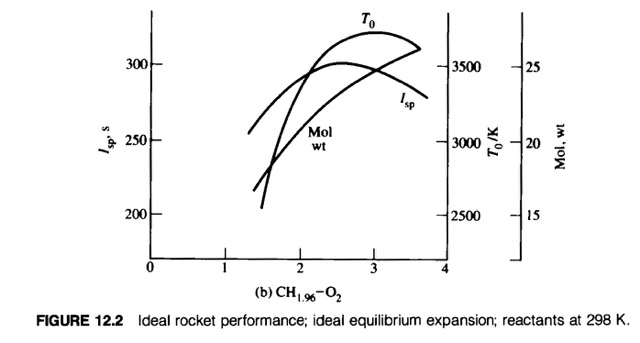

In [114]:
Pc = 400 # psia
Pe = 8 # psia
MR = np.linspace(1.5, 3, 800)

Ve_ideal = np.zeros(len(MR))
for i in range(len(MR)):
   epsilon = rocket.get_eps_at_PcOvPe(Pc, MR[i], Pc/Pe, 1, 0)
   _, _, ae = rocket.get_SonicVelocities(Pc, MR[i], epsilon, 1, 0)
   Me = rocket.get_MachNumber(Pc, MR[i], epsilon, 1, 0)
   Ve_ideal[i] = ae*Me

plt.Figure
plt.plot(MR, Ve_ideal)
plt.xlabel("Mixture Ratio")
plt.ylabel("Ideal Exhaust Velocity (m/s)")
plt.grid(True)
max_Ve_ind = Ve_ideal.argmax()
plt.scatter(MR[max_Ve_ind], Ve_ideal[max_Ve_ind], c='k', zorder = 3)
plt.annotate((f"MR = {(MR[max_Ve_ind]):.2f}"), 
             (MR[max_Ve_ind], Ve_ideal[max_Ve_ind]), 
             (MR[max_Ve_ind]-0.15, Ve_ideal[max_Ve_ind]-15))
plt.title(f"$P_c = ${Pc} psia, $P_e = ${Pe} psia");

We have now established a wholistic approach for optimizing engine efficiency: instead of trying to strike a balance between $T_c$, $\gamma$, and $\epsilon$, we can just go directly to what it is we are trying to optimize. So what's the point of looking at $T_c$, $\gamma$, $\epsilon$, $C^*$, and $C_{\tau}$? It's because these variables provide direct insight into how altering our primary parameters change our engine. When testing, we want to know exactly what part of the engine is contributing to inefficiency, whether it's the injector, converging section, etc. Understanding the intermediate quantities gives us essential insight into what's actually improving or worsening our engine. That being said, if you're in a hurry, $V_e$ is a good way to go.

One key assumption that we've made during this analysis is that the engine is perfectly expanded. But in reality, the thrust output of the engine will be greatly affected by the ambient pressure:

$\tau = \dot{m}V_e + (P_e - P_{amb})A_e$

So in this regard, $V_e$ is not actually the thrust per unit mass flow unless the nozzle is perfectly expanded. The actual thrust per unit mass flow is called the *equivalent exhaust velocity* or *effective exhaust velocity*.

$V_{eq} = \frac{\tau}{\dot{m}} = V_e + \frac{(P_e - P_{amb})}{\dot{m}}A_e$

We can compare what $V_{eq}$ looks next to $V_e$ for the case of an overexpanded nozzle at sea-level ($P_e < P_{amb}$). Note that we don't know $A_e$ or $\dot{m}$, but we can use mass conservation and the ideal gas law to solve for $V_{eq}$ anyway.

$V_{eq} = V_e + \frac{(P_e - P_{amb})}{\dot{m}}A_e = V_e + \frac{(P_e - P_{amb})}{\rho_eV_e} = V_e + \frac{(P_e - P_{amb})RT_e}{P_eV_e}$



In [115]:
Pamb = 14.67 # psia
Veq = np.zeros((len(MR)))
for i in range(len(MR)):
    epsilon = rocket.get_eps_at_PcOvPe(Pc, MR[i], Pc/Pe, 1, 0)
    _, _, Te = rocket.get_Temperatures(Pc, MR[i], epsilon, 1, 0)
    mc, _ = rocket.get_exit_MolWt_gamma(Pc, MR[i], epsilon, 1, 0)
    R = 8314/mc
    Veq[i] = Ve_ideal[i] + (Pe-Pamb)*R*Te/(Pe*Ve_ideal[i])
plt.Figure
plt.plot(MR, Ve_ideal, label = "Exhaust")
plt.xlabel("Mixture Ratio")
plt.ylabel("Exit Velocity (m/s)")
plt.grid(True)
plt.plot(MR, Veq, label = f'Equivalent, Pamb = {Pamb} psia')
plt.legend()
plt.scatter(MR[max_Ve_ind], Ve_ideal[max_Ve_ind], c='k', zorder = 3)
plt.annotate((f"MR = {(MR[max_Ve_ind]):.2f}"), 
             (MR[max_Ve_ind], Ve_ideal[max_Ve_ind]), 
             (MR[max_Ve_ind]-0.05, Ve_ideal[max_Ve_ind]-25))
max_eq_ind = Veq.argmax()
plt.scatter(MR[max_eq_ind], Veq[max_eq_ind], c='k', zorder = 3)
plt.annotate((f"MR = {(MR[max_eq_ind]):.2f}"), 
             (MR[max_eq_ind], Veq[max_eq_ind]), 
             (MR[max_eq_ind]-0.05, Veq[max_eq_ind]-25))
plt.title(f"$P_c = ${Pc} psia, $P_e = ${Pe} psia");

We can see that the ambient pressure actually decreases the $\frac{\tau}{\dot{m}}$ by an appreciable amount. Therefore, if we want to be completely accurate about our thrust per unit mass flow rate, we should be plotting the equivalent velocity. You'll notice, however, that the $V_{eq}$ is very similar to the $V_e$ curve but shifted down and slightly to the left. This can be understood by observing that the pressure term in $V_{eq} = V_e + \frac{(P_e - P_{amb})RT_e}{P_eV_e}$ becomes more negative as $P_{amb}$ increases.

Observe that $V_{eq}$ has the same units of $\frac{\tau}{\dot{m}}$, which has units of $\frac{N \cdot s}{kg}$, which are the units of momentum change (*impulse*) over mass. Essentially, $V_{eq}$ represents how much the instantaneous momentum of the rocket is changing due to thrust for every bit of propellant mixture mass that is used. Hence, this quantity $V_{eq}$ is often to referred to as the *specific impulse*, $I_{sp}$.

In typical application, $I_{sp}$ is actually defined as $\frac{V_{eq}}{g}$, where $g$ is the standard Earth gravitational acceleration at sea-level, just so that we get a better sense of how good the rocket is at breaking free from the constraints of gravity. Therefore, to summarize our discussion:

$C^*_{ideal}C_{\tau, ideal} = \frac{\tau}{\dot{m}} = V_e + \frac{(P_e - P_{amb})}{\dot{m}}A_e = V_{eq} = I_{sp}g$

This is why when people are talking about engine performace, $I_{sp}$ is a quantity that is guarunteed to come up. When it comes to actually sizing our rockets, we often care about the case in which we are perfectly expanded, so $V_{eq} = I_{sp}g = V_e$ anyway. This is usually the $I_{sp}$ value that is reported: the one at perfect expansion. But depending on the source, we have to be careful about how we interpret our $I_{sp}$. For example, sometimes the $I_{sp}$ is reported as the one at sea level, which, based on the plot above, would be less than the perfect expansion $I_{sp}$. Sometimes $I_{vac}$ is given instead of $I_{sp}$, which is the case in which $P_{amb} = 0$. When normalized by $g$, $I_{sp}$ will have units of *seconds*. NASA CEA, however, directly reports $V_{eq}$ as the $I_{sp}$, so neither the $I_{sp}$ nor the $I_{vac}$ in the NASA CEA output are normalized by $g$. In this case, the units will be the same units as velocity. RocketCEA does normalize the output by $g$.

Let's plot $I_{sp}$ vs $P_e$ to get a wholistic picture.

In [116]:
MR = 2.2
Pe = np.linspace(6, 20, 400)

Isp = np.zeros(len(Pe))
for i, p in enumerate(Pe):
    eps = rocket.get_eps_at_PcOvPe(Pc, MR, Pc/p, 1, 0)
    Isp[i], _ = rocket.estimate_Ambient_Isp(Pc, MR, eps, Pamb, 1, 0)

plt.Figure
plt.plot(Pe, Isp)
plt.grid(True)
plt.xlabel("Exit Pressure (psia)")
plt.ylabel("Specific Impulse (s)")
ind = Isp.argmax()
plt.scatter(Pe[ind], Isp[ind], c='k', zorder = 3)
plt.annotate(f"Pe = {(Pe[ind]):.2f}", (Pe[ind], Isp[ind]), 
             (Pe[ind]-1, Isp[ind]-1))
plt.title(f"$P_c = ${Pc} psia, $MR = ${MR}, $Pamb = ${Pamb} psia");

As we can see, for a given $MR$, the $I_{sp}$ is actually maximum when the engine is perfectly expanded for a given ambient pressure. This is the exit pressure for which the engine conventionally considered to be the most efficient. We will see this same idea in the next section. For now, it's important to understand that we have to be cognizant of the exit pressure we are designing to when we're choosing an $MR$ and nozzle shape to get the highest $I_{sp}$. This relationship between exit pressure and $I_{sp}$ at constant ambient pressure is one we will see later on too.

The key takeaway here is that for finding an optimal $MR$, everything we've discussed comes down to maximizing our $I_{sp}$ for a given set of parameters. Whether we choose to run at this optimal $MR$ depends primarily on our manufacturing capabilities.

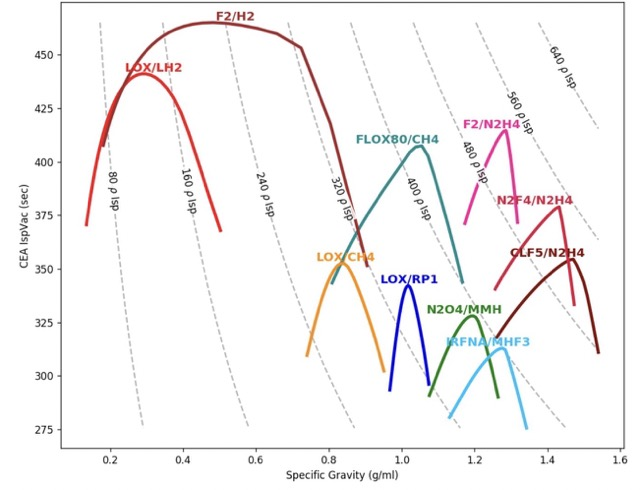

# $I_{sp}$ and $\tau$ for Varying Ambient Conditions

### What function (NASA CEA vs RocketCEA) gives the most realistic $I_{sp}$ and how does it inform nozzle design?

*get_Isp()* gives CEA's $I_{vac}$, which assumes an ambient pressure of 0. This value tends to greatly overestimate what would be measured at sea level. *estimate_Ambient_Isp()* gives $I_{sp}$ while accounting for losses due to over/underexpansion with sea level ambient pressure (by default), which is what is actually expected to be measured. However, this is not what NASA CEA gives as $I_{sp}$. For a given $P_e$ or expansion ratio, CEA assumes that the engine is at an altitude at which $P_e = P_{amb}$, meaning it is always perfectly expanded. This would also overshoot the expected $I_{sp}$ value, as a lower value is what would actually be measured at sea level. Hence, for $I_{sp}$ at sea level, the most accurate output would be:

*estimate_Ambient_Isp(Pc, MR, epsilon, Pamb = 14.7)*, where the $P_{amb} = 14.7$ psia is a default parameter.

CEA calculations maintain constant propellant consumption while allowing thrust to vary with ambient pressure as altitude increases instead of fixing the thrust and expecting a changing $\dot{m}$: the former case is more realistic. In the CEA case, the maximum thrust, and hence $I_{sp}$, would be achieved in a vaccuum for a given nozzle shape since $V_e$ remains constant, so the pressure-thrust term is maximized. This explains why $I_{vac}$ is always greater than $I_{sp}$ in CEA. Therefore:

*get_Isp() == $\frac{I_{vac, CEA}}{g}$  >  estimate_Ambient_Isp(Pc, MR, epsilon, Pamb = Pe) == $\frac{I_{sp, CEA}}{g}$  >  estimate_Ambient_Isp(Pc, MR, epsilon, Pamb = 14.7)*

Let's visual how ambient conditions affect our $I_{sp}$ over time, from Atlanta's altitude, which is about 1,050 above sea level, to about 200,000 ft above sea level.

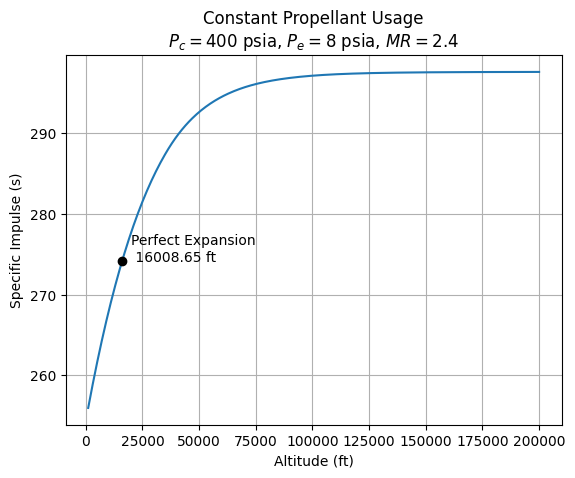

In [117]:
Pc = 400 # psia
Pe = 8
altitude = np.linspace(1050, 200000, 400) # ft
MR = 2.4


h = altitude * 0.3048  # ft -> m
atm = Atmosphere(h) # initialize our Standard Atmosphere model
Pamb = atm.pressure / 6895  # Convert Pa to psia

Isp = np.zeros(len(Pamb))
epsilon = rocket.get_eps_at_PcOvPe(Pc, MR, Pc / Pe, frozen=1, 
                                   frozenAtThroat=0)
for i, P in enumerate(Pamb):
    Isp[i], _ = rocket.estimate_Ambient_Isp(Pc, MR, epsilon, 
                                            float(P), frozen=1, 
                                            frozenAtThroat=0)

plt.figure()
plt.plot(altitude, Isp)
plt.ylabel("Specific Impulse (s)")
plt.xlabel("Altitude (ft)")
plt.grid(True)

ind = np.abs(Pamb - Pe).argmin()
plt.scatter(altitude[ind], Isp[ind], c='k', zorder=3)
plt.annotate((f"Perfect Expansion\n {(altitude[ind]):.2f} ft"), 
             (altitude[ind], Isp[ind]), 
             (altitude[ind] + 4000, Isp[ind]))

plt.title(f"Constant Propellant Usage\n$P_c = ${Pc} psia, $P_e = ${Pe} psia, $MR = ${MR}");

What does this plot tell us about how the thrust and mass flow rate? Checking back on the thrust equation:

$\tau = \dot{m}V_e + (P_e - P_{amb})A_e$

Because our nozzle and chamber conditions are fixed, $\dot{m}V_e$ is constant. Hence, $I_{sp}$ is increasing not because the $\dot{m}$ is decerasing at constant thrust, but because the thrust is increasing at constant $\dot{m}$. Clearly, being underexpanded ($P_e > P_{amb}$) gives more thrust, so then why are many engines overexpanded at sea level?

### Thrust vs. $P_e$

Let's fix our mass flow rate and see how thrust changes with $P_e$

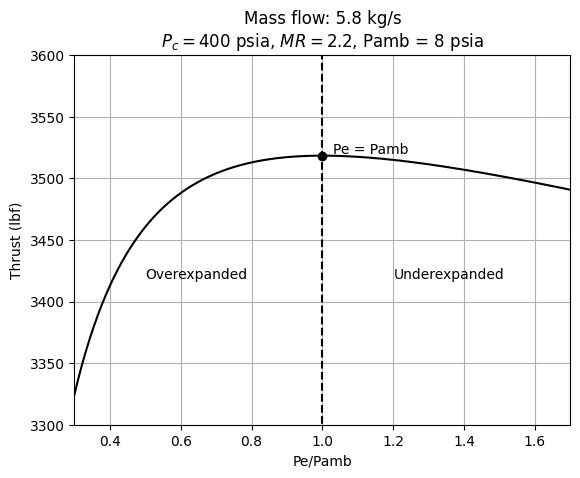

In [118]:
mdot = 5.8 # kg/s
Pc = 400 # psia
MR = 2.2
Pamb = 8 # psia
Pe = np.linspace(1, 19, 600) # psia


T = np.zeros((len(Pe)))
Ve = np.zeros((len(Pe)))
T_p = np.zeros((len(Pe)))
for i in range(len(Pe)):
    epsilon = rocket.get_eps_at_PcOvPe(Pc, MR, Pc/Pe[i], 1, 0)
    _, _, ae = rocket.get_SonicVelocities(Pc, MR, epsilon, 1, 0)
    Me = rocket.get_MachNumber(Pc, MR, epsilon, 1, 0)
    Ve[i] = ae*Me
    _, _, Te = rocket.get_Temperatures(Pc, MR, epsilon, 1, 0)
    mc, _ = rocket.get_exit_MolWt_gamma(Pc, MR, epsilon, 1, 0)
    R = 8314 / mc
    A = R*Te*mdot / (Pe[i] * 6894.76 * Ve[i]) # exit area, psia --> Pa
    T[i] = (mdot*Ve[i] + (Pe[i] - Pamb)*A*6894.76)*0.224809 # N --> lbf
    T_p[i] = (Pe[i] - Pamb)*A*6894.76*0.224809 # pressure thrust

T_m = mdot*Ve*0.224809 # momentum thrust
plt.Figure
plt.plot(Pe/Pamb, T, c= 'k', label = 'Thrust')
plt.grid(True)
plt.ylabel("Thrust (lbf)")
plt.xlabel("Pe/Pamb")
plt.xlim([0.3, 1.7])
plt.ylim([3300, 3600])
ind = abs((Pe - Pamb)).argmin()
plt.scatter(Pe[ind]/Pamb, T[ind], c= 'k', zorder = 3)
plt.annotate("Pe = Pamb", (Pe[ind]/Pamb, T[ind]), 
             (Pe[ind]/Pamb + 0.03, T[ind]+2))
plt.vlines(1, -100000, 100000, colors='k', linestyles='dashed')
plt.annotate(("Overexpanded"), (Pe[ind]/Pamb, T[ind]), 
             (Pe[ind]/Pamb - 0.5, T[ind]-100))
plt.annotate(("Underexpanded"), (Pe[ind]/Pamb, T[ind]), 
             (Pe[ind]/Pamb + 0.2, T[ind]-100))

plt.title(f"Mass flow: {mdot} kg/s\n$P_c = ${Pc} psia, $MR = ${MR}, Pamb = {Pamb} psia");

We should note that increasing $P_e$ is the same as decreasing the nozzle exit area, or shortening the nozzle, and that we are doing this at a constant altitude since $P_{amb}$ is constant. From this graph, we can see that as we vary nozzle size, we get the most thrust at the perfectly expanded case. Moreover, as we decrease nozzle size from the $P_e = P_{amb}$  case, the slope is less than on the other side of the line. To see why, we can isolate the two terms that contribute to thrust and observe each one individually.

In [119]:
plt.Figure
plt.plot(Pe/Pamb, T, c= 'k', label = 'Thrust')
plt.grid(True)
plt.plot(Pe/Pamb, T_m, '--', label= 'Momentum Thrust')
plt.plot(Pe/Pamb, T_p, '--', label='Pressure Thrust')
ind = abs((Pe - Pamb)).argmin()
plt.scatter(Pe[ind]/Pamb, T[ind], c= 'k', zorder = 3)
plt.annotate("Pe = Pamb", (Pe[ind]/Pamb, T[ind]), (Pe[ind]/Pamb + 0.03, T[ind]+100))
plt.ylabel("Thrust (lbf)")
plt.xlabel("Pe/Pamb")
#plt.xlim([0.5, 1.5])
plt.ylim([-1500, 3900])
plt.vlines(1, -100000, 100000, colors='k', linestyles='dashed')
plt.annotate(("Overexpanded"), (1, 100), (0.3, 700))
plt.annotate(("Underexpanded"), (1, 100), (1.25, 700))
plt.legend()

ind1 = abs((Pe - Pamb*0.50)).argmin()
ind2 = abs((Pe - Pamb*1.75)).argmin()
print(f"Underexpanded Side: Momentum Thrust difference for a {(Pe[ind2] - Pe[ind]):.2f} psia Pe difference: {(T_m[ind2] - T_m[ind]):.2f} lbf")
print(f"Underexpanded Side: Pressure Thrust difference for a {(Pe[ind2] - Pe[ind]):.2f} psia Pe difference: {(T_p[ind2] - T_p[ind]):.2f} lbf")
print(f"Overexpanded Side: Momentum Thrust difference for a {(Pe[ind] - Pe[ind1]):.2f} psia Pe difference: {(T_m[ind] - T_m[ind1]):.2f} lbf")
print(f"Overexpanded Side: Pressure Thrust difference for a {(Pe[ind] - Pe[ind1]):.2f} psia Pe difference: {(T_p[ind] - T_p[ind1]):.2f} lbf")
plt.title(f"Mass flow: {mdot} kg/s\n$P_c = ${Pc} psia, $MR = ${MR}, Pamb = {Pamb} psia");

Underexpanded Side: Momentum Thrust difference for a 6.01 psia Pe difference: -182.61 lbf
Underexpanded Side: Pressure Thrust difference for a 6.01 psia Pe difference: 151.86 lbf
Overexpanded Side: Momentum Thrust difference for a 4.00 psia Pe difference: -188.32 lbf
Overexpanded Side: Pressure Thrust difference for a 4.00 psia Pe difference: 245.97 lbf


We readily notice that most of the thrust actually comes from the momentum flux term. On the underexpanded side, we see that momentum thrust term is more sensitive to exit pressure changes while the pressure thrust is more sensitive on the overexpanded side. It seems that the pressure thrust is more sensitive to overexpansion than the momentum thrust is to under expansion. To get a better idea, it would be helpful to view the absolute value of the derivatives of the momentum and pressure thrust curves around the $P_e = P_{amb}$ point.

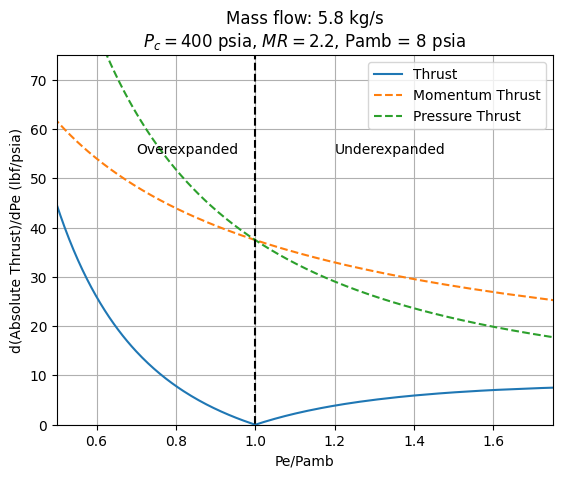

In [120]:
dPe = min(np.diff(Pe))
dTm = np.gradient(T_m, dPe)
dTp = np.gradient(T_p, dPe)
dT = np.gradient(T, dPe)
plt.figure
plt.ylabel("d(Absolute Thrust)/dPe (lbf/psia)")
plt.xlabel("Pe/Pamb")
plt.plot(Pe/Pamb, np.abs(dT), label='Thrust')
plt.plot(Pe/Pamb, np.abs(dTm), '--', label = 'Momentum Thrust')
plt.plot(Pe/Pamb, np.abs(dTp), '--', label = 'Pressure Thrust')
plt.xlim([0.5, 1.75])
plt.ylim([0, 75])
plt.vlines(1, -1000, 1000, colors='k', linestyles='dashed')
plt.grid(True)
plt.annotate(("Overexpanded"), (1, 60), (0.7, 55))
plt.annotate(("Underexpanded"), (1, 60), (1.2, 55))
plt.legend()
plt.title(f"Mass flow: {mdot} kg/s\n$P_c = ${Pc} psia, $MR = ${MR}, Pamb = {Pamb} psia");

We can see that the momentum thrust tends to change more on the underexpanded side and the pressure thrust changes more on the overexpanded side. Using both plots, we can see that the engine is most "efficient" when it is perfectly expanded. That is, we didn't lose any thrust becuase we didn't expanded it enough or we expanded it too much. Keep in mind that this is not the same as the case in which we observed the $I_{sp}$ changes with altitude. In that scenario, the nozzle shape was kept the same as the ambient pressure changed. This means that the most efficient point on our $\tau$ vs $P_e$ curve is not necessarily the point of maximum thrust during flight.

It seems that overall, the momentum thrust term is way less sensitive to changes in nozzle exit area. Moreover, the thrust curve seems to be more "stable" on the underexpanded side, experiencing minimal losses due to nozzle changes. All this is to say, when sizing an nozzle, from the engine perspective, your first priority should be to optimize your $\dot{m}V_e$ thrust. It is less sensitive to exit area changes and will give you a better idea of the overall level of thrust you can produce. The performance loss that you get as you become more underexpanded is the fact that you could've gotten more thrust if you had made your nozzle longer to increase $V_e$.

That being said, how do we choose our exit pressure?

### What should our $P_e$ be and which set of ambient conditions should we use for design?

The answer to the first question is hardly simple and often comes down to a collaborative effort between all of the teams that work to design the vehicle. Sometimes the answer is easier to answer than at other times. For example, if your engine spends most of its time in the upper atmosphere or in space, you'de definitely want to size it so that it's close to perfectly expanded in space. (Perfectly expanded and not overexpanded because you lose some $\dot{m}V_e$ thrust by making the nozzle shorter). The would mean your engine is overexpanded at sea level. Sometimes your engine is operating on a staged vehicle, so it needs to fit in a certain envelope, meaning the nozzle exit area is limited. A lot of the times, your propellant becomes used up even before you reach the underexpanded region of your flight, making those higher thrusts unattainable. Maybe higher thrusts can lead to crazy structural loading at max Q.

To put it short, $P_e$ is determined by a trade studies involving propellant usage, structrual loading, and vehicle size constraints, so for the sake of engine design, we sometimes have to roll with an exit pressure. However, if we are given some freedom, we could examine how the optimal MR is affect by exit pressure.

For YJSP Fullscale sizing, we have been given an exit pressure of 8 psia and thrust of 3500 lbf to begin with. If we design to have 3500 lbf of thrust at sea level, we will require more mass flow rate to hit that thrust due to the effect of ambient back pressure. Therefore, to minimze the amount of propellant we use up, we will size by assuming that we will hit 3500 lbf of thrust when $P_e = P_{amb}$.

Another practical concern when choosing a $P_e$ is the possibility of flow separation.

#### Flow Separation

To understand the effects of flow separation, it's important to understand what occurs when a nozzle is overexanded or underexpanded. I recommend using Professor Seitzman's slides as a refresher: https://www.seitzman.gatech.edu/classes/ae2010/underoverexpanded.pdf

As a brief overview:

- **Underexpanded ($P_e > P_{amb}$):** to match the ambient pressure, the supersonic exhaust gases form Prandtl-Meyer Expansion waves

- **Overexpanded ($P_e < P_{amb}$):** to match the ambient pressure, the supersonic exhaust gases form Oblique Shock waves.

Both of these phenomena are repsonsible for the generation of *Mach Diamonds*, which is why we see them during HETS testing at sea level. In the case overexpansion, it's very possible that a shock wave, due to the extreme pressure difference between the pressure inside the nozzle and the ambient pressure, is pushed into the nozzle. This can be disasterous for a nozzle for two main reasons:



1.   The sudden increase in pressure due to shock wave compression can create unfavorable structural loading mechanically and thermally
2.   Since oblique shocks redirect the flow towards the radial center of the nozzle, they effectively reduce the exit area of the nozzle, reducing the thrust.

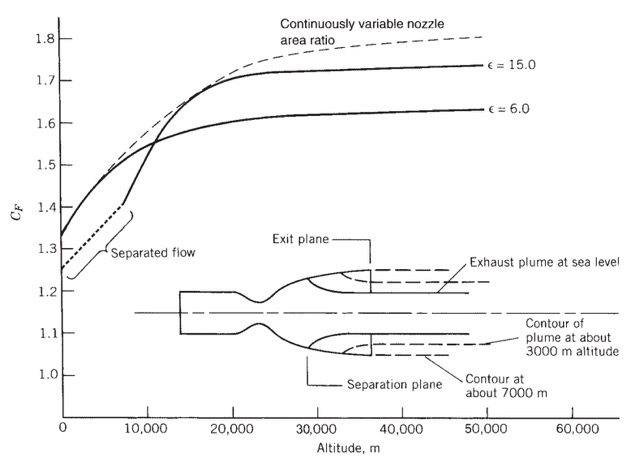

Predicting when flow separation occurs is not a simple as just seeing when $P_e < P_{amb}$, otherwise all overepxanded nozzles would separate. This is because of the *momentum boundary layer* that runs along the nozzle wall, a region of decreasing axial velocity due to friction between the flow gases and the nozzle wall. Therefore, the pressure in the boundary layer, being a non-isentropic flow, is not necessarily the same as that of the core flow. When a shock forms in the nozzle, the large adverse pressure gradient can cause the boundary layer to "detach" from the wall, redirecting the flow to the nozzle's centerline. Some of the flow will actually start to flow backwards since the high post-shock pressure acts almost like a wall. These two phenomena will greatly reduce the thrust. Flow separation during startup can cause very uneven pressure distributions along the engine walls, creating what are called *sideloads*, which can be disastrous during launch operations.

Being closer to formation of the oblique shocks, boundary layers are often the determining factor flow separation, but are also very difficult to model analytically. So, during preliminiary engine sizing, we can use a few a rules of thumb to figure out if our core flow exit pressure is low enough to cause separation.

The most common one is *Summerfield's criteria*:

$P_{amb} \ge (2.5)P_e$

Other common criteria include:

1. Schilling's critera: $\frac{P_e}{P_{amb}} = 0.583\left(\frac{P_c}{P_{amb}}\right)^{-0.195}$
2. Kate-Bendall criteria: $\frac{P_e}{P_{amb}} = \frac{2}{3}\left(\frac{P_c}{P_{amb}}\right)^{-0.2}$

Based on Summerfield's criteria, an exit pressure of 8 psia is well within the safe region: the highest ambient pressure we would ever get is 14.67 psia.

# Optimal MR vs Chamber Pressure

### Equilibrium or Frozen?

So far, in essentially every bit of code, I've used the assumption that the flow is fully frozen. These were the *1* and *0* in lines of code like *Isp[i], _ = rocket.estimate_Ambient_Isp(Pc, MR, epsilon, float(P), frozen=1, frozenAtThroat=0)* So what does frozen flow mean? What is shifting equilibrium flow?

As a refresher, thermodynamic equilibrium is when a given amount of substance does not appear to have any internal potentials that would cause the properties to shift over time. That means once a substance is at equilibrium, it wants to stay that way. When there are pressure or temperature differences within a fluid, the fluid will either exhibit bulk or molecular movement to reach equilibrium. This is why even though the flow inside a rocket engine is steady, it is not in thermodynamic equilibrium: there are pressure, temperature, AND chemical composition differences forcing the fluid to move from the chamber to the exit. However, if we isolate a tiny sliver of the gas flow, we can approimxate that differential fluid element as having a single pressure, temperature, and composition. Hence, equilibrium statistical mechanics and kinetics work in finding the approximate pressure, temperature, and chemical composition after the propellants react. This is exactly what CEA does.

With equilibrium flow, every differential element of the flow reaches an equilibrium chemical composition in accordance with the pressure and temperature of that element. With frozen flow, the propellants reach equilibrium on the theoretical injector face and then keep that chemical composition all the way through to the exit.

Choosing between equilibrium and frozen conditions is largely dependent on the chemical kinetics of the propellants that are chosen. The idea of reaction timescales plays a huge role in the shape of our nozzle. The speed at which the propellants react relative to how fast the propellants are flowing will inform the length and width of our chamber and converging section.

Some propellants (e.g. LH2/LOX) readily combine and therefore require relatively less time to react before being accelerated in the converging section. Other, bulkier propellants (e.g. RP-1/LOX) require more time in the chamber before being accelerated. This required *stay-time* of the propellants changes the required $L^*$. Moreover, if a combination of propellants requires fewer intermediate steps to combine and recombine, it is more likely to reach equilibrium *at each point along the nozzle*. This means that as the gases are flowing, some of the products will combine to form reactants again, regardless of how fast the bulk fluid motion is. In the opposite case, propellants whose reactions (*rate-limiting* reactions in particular) occur on longer timescales will tend to not recombine since they simply don't have enough time in the nozzle to do so. These types of propellants will be better modeled by **frozen** flow, especially for a smaller rocket engine like YJSP's. To be clear, there are different types of frozen flow. In general, frozen flow just means that some degree of freedom that existed in equilibrium flow no longer participates in the reactions. Sometimes that means the molecular compostion does not contribute to energy transfers, allowing only translation, rotation, and vibration to transfer momentum and energy. Other times, the vibrations of the molecules don't play a role in the reactions. The first step of most analysis processes is to examine the contribution of *chemically frozen* flow, which is was what CEA does.

For more information about this, I suggest reading Chapter 12.4 *NONEQUILIBRIUM EXPANSION* of **Mechanics and Thermodynamics of Propulsion, 2nd Edition** by Philip Hill and Carl Peterson

jp4.jpeg

(JP-4 is an aviation-type kerosene similar to RP-1)

In reality, the flow is a mix of equilibrium and frozen with it, in general, tending from equilibrium to frozen from the chamber to the exit. This makes sense as the propellants do not have time to fully combine as the flow speeds up. There is one major benefit to assuming frozen or equilibrium for any section of the flow. From *Physical Gas Dynamics*, we see that for equilibrium and frozen flow, "we recover again the classical result that the change in velocity depends only on the net change in area ... Only in the two limits, however, does this simple result hold true... Because of the dependence of the nonequilibrium flow on its entire past history, it is not possible to find the mass flow in the supercritical case by proceeding at once to the throat, as can be done in equilibrium or frozen flow" (Vincenti, Kruger). Because neither equilibrium nor frozen flow sections depends on the flow that came before them in the nozzle, they can be modeled as entirely isentropic. This greatly simplifies our preliminary analysis.

Additionally, we should note that equilibrium flow represents the flow system with the greatest amount of energy release. This is because for a single temperature and pressure at a given axial station along the engine, when equilibrium is allowed, the species with the lowest enthalpies of formation will be the ones that tend to form, so more chemical energy can be extracted from molecular bonds into thermal energy. However, when the composition is enforced as frozen, the species will exist even if certain species would not form that $T$ and $p$. As a result, for a given set of engine parameters, the more equilibrium the flow, the higher the efficiency. This effect is called *kinetics efficiency* and is further discussed in the **Efficiencies** section.


Finding the exact characteristics of the flow would require complex kinetics calculations, which are usually done by **TDK (Two-dimensional kinetics)** (which is the JANNAF standard) or other softwares like RPA (Rocket Propulsion Analysis) or ANSYS Chemkin. These are expensive softwares and I'd rather not drop money on them so we will stick to CEA, which is more than accurate enough for the engines we build. CEA provides a few "combined" shfiting equilibrium and frozen composition models which are of interest:
- **Fully equilibrium**
- **NFZ = 1**: Frozen from the chamber
- **NFZ = 2**: Equilibrium up to the throat and frozen from the throat

(by the way NFZ stands for Nozzle Frozen Zone)

Instead of resorting to kinetics calculations, the best option is to compare with literature and historical data. Mechanics and Thermodynamics of Propulsion implies, "It is typical for freezing not to occur upstream of the throat; Timnat suggests that as a rough approximation one might assume shifting equilibrium to the throat, and frozen composition thereafter"(580). This backs up the claim that RP-1/LOX is better modeled by a non-equilibrium approach, but the statement itself is quite vague and could apply to engines of any size. The following website:

http://www.braeunig.us/space/comb.htm

provides a chart of optimal mixture ratio as a function of chamber pressure for $P_e = 0.1$ atm and $1$ atm. I have taken the data and converted it into psi so that it is easier to compare with.



### Load Propellant Chart Data

In [121]:
# Pc vs MR for 1 atm
Pc_MR_1 = np.array([
    [7.125468646160279, 2.100554009728027],
    [8.53779257080489, 2.1093292630446165],
    [9.560093571825284, 2.11876277846918],
    [10.325966311485764, 2.1263753120336464],
    [11.35115442701482, 2.133989945317755],
    [12.376867472454542, 2.141273872758145],
    [13.659621197483304, 2.149992958574293],
    [15.200815415196217, 2.1592653205162824],
    [16.743759399278012, 2.1674353296458753],
    [18.287053336633583, 2.1753848682129884],
    [19.960829851783075, 2.182815776028364],
    [21.764489024828563, 2.190106002627682],
    [23.696456066038053, 2.1982476655420986],
    [25.758905685041483, 2.205870697704778],
    [27.951129643070445, 2.213421289539786],
    [30.532618292630445, 2.2207913054855246],
    [33.37353896915029, 2.228089930963413],
    [36.214459645670146, 2.2353885564413014],
    [39.055762089397746, 2.242446668578303],
    [41.89830527655056, 2.2487231123574234],
    [44.74137339361404, 2.254668850292825],
    [47.585348207795946, 2.2600433690436206],
    [50.43056376540305, 2.264636219436535],
    [53.27558843940628, 2.2693493264998925],
    [56.12037450890466, 2.2742127544013044],
    [58.96511285750208, 2.279106246470327],
    [61.81028069420822, 2.283729161030852],
    [64.6566415534386, 2.2876004714011065],
    [67.50262064546122, 2.291712295112248],
    [70.34859973748384, 2.295824118823389],
    [73.19429250410064, 2.300116327540195],
    [76.04060564243005, 2.3040177020780606],
    [78.88839812868952, 2.3069870874199903],
    [81.73504531332571, 2.31067801278458],
    [84.58245603237744, 2.3138879114673965],
    [87.42948498422139, 2.3173383234910996],
    [90.27732519138182, 2.3202776446654187],
    [93.12502223583935, 2.3233071583425704],
    [95.972528396693, 2.326456928690165],
    [98.82041632475439, 2.3293661856968733],
    [101.66868602002357, 2.332034929362695],
    [104.51733748250048, 2.33446315968763],
    [107.36594122407642, 2.336921454180176],
    [110.2144972447514, 2.3394098128403327],
    [113.06310098632737, 2.3418681073328784],
    [115.91175244880425, 2.3442963376578136],
    [118.76073795758798, 2.346514118809473],
    [121.60962802456974, 2.348792028296354],
    [124.45823176614569, 2.3512503227889],
    [127.3070263913255, 2.3535883606110026],
    [130.15672771362375, 2.3553551792484995],
    [133.00595182691228, 2.3574226395621047],
    [135.85493733569604, 2.359640420713764],
    [138.70349335637098, 2.3621287793739207],
    [141.5540059339857, 2.3633845071620336],
    [144.4032300472743, 2.365451967475639],
    [147.25264504416674, 2.367399171118801],
    [150.10244180826692, 2.369105861421076],
    [152.95262033957482, 2.370572038382465],
    [155.80260798727892, 2.372158472014297],
    [158.65164121696358, 2.3743461889983455],
    [161.5012470974599, 2.3761731359710643],
    [164.35028032714456, 2.3783608529551126],
    [167.20007709124474, 2.380067543257388],
    [170.05063738976048, 2.3812932068778903],
    [172.9015794554839, 2.3822783571575057],
    [175.7513284986831, 2.384015111627392],
    [178.60136386728817, 2.3855714810916133],
    [181.45077886418062, 2.387518684734775],
    [184.30095739548852, 2.388984861696164],
    [187.1507541595887, 2.3906915519984393],
    [190.00093269089666, 2.392157728959828],
    [192.85106350130366, 2.3936539700888275],
    [195.70114659080969, 2.395180275385438],
    [198.55127740121662, 2.3966765165144377],
    [201.4018376997323, 2.39790218013494],
    [204.25230255644607, 2.3991879720906635],
    [207.10281513406085, 2.400443699878777],
    [209.95327999077455, 2.4017294918345007],
    [212.80388801019126, 2.4029250912873916],
    [215.65449602960797, 2.404120690740283],
    [218.5050563281236, 2.4053463543607854],
    [221.35556890573838, 2.4066020821488983],
    [224.20617692515503, 2.4077976816017896],
    [227.05668950276976, 2.4090534093899025],
    [229.90724980128545, 2.410279073010405],
    [232.75781009980113, 2.4115047366309073],
    [235.60837039831688, 2.412730400251409],
    [238.45893069683257, 2.4139560638719115],
    [241.30968187895212, 2.4150614708219704],
    [244.1602421774678, 2.4162871344424723],
    [247.01080247598355, 2.4175127980629747],
    [249.21421963645105, 2.4180116723617107]])

# Pc vs MR for 0.1 atm
Pc_MR_01 = np.array([
    [7.097559872576575, 2.1453650015052323],
    [8.466467719193261, 2.1542639195599427],
    [9.488703103974828, 2.163738773214971],
    [10.341189278895051, 2.171241771404745],
    [11.278189169432359, 2.1799580575947033],
    [12.303377284961414, 2.187572690878812],
    [13.457698158514106, 2.195519079866461],
    [14.741886691965355, 2.203334236376444],
    [16.155487946059253, 2.2113047721399837],
    [17.6991318366886, 2.2190338401446175],
    [19.5012162200021, 2.2273161842750926],
    [21.563140909094855, 2.235269922281491],
    [23.625131214426432, 2.2431823220574247],
    [25.946410649131067, 2.251113356845187],
    [28.267545728110278, 2.259135335739972],
    [30.719493340827242, 2.266430811638396],
    [33.561750202574245, 2.2728876404231815],
    [36.4034344135096, 2.2797052392192967],
    [39.24492774084109, 2.2866430946858554],
    [42.08742320709294, 2.2929496026325866],
    [44.93044360325544, 2.2989254047355985],
    [47.77451385923928, 2.304239795151173],
    [50.62001574225221, 2.3086522605384223],
    [53.464849532651556, 2.3134856242722233],
    [56.31025597386255, 2.3179582179946943],
    [59.156187344984204, 2.3221001058734463],
    [62.00188011160101, 2.3263923145902523],
    [64.84814552902945, 2.3303237532957284],
    [67.69422006285401, 2.334375448671648],
    [70.54010371307469, 2.338547400718011],
    [73.38598736329537, 2.3427193527643735],
    [76.23230050162478, 2.346620727302239],
    [79.07990210428036, 2.349710369314612],
    [81.92678789342142, 2.353250973841148],
    [84.77410317067121, 2.356521000859186],
    [87.62156161062386, 2.3597008353743916],
    [90.46944953868528, 2.3626100923810998],
    [93.31771923395443, 2.3652788360469215],
    [96.16598892922362, 2.367947579712743],
    [99.01387685728498, 2.3708568367194514],
    [101.86252831976192, 2.3732850670443866],
    [104.71117978223883, 2.3757132973693214],
    [107.55983124471577, 2.3781415276942566],
    [110.40843498629168, 2.3805998221868023],
    [113.25699100696669, 2.3830881808469595],
    [116.10559474854263, 2.3855464753395053],
    [118.95462797822732, 2.3877341923235536],
    [121.80361348701099, 2.3899519734752133],
    [124.652169507686, 2.3924403321353696],
    [127.50077324926194, 2.3948986266279157],
    [130.350760896966, 2.3964850602597476],
    [133.1997464057497, 2.398702841411407],
    [136.04877963543436, 2.4008905583954556],
    [138.89752653971323, 2.403258660385169],
    [141.74808683822891, 2.4044843240056712],
    [144.5970723470126, 2.4067021051573305],
    [147.44667822750893, 2.4085290521300493],
    [150.2964749916091, 2.4102357424323246],
    [153.14665352291706, 2.4117019193937135],
    [155.99645028701724, 2.413408609695989],
    [158.84567440030582, 2.4154760700095936],
    [161.69542344350504, 2.41721282447948],
    [164.54569741661493, 2.4186188731056473],
    [167.39582822702187, 2.4201151142346466],
    [170.24581587472596, 2.421701547866479],
    [173.09561263882614, 2.4234082381687543],
    [175.9457911701341, 2.4248744151301427],
    [178.795969701442, 2.4263405920915315],
    [181.64652999995775, 2.427566255712034],
    [184.49670853126565, 2.4290324326734227],
    [187.34688706257361, 2.430498609634811],
    [190.1970178729806, 2.431994850763811],
    [193.04710096248658, 2.4335211560604213],
    [195.89723177289358, 2.435017397189421],
    [198.74741030420154, 2.4364835741508095],
    [201.59758883550944, 2.4379497511121984],
    [204.4481491340252, 2.4391754147327007],
    [207.2983276653331, 2.4406415916940896],
    [210.14850619664105, 2.442107768655478],
    [212.9990664951568, 2.4433334322759803],
    [215.8492450264647, 2.444799609237369],
    [218.69942355777266, 2.446265786198758],
    [221.54998385628835, 2.44749144981926],
    [224.40021010849728, 2.448927562613038],
    [227.25067496521098, 2.4502133545687617],
    [230.10123526372672, 2.451439018189264],
    [232.95184328314338, 2.4526346176421554],
    [235.8024513025601, 2.453830217095047],
    [238.65315476377862, 2.454965688212716],
    [241.50376278319533, 2.4561612876656076],
    [244.35427536081005, 2.457417015453721],
    [247.2048356593258, 2.458642679074223],
    [249.27878601546286, 2.459020246842694]])

### Optimum Mixture Ratio as a function of $P_c$

In [122]:
plt.figure
plt.plot(Pc_MR_1[:, 0]*14.696, Pc_MR_1[:, 1]) # convert to psia
plt.plot(Pc_MR_01[:, 0]*14.696, Pc_MR_01[:, 1])#  convert to psia
plt.xlabel("Chamber Pressure (psia)")
plt.ylabel("Optimal Mixture Ratio")
plt.title("Mixture Ratio (Optimzed for Isp) vs Chamber Pressure")
plt.xlim([100, 500])
plt.ylim([2.05, 2.3])
plt.grid(True)
plt.legend(("14.696 psia", "1.4696 psia"));

Assuming the flow is a fully shifting equilibrium flow, the CEA comparison data can be plotted. **WARNING** this code could take forever depending on how many $MR$ s and $P_c$ s you choose to iterate over.

Going forward, please keep in mind that for each $P_c$ value that the computer is iterating over, it needs to run CEA for every single $MR$ value and then find the best one. CEA, while it seems fast, still needs to iterate over several temperature conditions to solve the conservation of energy equation. This means that the following programs are running in at least $\mathcal{O}(n^3)$ time, so they can be pretty slow. To speed things up, we can use a technique that's very common in combustion modeling and finite-element analysis: **parallelization**.

Parallelization requires multiple processors, so before running this bit of code, I would recommend checking how many processors your computer has. **DON'T** use all of your processors to avoid stalling your computers.

In [123]:
number_of_processors = 2

### Fully Equilibrium

Ignore the errors in the output of the following cell. (takes about 1 minute to run with 300 points each)

In [124]:
Pc = np.linspace(100, 500, 300)
MR = np.linspace(2, 4, 300)
Pe = np.array([14.696, 1.4696])
frozen = 0 # 0 is full equilibrium, 1 is frozen
frozenAtThroat = 0 # 0 is nfz = 1, 1 is nfz = 2

with multiprocessing.Pool(processes=number_of_processors) as pool:
    best_MR = np.zeros((2, len(Pc)))
    for j, pe in enumerate(Pe):
        for i, pc in enumerate(Pc):
            Isp_arr = pool.starmap(rocket.estimate_Ambient_Isp, 
                                   [(pc, m, rocket.get_eps_at_PcOvPe(pc, m, pc / pe, frozen=frozen, frozenAtThroat=frozenAtThroat), pe, frozen, frozenAtThroat) for m in MR])
            Isp = [isp for isp, exp in Isp_arr]
            best_MR[j, i] = MR[np.argmax(Isp)]
plt.figure

plt.plot(Pc_MR_1[:, 0]*14.696, Pc_MR_1[:, 1])
plt.plot(Pc_MR_01[:, 0]*14.696, Pc_MR_01[:, 1])
plt.xlabel("Chamber Pressure (psia)")
plt.ylabel("Optimal Mixture Ratio")
plt.title("Mixture Ratio (Optimzed for Isp) vs Chamber Pressure\nEquilibrium Test")
plt.xlim([100, 500])
plt.ylim([2.05, 2.75])
plt.grid(True)

plt.plot(Pc, best_MR[0, :], c='k')
plt.plot(Pc, best_MR[1, :], c='k')
plt.legend(("14.696 psia", "1.4696 psia", "14.696 Equil.", "1.4696 Equil."));

ERROR reading data file forERROR reading data file for  LOX / RP_1LOX / RP_1



Clearly equilibrium does a horrible job approximating the plots. Next we will try frozen starting at the chamber.

### $NFZ = 1$, Frozen from Chamber

In [125]:
Pc = np.linspace(100, 500, 300)
MR = np.linspace(2, 4, 300)
Pe = np.array([14.696, 1.4696])
frozen = 1 # 0 is full equilibrium, 1 is frozen
frozenAtThroat = 0 # 0 is nfz = 1, 1 is nfz = 2

with multiprocessing.Pool(processes=number_of_processors) as pool:
    best_MR = np.zeros((2, len(Pc)))
    for j, pe in enumerate(Pe):
        for i, pc in enumerate(Pc):
            Isp_arr = pool.starmap(rocket.estimate_Ambient_Isp, [(pc, m, rocket.get_eps_at_PcOvPe(pc, m, pc / pe, frozen=frozen, frozenAtThroat=frozenAtThroat), pe, frozen, frozenAtThroat) for m in MR])
            Isp = [isp for isp, exp in Isp_arr]
            best_MR[j, i] = MR[np.argmax(Isp)]
plt.figure

plt.plot(Pc_MR_1[:, 0]*14.696, Pc_MR_1[:, 1])
plt.plot(Pc_MR_01[:, 0]*14.696, Pc_MR_01[:, 1])
plt.xlabel("Chamber Pressure (psia)")
plt.ylabel("Optimal Mixture Ratio")
plt.title("Mixture Ratio (Optimzed for Isp) vs Chamber Pressure\nEquilibrium Test")
plt.xlim([100, 500])
plt.ylim([2.05, 2.3])
plt.grid(True)

plt.plot(Pc, best_MR[0, :], c='k')
plt.plot(Pc, best_MR[1, :], c='k')
plt.legend(("14.696 psia", "1.4696 psia", "14.696 NFZ = 1", "1.4696 NFZ = 1"));

ERROR reading data file forERROR reading data file for  LOX / RP_1LOX / RP_1



This is certainly better but not there yet. We will now try modeling the flow as frozen from the throat but equilibrium before the throat.

### $NFZ = 2$, Frozen from the Throat

ERROR reading data file for LOX / RP_1ERROR reading data file for
 LOX / RP_1


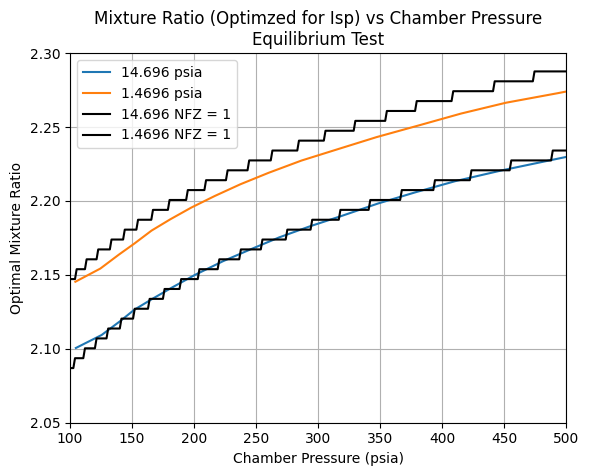

In [126]:
Pc = np.linspace(100, 500, 300)
MR = np.linspace(2, 4, 300)
Pe = np.array([14.696, 1.4696])
frozen = 1 # 0 is full equilibrium, 1 is frozen
frozenAtThroat = 1 # 0 is nfz = 1, 1 is nfz = 2

with multiprocessing.Pool(processes=number_of_processors) as pool:
    best_MR = np.zeros((2, len(Pc)))
    for j, pe in enumerate(Pe):
        for i, pc in enumerate(Pc):
            Isp_arr = pool.starmap(rocket.estimate_Ambient_Isp, [(pc, m, rocket.get_eps_at_PcOvPe(pc, m, pc / pe, frozen=frozen, frozenAtThroat=frozenAtThroat), pe, frozen, frozenAtThroat) for m in MR])
            Isp = [isp for isp, exp in Isp_arr]
            best_MR[j, i] = MR[np.argmax(Isp)]
plt.figure

plt.plot(Pc_MR_1[:, 0]*14.696, Pc_MR_1[:, 1])
plt.plot(Pc_MR_01[:, 0]*14.696, Pc_MR_01[:, 1])
plt.xlabel("Chamber Pressure (psia)")
plt.ylabel("Optimal Mixture Ratio")
plt.title("Mixture Ratio (Optimzed for Isp) vs Chamber Pressure\nEquilibrium Test")
plt.xlim([100, 500])
plt.ylim([2.05, 2.3])
plt.grid(True)

plt.plot(Pc, best_MR[0, :], c='k')
plt.plot(Pc, best_MR[1, :], c='k')
plt.legend(("14.696 psia", "1.4696 psia", "14.696 NFZ = 1", "1.4696 NFZ = 1"));

Clearly, while it's not a perfect fit, NFZ = 2 does the best job predicting the flow characteristics of RP-1/LOX. The variations in the data are likely due to different modeling techniques (finite area combustor, kinetics losses, etc.). This modeling tells us a few important things:
1) The optimal $MR$ is **DEFINITELY** dependent on chamber pressure AND exit pressure. (The optimal $MR$ increases with chamber pressure and decerases with exit pressure)
2) Even for reactions that occur with long timescales, NFZ = 2 is a good approximation.
3) External effects (finite area combustion, for example) should be taken into account for an accurate model
4) It is important to also compare to historical test data

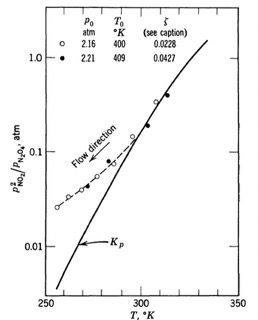

This conclusion is supported by the data presented in Figures 16 and 17 in *Physical Gas Dynamics*. We see that as the flow progresses, the composition diverges from the partial pressures predicted by the equilibrium constant, confirming that it tends towards frozen. This approximation that the flow becomes instantly frozen at the throat is called the *sudden-freezing* assumption. As described in the paper, *Evaluation of the Bray Sudden-Freezing Criterion for Predicting Nonequilibrium Performance in Multireaction Rocket Nozzle Expansions*, "The analyses described in this paper have shown that the sudden-freezing concept is useful for estimating the chemical nonequilibrium performance of advanced liquid propellant rocket engines. However, the single-reaction Bray criterion has limited applicability, and its use is justified only after extensive evaluation of the kinetics of the recombination mechanisms for particular propellant systems has been made using an exact kinetic-flow model and it has been established that a single reaction is rate-controlling. When this is not the case, the single-reaction Bray criterion can at best bracket the actual nonequilibrium nozzle performance by assuming that the fastest and the slowest of the many recombination reactions is rate-controlling" (Sarli et al.). This means that, in general, the sudden-freezing approximation is a good starting point for testing. Moreover, the sudden-freezing and equilibrium analyses can be used as lower and upper bounds for the theoretical performance. 

Keep in mind that the sudden-freezing point is not necessarily always the throat. While Vincent and Kruger do state that, "The suddenness of the freezing process...suggests an approximate model in which the freezing is assumed to take place instantaneously from the equilibrium flow at an appropriate point in the nozzle", they also elaborate that the freezing point can be approximated using Bray's criteria. These means that certain propellants will tend to freeze earlier in the nozzle than others. Unfortunately, CEA only provides a single sudden-freezing point for analysis, the throat, which is nfz = 2.

Therefore, for the rest of this notebook, I will assume nfz=2: sudden-freezing.

In the following sections, I will go into more detail regarding engine-side effects that affect the our choice of parameters and eventually compare to historical data and YJSP test data to make a fully informed decision for YJSP's fullscale engine parameters.

For now, let's do a preliminary selection of our mixture ratio.

# Preliminary $MR$ Selection

With all the tools we have gathered, let's figure an $MR$ to start sizing with before we get into more advanced considerations. We already know that nfz = 2 will give us a more realistic $I_{sp}$ for our engine, but we can plot equilibrium and nfz = 1 just to compare.

Let's use the following parameters for our Fullscale Engine:

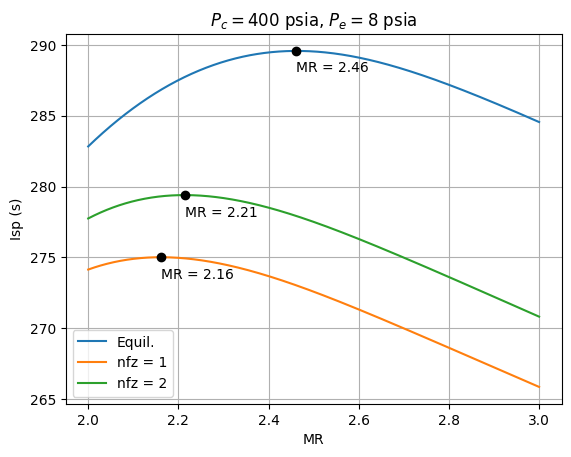

In [127]:
T = 3500 # lbf
Pc = 400 #psia
Pe = 8 # psia

MR = np.linspace(2, 3, 800)
Isp = np.zeros((3, len(MR)))
for i, mc in enumerate(MR):
    eps_eq = rocket.get_eps_at_PcOvPe(Pc, mc, Pc/Pe)
    eps_1 = rocket.get_eps_at_PcOvPe(Pc, mc, Pc/Pe, 1)
    eps_2 = rocket.get_eps_at_PcOvPe(Pc, mc, Pc/Pe, 1, 1)
    Isp[0, i], _ = rocket.estimate_Ambient_Isp(Pc, mc, eps_eq, Pe)
    Isp[1, i], _ = rocket.estimate_Ambient_Isp(Pc, mc, eps_eq, Pe, 1)
    Isp[2, i], _ = rocket.estimate_Ambient_Isp(Pc, mc, eps_eq, Pe, 1, 1)

plt.Figure
plt.plot(MR, Isp[0, :], label = "Equil.")
plt.plot(MR, Isp[1, :], label = "nfz = 1")
plt.plot(MR, Isp[2, :], label = "nfz = 2")
plt.grid(True)
plt.ylabel("Isp (s)")
plt.xlabel("MR")
plt.legend()
inds = np.argmax(Isp, 1)
plt.scatter(MR[inds], np.diag(Isp[:, inds]), c = 'k', zorder = 3)
for i in range(len(inds)):
    plt.annotate((f"MR = {(MR[inds[i]]):.2f}"), 
                 (MR[inds[i]], Isp[i, inds[i]]), 
                 (MR[inds[i]], Isp[i, inds[i]] -1.5))

plt.title(f"$P_c = ${Pc} psia, $P_e = ${Pe} psia");

We can see that the nfz = 2 optimal $MR$ is much less than that of equilibrium. This is great news for the manufacturability of our TCA: if you recall from the *Adiabatic Flame Temperature* section, a lower MR on the fuel rich side of the $T_{ad}$ curve provides a lower $T_c$, meaning our engine walls will be a lot easier to cool

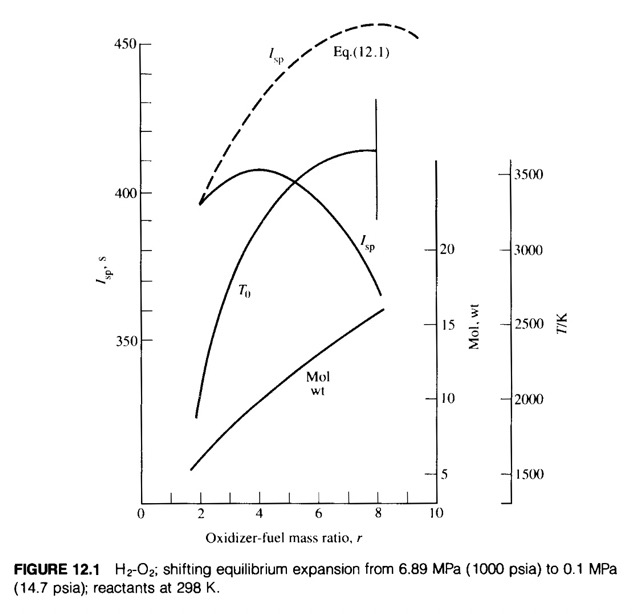

We see that *Mechanics and Thermodynamics of Propulsion* provides a similar plot for frozen vs equilibrium $I_{sp}$

Let's also observe how the optimal $MR$ would change based on the ambient conditions we choose to design to. This is **NOT** the same as when we compared optimal $MR$ to $P_e$. We will plot equilibrium and nfz = 2 to compare.

In [128]:
Pamb = np.linspace(1, 15, 25) # psia
MR = np.linspace(2, 3, 400)
best_MR = np.zeros((2, len(Pamb)))
for i, p in enumerate(Pamb):
    Isp_eq = np.zeros((len(MR)))
    Isp_2 = np.zeros((len(MR)))
    for j, mc in enumerate(MR):
        eps_eq = rocket.get_eps_at_PcOvPe(Pc, mc, Pc/Pe)
        eps_2 = rocket.get_eps_at_PcOvPe(Pc, mc, Pc/Pe, 1, 1)
        Isp_eq[j], _ = rocket.estimate_Ambient_Isp(Pc, mc, eps_eq, p)
        Isp_2[j], _ = rocket.estimate_Ambient_Isp(Pc, mc, eps_2, p, 1, 1)
    ind_eq = np.argmax(Isp_eq)
    ind_2 = np.argmax(Isp_2)
    best_MR[0, i] = MR[ind_eq]
    best_MR[1, i] = MR[ind_2]

plt.figure
plt.plot(Pamb, best_MR[0, :], label = "Equil.")
plt.plot(Pamb, best_MR[1, :], label = "nfz = 2")
plt.grid(True)
plt.xlabel("Ambient Pressure (psia)")
plt.ylabel("Optimal Mixture Ratio")
plt.legend()

plt.title(f"$P_c = ${Pc} psia, $P_e = ${Pe} psia");

We see that depending on the ambient pressure that we design to, the MR we choose we choose actually changes: the higher the ambient pressure, the lower the mixture ratio we want to get the optimal $I_{sp}$. 

Also notice that for the nfz = 2 case, the optimal $MR$ is approximately 2.23 at an ambient pressure of 8 psia, which is the perfectly expanded case.

Why is this? Let's see how $V_e$ changes with $MR$ for the nfz = 2 case to give context.

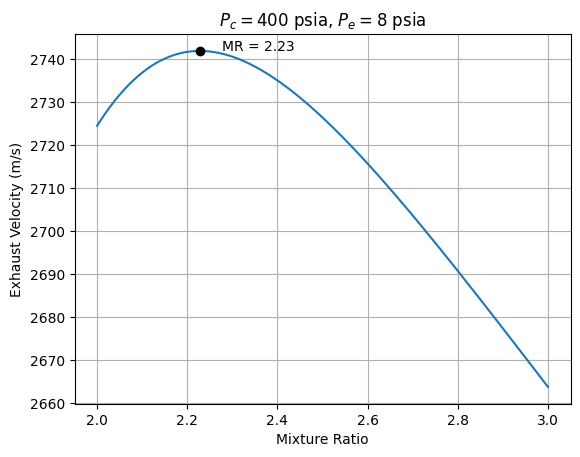

In [129]:
MR = np.linspace(2, 3, 400)
Ve = np.zeros(len(MR))
for i, mc in enumerate(MR):
        eps = rocket.get_eps_at_PcOvPe(Pc, mc, Pc/Pe, 1, 1)
        _, _, ae = rocket.get_SonicVelocities(Pc, mc, eps, 1, 1)
        Me = rocket.get_MachNumber(Pc, mc, eps, 1, 1)
        Ve[i] = ae*Me

plt.Figure
plt.plot(MR, Ve)
plt.grid(True)
plt.xlabel('Mixture Ratio')
plt.ylabel('Exhaust Velocity (m/s)')
ind = np.argmax(Ve)
plt.scatter(MR[ind], Ve[ind], c = 'k', zorder = 3)
plt.annotate(f"MR = {(MR[ind]):.2f}", (MR[ind], Ve[ind]), 
             (MR[ind] + 0.05, Ve[ind]))

plt.title(f"$P_c = ${Pc} psia, $P_e = ${Pe} psia");

Let's break this down in terms of cause and effect.

Cause: $P_{amb}$ $\uparrow$

Effect: Required $MR$ $\downarrow$

Why? First, let's makes sure we understand why this case is different from how we observed changing $I_{sp}$ with $P_{amb}$ before: in that scenario, we fixed $MR$, so this a different situation. We see that in this case, as $MR$ decerases in the region we care about, $I_{sp}$ and $V_e$ increase slighlty. This means that we are requiring a higher thrust per mass flow rate. Therefore, as the ambient pressure is going up, we need a higher $\tau$ to maintain the same $P_e$. How is this being accomplished? By marginally decreasing the $MR$! Why is this increasing performance? If you remember from the *Specific Heat and Exhaust Molecular Weight Section*, $MW$ actually *decreased* with $MR$, so the exhaust molecules will have a higher velocity. All this goes to show that just because increasing $MR$ gives higher chamber temperature doesn't mean we're getting more efficient.

Finally, let's settle on a preliminary $MR$ and derive some of the engine's operating conditions from it:

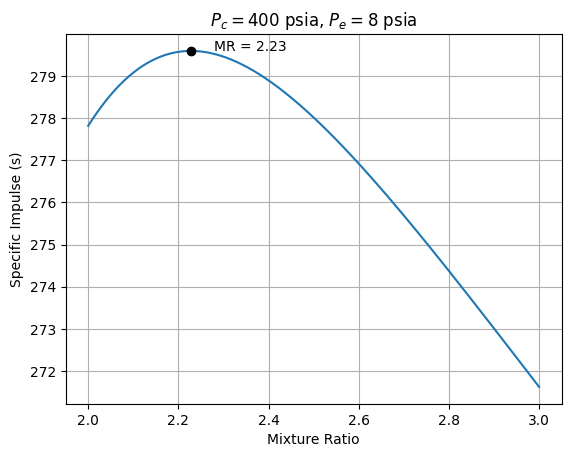

In [130]:
MR = np.linspace(2, 3, 400)
Isp = np.zeros(len(MR))
for i, mc in enumerate(MR):
    eps = rocket.get_eps_at_PcOvPe(Pc, mc, Pc/Pe, 1, 1)
    Isp[i], _ = rocket.estimate_Ambient_Isp(Pc, mc, eps, Pe, 1, 1)

plt.Figure
plt.plot(MR, Isp)
plt.grid(True)
plt.xlabel("Mixture Ratio")
plt.ylabel('Specific Impulse (s)')
ind = np.argmax(Isp)
plt.scatter(MR[ind], Isp[ind], c='k', zorder = 3)
plt.annotate(f"MR = {(MR[ind]):.2f}", (MR[ind], Isp[ind]), 
             (MR[ind] +0.05, Isp[ind]))

plt.title(f"$P_c = ${Pc} psia, $P_e = ${Pe} psia");

$MR = 2.23$ seems like a chill number to start with. Let's find the throat area and necessary mass flow rates. We've managed to get $C^*_{eff} \approx 91%$ with Vespula, so let's include that in our calculations.

In [131]:
MR = 2.23
cstar_eff = 0.91
eps = rocket.get_eps_at_PcOvPe(Pc, MR, Pc/Pe, 1, 1)
_, _, ae = rocket.get_SonicVelocities(Pc, MR, eps, 1, 1)
Me = rocket.get_MachNumber(Pc, MR, eps, 1, 1)
Ve = ae*Me*cstar_eff # m/s

mdot = (T*4.44822)/Ve # kg/s

mdot_fuel = (1/(MR+1))*mdot
mdot_ox = (MR/(MR+1))*mdot

_, Tt, _ = rocket.get_Temperatures(Pc, MR, eps, 1, 1)
Pt = Pc * 6894.76 / (rocket.get_Throat_PcOvPe(Pc, MR)) # psia --> Pa
mw, g = rocket.get_Throat_MolWt_gamma(Pc, MR, eps, 1)
R = 8314.46261815324 / mw

At = (mdot/Pt) * np.sqrt(R*Tt / g) * 1550 # m2 --> in2
dt = np.sqrt(4*At/np.pi) # in

print(f"Thrust: {T} lbf")
print(f"Chamber Pressure: {Pc} psia")
print(f"Exit Pressure: {Pe} psia")
print(f"Mixture Ratio: {MR}")
print(f"C* Efficiency: {cstar_eff}%")
print(f"Total Mass Flow: {mdot:.2f} kg/s")
print(f"Fuel Mass Flow: {mdot_fuel:.2f} kg/s")
print(f"Oxidizer Mass Flow: {mdot_ox:.2f} kg/s")
print(f"Throat Area: {At:.2f} in^2")
print(f"Throat Diameter: {dt:.2f} in")

Thrust: 3500 lbf
Chamber Pressure: 400 psia
Exit Pressure: 8 psia
Mixture Ratio: 2.23
C* Efficiency: 0.91%
Total Mass Flow: 6.24 kg/s
Fuel Mass Flow: 1.93 kg/s
Oxidizer Mass Flow: 4.31 kg/s
Throat Area: 6.13 in^2
Throat Diameter: 2.79 in


Now that we have chosen a preliminary $MR$, we can move on to fine tuning our chamber and nozzle geometries and optimizing for losses. To do so, we must discuss how our hardware design choices affect our $I_{sp}$ losses as well as the efficiencies that quantify these losses.

# Efficiencies

So far we have discussed everything in terms of three key parameters:


1.   **$C^*$**: A theoretical measure of how much energy is available in the chamber to be converted into kinetic energy in the nozzle
2.   **$C_{\tau}$**: A measure of how much better the conversion to kinetic energy is because of a nozzle being added
3. **$I_{sp}$**: A measure of how well your engine can extract the energy from every bit of propellant mass to create thrust

For preliminary sizing of an engine, we saw that $I_{sp}$ was sufficient, and we saw that $C^*$ and $C_{\tau}$ were used primarily in terms of their corresponding efficiencies, $C^*_{eff}$ and $C_{\tau, eff}$, to characterize either the injector or nozzle. We also noted that these variables were not indpendent from the major engine parameters like $P_c$ or $MR$, and that changing variables like $\gamma$ or $P_e$ could change both $C^*$ and $C_{\tau}$. Therefore, while the two values are *practically* independent, they may not be easily adjusted independently. This is true for the efficiencies we will discuss going forward as well. For example, just because I define *Kinetic efficiency* as something that is more relevant in the nozzle does not mean it is not affected by the kinetics of the chamber, so we have to keep that in mind when adjusting our nozzle. When we do simplified, one-dimensional sizing calculations in python, we're often at the mercy of making assumptions, but we use intuition and data to understand how good or bad these assumptions are.

As per the RocketIsp documentation, the efficiencies we will discuss will be divided into two categories: chamber and nozzle efficiencies. These are effectively the same as $C^*_{eff}$ and $C_{\tau, eff}$, respectively. These efficiencies can be divided further into a few individual efficiencies:

effs.jpeg

### Chamber Efficiencies

- $\eta_{mix}$, *Mixing Efficiency*: how well the injector does at atomizing and combining the propellants AND how well the chamber allows the propellants to be mixed.

- $\eta_{vap}$, *Vaporization Efficiency*: all liquid propellants require some energy to vaporize before they can combust. For RP-1/LOX, this energy comes from the ignitor to start but then must come from the reaction itself to sustain the combustion.

- $\eta_{HL}$, *Heat Loss*: all engines absorb energy from their combustion gases as a way to cool the TCA. Heatsink and ablative engines expel that energy through radiation and mass transfer, and regeneratively-cooled engines reabsorb that energy and put it back into the fuel before combusting. Usable energy can also be eliminated by the gases *themselves*. This will be discussed in the *Finite Area Combustors* section.

- $\eta_{FFC}$, *Fuel Film Cooling Loss*: sometimes fuel is jetted along the walls of the engine to alter the equivalence ratio of the combustion gases near the wall, making them more fuel-rich. This cools the wall down, but also decreases the overall chamber temperature, reducing the total amount of energy available.

The first three efficiencies can combined into what's called the *energy-release efficiency*, $\eta_{ERE}$, which is very similar to $C^*_{eff}$: they both represent how much energy we can actually use in producing thrust.

$\eta_{ERE} = \eta_{mix} \cdot \eta_{vap} \cdot \eta_{HL}$

$\eta_{ERE}$ is a function of how well our injector performs, and it is very hard to determine analytically. The RocketIsp documentation suggests using an empirical **98%** approximation to start off with. $\eta_{ERE}$ is related to $C^*_{eff}$ in the following way:

$C^*_{eff} = \frac{\eta_{ERE}}{C_d}$

where $C_d$ is the discharge coeffcient of the nozzle. Before we discuss what the discharge coefficient represents, let's first recognize $C_d$ will always be somewhere between 0 and 1. Therefore, $C^*_{eff}$ is always greater than $\eta_{ERE}$. Hence, $C^*_{eff}$ is the available energy of the nozzle before it is limited by the effective minimum flow area $C_dA$.

You can also include fuel film cooling efficiency as part of the mix:

$C^*_{eff} = \frac{\eta_{ERE} \cdot \eta_{FFC}}{C_d}$

### Nozzle Efficiencies


- $\eta_{div}$, *Divergence Efficiency*: when designing a thruster, we was all of the exit momentum flux to be pointed along the axis the engine. However, depending on the nozzle shape, flow separation, and exit pressure, a component of the exit flow may not be pointed along the axis, reducing the overall thrust per unit mass flow.

- $\eta_{kin}$, *Kinetics Efficiency*: this has to do with how frozen or in equilibrium the gases in the nozzle are, so it depends on the chosen propellants and how fast the rate-limiting reactions of those propellants are relative to the bulk movement. Because frozen propellants tend to not reach an equilibrium point as the temperatures get cooler in the nozzle, they will not release as much energy as they can as they accelerate. Therefore, the frozen $I_{sp}$ tends to be way less than the equilibrium $I_{sp}$. $\eta_{kin} = 1$ means fully equilibrium flow and $\eta_{kin} = 0$ means fully frozen flow. Rocket engines are always somewhere in between, since reactions take finite amount of time to occur, and the larger the engine, the less prominent the kinetics losses. Since kinetics losses contribute to very non-isentropic flow, they are very difficult to model with simple 1D equilibrium models. But, since our engines are small, it turns out that nfz = 2 is a pretty good estimation. 

- $\eta_{BL}$, *Boundary Layer Losses*: near the walls of the engines, the heat loss into the wall and the friction of the wall will create a thin region of decelerating flow called a boundary layer. As you can imagine, these losses are significantly larger in the nozzle than in the chamber due to the faster flow. The loss of energy to wall convection and friction can decrease the available energy of the flow, reducing the thrust output. We can also define a $\eta_{BL, HL}$ to separately account for the heat loss of the nozzle.

- $\eta_{MP}$, *Multi-Phase Losses*: loose liquids or solids in the flow can lower the $I_{sp}$ of the engine since they create extra drag and can take some energy away from gases to form. For example, in RP-1/LOX engines, since RP-1 is a hydrocarbon, coking is a common phenomenon. Soot particles can enter the flow stream and induce more drag. Same with unvaporized propellants.

All of these efficiencies combine to form a single nozzle efficiency:

$\eta_{noz} = \eta_{div} \cdot \eta_{kin} \cdot \eta_{BL} \cdot \eta_{MP}$

Although it's not specified in the RocketIsp documentation, after a lot of trial and error, I found the mathemtical relation used to calculate $C_{\tau}$ from $\eta_{noz}$:

$C_{\tau} = C_d \eta_{noz}$

Putting everything together we get:

$C^*_{eff}C_{\tau, eff} = \left(\frac{\eta_{ERE}}{C_d}\right)\left(C_d\eta_{noz}\right) = \eta_{ERE}\eta_{noz} = I_{sp, eff}$


### $C_d$, Discharge Coefficient

The discharge coefficient is defined as the actual mass flow rate vs the theoretical mass flow rate. Therefore, for an engine it would be:

$C_d = \frac{\dot{m}_{actual}}{\dot{m}_{ideal}}$

Putting this together with the isentropic mass flow equation gives us:

$\dot{m}_{actual} = C_dA_t \frac{P_c}{\sqrt{RT_c}}\sqrt{\gamma}\left(1 + \frac{\gamma - 1}{2}\right)^{\frac{\gamma + 1}{2(1 - \gamma)}}$

$C_d$ is essentially a representation of how much space the boundary layer takes up ($\delta_t$, boundary layer thickness). When the boundary layer occupies more space, the flow area for the core isentropc flow stream decreases, reducing the effective throat area through which the choked flow can pass through. The RocketIsp documentation has a good picture of what that looks like: https://rocketisp.readthedocs.io/en/latest/chamber_eff.html. The boundary layer itself is comprised of several radially-divided zones, and many of the zones flow much, much slower than the freestream flow. This non-uniformity reduces the overall mass flow rate and thrust. While the flow itself is non uniform, we can model it as a single, uniform freestream core flow with a reduced effective area, which would also have the effect of reducing mass flow rate. Hence, we can define the effective throat area as $C_dA_t$. Boundary layers are very difficult to model without more sophisticated modeling techniques, so we will do a very primitive derivation:

$C_d = \frac{\dot{m}_actual}{\dot{m}_ideal} = \frac{A_{t, effective}}{A_{t}} = \left(\frac{R_t - \delta_t}{R_t}\right)^2$

Assuming the $\delta_t << R_t$, we can write:

$C_d \approx 1 - \frac{2\delta_t}{R_t}$.

Therefore, as the throat radius goes up, the discharge will be higher since the effect of the boundary layer diminishes. Actually calculating the $C_d$ takes a lot of empirical data. Professor Seitzman's slides provide a good picture of the boundary layer zones and an empirical formula: https://seitzman.gatech.edu/classes/ae6450/LossesRealNozzleEffects.pdf. We will just let RocketIsp do all of those crazy calculations for us.

One thing to note is that much like orifice or pipe flow, the $C_d$ of an engine is very much dependent on the inlet geometry: the smoother the inlet, the higher the $C_dA$. Let's plot $C_d$ as a function of $P_c$ and the radius of curvature upstream of the throat, $R_{tc}$

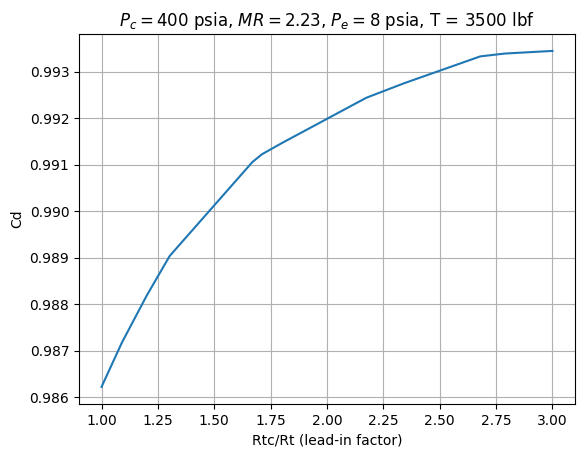

In [132]:
Pc = 400 # psia
Pe = 8 # psia
MR = 2.23
T = 3500 # lbf
R_rat = np.linspace(1, 3, 400) # Rc/Rt ratios

# Define nozzle geometry
rocketGeo = Geometry(Rthrt=1,
                   CR=4,  pcentBell=80, 
                   # set CR to be high enough for geometry 
                   # will fail at high RupThroat
                   RupThroat=1.5, RdwnThroat=1.0,
                   RchmConv=1.0, cham_conv_deg=30,
                   LchmMin=5.0)

# Define rocket's efficiencies, all 1 by default
rocketEff = Efficiencies()

# Define the core stream object of the core flow 
# that will flow through the engine. Needed for Cd calcs
rocketCore = CoreStream(geomObj=rocketGeo,
                        oxName="LOX", fuelName="RP-1",
                        MRcore=MR, Pc=Pc, Pamb=Pe)

# Define the Thruster object that holds the Geometry, 
# Efficiencies, and Core flow together
rocketThruster = RocketThruster(name='Fullscale',
                                coreObj=rocketCore,
                                calc_CdThroat=True)
Cd = np.zeros(len(R_rat))
for i, r in enumerate(R_rat):
    #print(r)
    rocketGeo.reset_attr('RupThroat', r)
    rocketThruster.set_eps_to_equal_pexit(Pe)
    rocketThruster.scale_Rt_to_Thrust(T, Pe)
    Cd[i] = rocketCore('CdThroat')

plt.Figure
plt.plot(R_rat, Cd)
plt.grid(True)
plt.ylabel("Cd")
plt.xlabel("Rtc/Rt (lead-in factor)")

plt.title(f"$P_c = ${Pc} psia, $MR = ${MR}, $P_e = ${Pe} psia, T = {T} lbf");

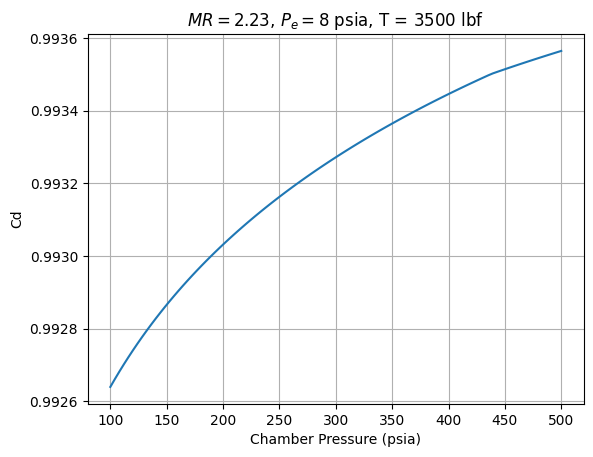

In [133]:
Pc = np.linspace(100, 500, 100) # psia

Cd = np.zeros(len(Pc))
for i, p in enumerate(Pc):
    rocketCore.reset_attr('Pc', p)
    rocketThruster.set_eps_to_equal_pexit(Pe)
    rocketThruster.scale_Rt_to_Thrust(T, Pe)
    Cd[i] = rocketCore('CdThroat')

plt.Figure
plt.plot(Pc, Cd)
plt.grid(True)
plt.ylabel("Cd")
plt.xlabel("Chamber Pressure (psia)")
plt.title(f"$MR = ${MR}, $P_e = ${Pe} psia, T = {T} lbf");

As you can see, $C_d$ increases with both $R_{tc}/R_t$ (the *lead-in factor*) and $P_c$. The smoother the inlet to the throat and the higher the inlet pressure, the more core mass flow can get through.

Note that for a perfect injector, $\eta_{ERE} = 1$, so $C^*_{eff} = \frac{1}{C_d}$. If you recall from the *Relating $C^*$ and $C_{\tau}$ to Thrust and Mass Flow Rate* section, for a fixed amount of thrust, if $C^*_{eff}$ goes down, the required mass flow rate goes up, whereas a higher $C_d$ also represents a higher flow rate.

For a nozzle with no kinetics, divergence, heat, or multi-phase loss, $\eta_{noz} = 1$, so $C_{\tau, eff} = C_d$. This may make a bit more intuitive sense than the correlation to $C^*_{eff}$ as it simply says that the ability of the nozzle to promote thrust is hindered by the lower effective area.

Either way, for the pressures we care about, we can be confident that the $C_d$ will be very close to 1 *even with boundary layer effects*.

### Finite Area Combustors

In this sections, we will focus one of the chamber efficiencies in particular: heat loss. Oftentimes, heat loss refers to the loss of energy to to the surroundings combination of convective, conductive, and radiative heat transfers. These are all *reversible* ways of reducing the energy release of the combustion chamber. One of the primary sources of energy loss, however, is *irreversible*. Or rather, a primary source of *useful* energy loss. How do we quantify useful energy? If you consider what is truly driving the generation of thrust in a rocket engine, you will see that it is, in fact, the pressure difference between the interior of the chamber and outside of the chamber. Therefore, pressure must be a way to describe the utility of the energy of a substance, whereas temperature is a nearly a qunatification of the total energy a substance has.

More generally, *stagnation temperature* is a quantification of the total energy a substance due to internal potential (chemical) energy and kinetic energy due to bulk movement. *Stagnation pressure* is a measure of how much of the total energy could be used to do work on our engine, creating thrust. In general, a decrease in stagnation pressure is marked by an increase in entropy, and entropy can increase either reversibly (through heat transfer) or irreverisbly.

A major phenomenon that generates irreversible stagnation pressure losses in a combustion chamber is limited volume of the combustion chamber itself. In a theoretical, **infinite area combustor**, the injector face is infintely large, meaning the pressure generated in the combustion chamber is nearly uniform. However, in a real, **finite area combustor** (FAC), the injector face is small enough such that the pressure distribution throughout combustion chamber is not uniform.

The NASA CEA manual provides a great visualization of this effect.

FAC.jpeg

In a finite area combustor, as the combustion process begins on the injector face, the hot gases begin to propagate into the combustion chamber. As the combustion process continues, the temperature of the gases increases while the gases head towards the converging section, decreasing the gas density. Since the cross-sectional area is constant, in order for mass flow to be steady, the velocity has to increase. Since the engine is assumed to adiabatic in thie scenario, this can *only* be accomplished through a drop in stagnation pressure. In other words, to preserve mass conservation, the stagnation pressure had to drop: we gave up some useful energy to keep the flow moving towards the nozzle. To clarify, even though the overall control volume is adiabatic, the stagnation temperature is **NOT** constant. 

So what's the fundamental driving force here? Why does the *stagnation pressure* have to drop and not just the static pressure? Why is the stagnation temperature not constant even though the walls are adiabatic? The answer is that there is actually heat addition! The heat that is generated is due to the breaking due to the release of chemical energy, which comes from the breaking of chemical bonds, as opposed to thermal energy, which is simply due to the translational, rotational, vibrational, and electronic movement of molecules (this is the difference between the enthalpy of formation and sensible enthalpy). Therefore, as we reach chemical equilibrium in the chamber, the constant addition of chemical energy increases the available high-energy translational energy modes for the individual molecules. As a result, the molecules are able to begin moving against the bulk fluid motion. So, not only does the fluid need to do work to keep the fluid moving, creatinga a static pressure drop, it needs to do more work than expected to counteract this new translational movement, creating a stagnation pressure loss. As for stagnation temperature, if you were to redefine the commonly used definition of stagnation temperature to include the enthalpies of formation, you will see that stagnation temperature does not change now. 

As this proccess is not adiabatic, it must have been irreversible. If you're wondering how it's possible for a process to be adiabatic but non-isentropic without friction, look no further than shock waves.

While this FAC effect is not, strictly speaking, a heat loss, it represents a loss in the usable energy nonetheless. Therefore, it will reduce the delivered $C^*_{eff}$. This effect is most commonly called **Rayleigh Line Loss**. You might recognize this as the same Rayleigh flow that's used to calculate property changes in a staright, heated duct. In that case, the constant heat addition comes from the reacting fluid itself. In reality, while Rayleigh line loss causes $C^*_{eff}$ to drop, it's the effects can be mitigated substantially with proper combustor design. Therefore, the usable energy loss due to Rayleigh flow is often indistinguishable from the substantially larger amount of heat lost to the surroundings.

Let's visualize how $C^*_{eff}$ is affected by Rayleigh Line Loss.

First we will revisit the $C^*$ definition: $C^* = \frac{P_cA_t}{\dot{m}}$. The $P_c$ in this equation is the one that you would use if there were no losses in pressure, so the one with in an infinite area combustor. So, we will call this pressure $P_{inj}$ to represent the injector face pressure. $P_c$ will now be used to represent the chamber pressure at the entrance of the converging section. Therefore, 

$C^*_{eff} = \frac{P_c}{P_{inj}}$

Unfortunately, with NASA CEA, and therefore RocketCEA, can only do FAC calculations for equilibrium flows, and we have already established that the flow is only equilibrium up to the throat. So, we need a new way to calculate the heat loss efficiency due to Rayleigh Line Loss. To find this using Rayleigh flow methods we could use the equation $\frac{P_{c}}{P_{inj}} = \frac{1}{1+ \gamma M^2}$ (assuming the injection velocity is negligible), but finding $M$ at the start of the nozzle takes a lot of iteration. We can use an empirical model that's almost an exact estimate for most propellants:

$\frac{P_{c}}{P_{inj}} = \frac{\epsilon_c^2}{\epsilon_c^2 + 0.54}$

Let's plot this.

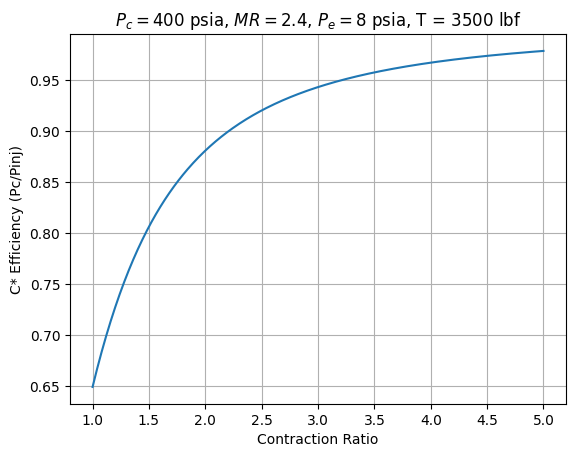

In [134]:
Pc = 400 # psia
Pe = 8 #psia
MR = 2.4
CR = np.linspace(1, 5, 400) # contraction ratios

# infinite area combustor cstar
cstar_eff = np.zeros(len(CR))
for i, c in enumerate(CR):
    cstar_eff[i] = (c**2)/(c**2 + 0.54)

plt.Figure
plt.plot(CR, cstar_eff)
plt.grid(True)
plt.xlabel("Contraction Ratio")
plt.ylabel("C* Efficiency (Pc/Pinj)")
plt.title(f"$P_c = ${Pc} psia, $MR = ${MR}, $P_e = ${Pe} psia, T = {T} lbf");

As you can see, $C^*_{eff}$ increases asympotically as a function of the contraction ratio, $\epsilon_c$, which the ratio of the cross-sectional area of the combustion chamber to throat area. As the contraction ratio increases, so does the efficiency. Why? The smaller the ratio becomes, the more like a straight duct. In an adiabatic nozzle, if the flow is not accelerating due to area changes, it is accelerating due to irreversible stagnation pressure loss. You can also think of this in terms of the $C_d$ for a perfect injector.

$C^*_{eff} = \frac{1}{C_d}$

If $\epsilon_c$ goes up, the impedance to the mass flow, $C_d$, goes up, so $\dot{m}$ itself decreases. In this scenario, however, we maintained a constant thrust, so we are effectively saying that we are requiring less mass flow for the same thrust, so the energy release efficiency must be increasing. The NASA CEA manual image of the infinite area combustor shows how infinite area combustors effectively have infinite contraction ratio, providing no line loss. You can imagine now how making the combustion area finite, it would decrease the thrust: the effective pressure forcing the flow to create thrust is lower! 

To summarize, if you don't use a variable-area nozzle to accelerate your flow, you pressure will decrease anyway and creates significantly less thrust. Additionally, contraction ratios above 2 are preferred. Lower values of $\epsilon_c$ can more severely affect your energy release.

# Contour Design Process

Before getting into choosing what our geometric parameters actually are, I think it's first helpful to try an go through the design process to see what geometric constraints we actually need. The goal of this will be to see how the engine parameters ($P_c$, $MR$, etc.) we have chosen directly affect our choice of geometry.

### $R_t$, Throat Radius

The most important parameter in contour design is the throat radius because it establishes the maximum mass flow rate through the nozzle. Assuming that we have no losses due to engine size, all other geometric parameters are independent of scale. The scale of the engine, and therefore the thrust, is set by the throat radius. For choked flow:

$\dot{m}_{actual} = C_dA_t\frac{P_c}{\sqrt{RT_c}}\sqrt{\gamma}\left(1 + \frac{\gamma - 1}{2}\right)^{\frac{\gamma + 1}{2(\gamma - 1)}}$

Therefore, we can see that increasing $P_c$ will increase the mass flow rate. So to get the same mass flow rate with a higher pressure, we must reduce the throat area. So, for a given thrust, $R_t$ shrinks as $P_c$ gets larger. What is the affect of $MR$ on mass flow and throat area?

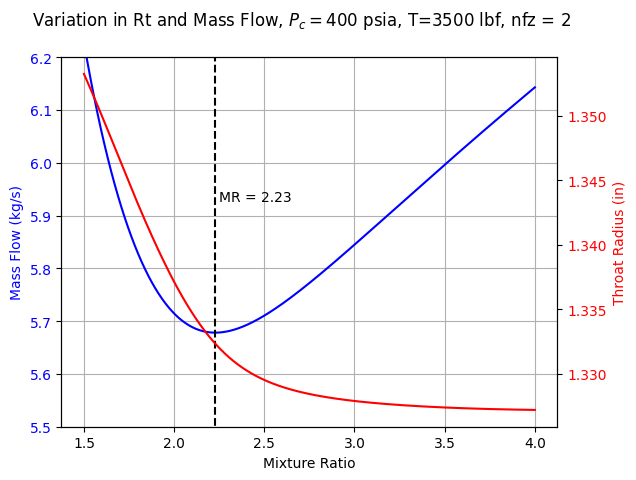

In [135]:
Pc = 400  # psia
Pe = 8  # psia
T = 3500  # lbf, assume perfectly expanded

MR = np.linspace(1.5, 4, 400)
R_t = np.zeros(len(MR)) 
mass_flow = np.zeros(len(MR))

for i, mc in enumerate(MR):
    eps = rocket.get_eps_at_PcOvPe(Pc, mc, Pc / Pe, 1, 1)
    _, _, ae = rocket.get_SonicVelocities(Pc, mc, eps, 1, 1)
    Me = rocket.get_MachNumber(Pc, mc, eps, 1, 1)
    Ve = ae * Me
    
    mdot = (T * 4.44822) / Ve  # lbf -- N
    mass_flow[i] = mdot
    Pt = (Pc * 6894.76) / rocket.get_Throat_PcOvPe(Pc, mc)  
    # psia --> Pa
    
    _, Tt, _ = rocket.get_Temperatures(Pc, mc, eps, 1, 1)
    mol_wt, gamma = rocket.get_Throat_MolWt_gamma(Pc, mc, eps, 1)
    
    R = 8314 / mol_wt
    A_t = (mdot / Pt) * np.sqrt(R * Tt / gamma)
    
    R_t[i] = np.sqrt(A_t / np.pi) * 39.3701  # m --> in

fig, ax1 = plt.subplots()

ax1.plot(MR, mass_flow, 'b', label="Mass Flow (kg/s)")
ax1.set_xlabel("Mixture Ratio")
ax1.set_ylabel("Mass Flow (kg/s)", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(MR, R_t, 'r', label="Throat Radius (inches)")
ax2.set_ylabel("Throat Radius (in)", color='r')
ax2.tick_params(axis='y', labelcolor='r')

ind = mass_flow.argmin()
ax1.vlines(MR[ind], 0, 10, colors='k', linestyles='--')
ax1.set_ylim([5.5, 6.2])
ax1.annotate(f"MR = {(MR[ind]):.2f}", 
             (MR[ind], mass_flow[ind]), 
             (MR[ind] + 0.02, mass_flow[ind] + 0.25))

fig.suptitle(f"Variation in Rt and Mass Flow, $P_c=${Pc} psia, T={T} lbf, nfz = 2");


The variation in the required mass flow rate can be attributed to the fact that our $I_{sp}$ is varying in the exact same manner. If you recall, $MR = 2.23$ was the $MR$ at which the highest performance was attained, so it is the point where we will need the lowest mass flow. $R_t$ also varies, but not significantly, especially after the ideal $I_{sp}$ is reached. You'll notice that the throat radius decreases linearly until the optimal $MR$ is attained, after which it begins to decrease asymptotically. 

Therefore, when the $MR$ changes the contour of the engine must also change. Not only must the throat area change, but the radii leading up to the throat and potentially the contraction ratio must change to keep the flow free of extreme turns. 

With that established, let's find the throat radius and start plotting our contour.

In [136]:
Pc = 400 # psia
Pe = 8 # psia
T = 3500 # lbf
MR = 2.23

eps = rocket.get_eps_at_PcOvPe(Pc, MR, Pc / Pe, 1, 1)
_, _, ae = rocket.get_SonicVelocities(Pc, MR, eps, 1, 1)
Me = rocket.get_MachNumber(Pc, MR, eps, 1, 1)
Ve = ae * Me
mdot = (T * 4.44822) / Ve  # lbf -- N
Pt = (Pc * 6894.76) / rocket.get_Throat_PcOvPe(Pc, MR)  
# psia --> Pa
_, Tt, _ = rocket.get_Temperatures(Pc, MR, eps, 1, 1)
mol_wt, gamma = rocket.get_Throat_MolWt_gamma(Pc, MR, eps, 1)
R = 8314 / mol_wt
A_t = (mdot / Pt) * np.sqrt(R * Tt / gamma)
R_t = np.sqrt(A_t / np.pi) * 39.3701  # m --> in

plt.Figure
plt.scatter(10, R_t, c = 'k', zorder = 3)
plt.annotate(f"Rt = {R_t:.2f} in", (10, R_t), (10 + 0.2, R_t+0.1))
plt.ylim([0, 4])
plt.xlim([0, 20])
plt.grid(True)
plt.vlines(10, -1, R_t, colors='r', linestyles='--')
plt.xlabel("Axial Length (in)")
plt.ylabel("Radial Length (in)")
plt.title(f"$P_c = ${Pc} psia, $MR = ${MR}, $P_e = ${Pe} psia, T = {T} lbf");

So far, we have established a single point along our contour.

### Converging Section

We'll move upstream from the throat to form the contracting part of our nozzle. You've already seen one of the major determining factors of the shape of the converging section, $\epsilon_c$, the contraction ratio, the ratio of the chamber cross-sectional area to the throat area, as one of the primary determining factors for Rayleigh Line Loss in Finite Area Combustors. Just by looking at professional engines (Raptor), you'll notice that larger engines tend to have smaller contraction ratios. Much of that has to do with minimizing kinetics losses (giving ample stay time for the propellants) and the thrust levels at which these engines operate. However, the initial choice for contraction ratio is mainly determined based on historical data, durability manufacturability. For example, the volume of the chamber needs to be optimized to minimize kinetics losses, cooling surface area, and weight. Additionally, a much larger engine would need more mass flow and therefore a larger throat. Making the combustion chamber have a cross-sectional area that's more than 1.5-2 times larger may just not practical to manufacture. Similarly, for a small engine with a tiny throat area, having small contraction ratio makes injector design really difficult. To summarize, contraction ratio is largely determined empirically and not anayltically.

Rayleigh Line Loss is one way to **optimize** for $\epsilon_c$, and we can optimize for a value, but let's just pick one and roll with it. Based on *Liquid Rocket Thrust Chambers* by Yang et al., contraction ratios between 2 and 4 will prevent any large Rayleigh Line Losses. Historically, YJSP has gone up to $\epsilon_c = 4.3$ (Vespula) and $\epsilon_c = 4.5$ (Subscale) before, so we will set 4.5 as the max. Based on our throat area, let's see the minimum and maximum injector face plate areas we have to work with and also the associated line losses.

In [137]:
# Make sure to run the cell from the previous section!
ec = np.array([2, 4.5]) # Max and min contraction ratio
Pinj = 400 # psia
MR = 2.23

print(f"Throat Radius: {R_t:.2f} in")
A_t = np.pi * R_t**2
print(f"Throat Area: {A_t:.2f} in^2")
print(f"Minimum Injector Face Plate Area: {(ec[0]*A_t):.2f} in^2")
print(f"Maximum Injector Face Plate Area: {(ec[1]*A_t):.2f} in^2")
print(f"Minimum Injector Face Plate Diameter: {(np.sqrt(ec[0]*A_t*4/np.pi)):.2f} in^2")
print(f"Minimum Injector Face Plate Diameter: {(np.sqrt(ec[1]*A_t*4/np.pi)):.2f} in^2")

for i, c in enumerate(ec):
    loss = 1 / (rocket.get_Pinj_over_Pcomb(Pinj, MR, c))
    print(f"CR = {c}, Loss = {((1-loss) * 100):.3f} %")


Throat Radius: 1.33 in
Throat Area: 5.58 in^2
Minimum Injector Face Plate Area: 11.15 in^2
Maximum Injector Face Plate Area: 25.09 in^2
Minimum Injector Face Plate Diameter: 3.77 in^2
Minimum Injector Face Plate Diameter: 5.65 in^2
CR = 2.0, Loss = 10.148 %
CR = 4.5, Loss = 2.006 %


Injectors that are as smaller as 3-4 inches in diameter can be a pain to machine. Imagine trying to fit several coaxial swirl elements in that small of an area. The only injector that could possibly work in an impinging injector. Therefore, since we want the capability to do all types of injectors, we should aim for a $\epsilon_c$ closer to 3-4. The line loss values also support this. Let's back this up with some historical data, which *MODERN ENGINEERING FOR DESIGN OF LIQUID-PROPELLANT ROCKET ENGINES* by Dieter K. Huzel and David H. Huang [H&H] has provided for us.

conrate.jpeg

The data in this chart can be distilled into the following empirical relation:

$\epsilon_c = (3.017)R_t^2 + 1.25$

where $R_t$ is in inches. Let's round up the chosen contraction ratio to a single decimal place and establish the injector face plate diameter and line loss.

In [138]:
chosen_CR = (3.017)*(R_t**(-0.6)) + 1.25

print(f"Contraction Ration: {chosen_CR:.1f}")
print(f"Injector Face Plate Diameter: {(np.sqrt(chosen_CR*4*A_t/np.pi)):.2f} in")
loss = 1 / (rocket.get_Pinj_over_Pcomb(Pinj, MR, chosen_CR))
print(f"Rayleigh Line Loss: {((1-loss)*100):.2f} %")

Contraction Ration: 3.8
Injector Face Plate Diameter: 5.19 in
Rayleigh Line Loss: 2.83 %


This seems pretty feasible, so we can roll with $\epsilon_c = 3.8$. Let's plot the contour so for.

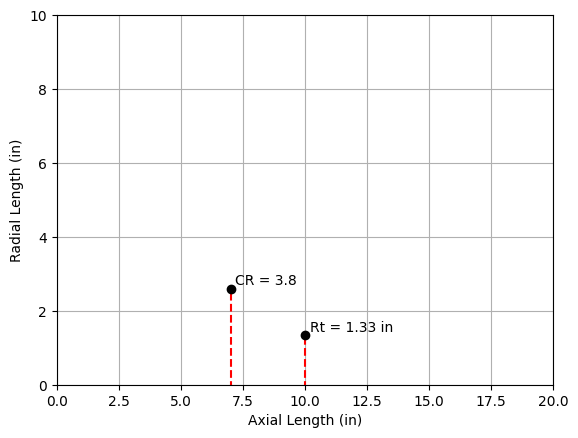

In [139]:
plt.Figure
eps_c = round(chosen_CR, 1)
# --- R_t ----- 
plt.scatter(10, R_t, c = 'k', zorder = 3)
plt.annotate(f"Rt = {R_t:.2f} in", (10, R_t), (10 + 0.2, R_t+0.1))
plt.vlines(10, -1, R_t, colors='r', linestyles='--')
# --- CR ----- 
plt.scatter(7, R_t*np.sqrt(eps_c), c = 'k', zorder = 3)
plt.annotate(f"CR = {eps_c:.1f}", (7, R_t*np.sqrt(eps_c)), 
             (7 + 0.2, R_t*np.sqrt(eps_c)+0.1))
plt.vlines(7, -1, R_t*np.sqrt(eps_c), colors='r', linestyles='--')
plt.ylim([0, 10])
plt.xlim([0, 20])
plt.grid(True)
plt.xlabel("Axial Length (in)")
plt.ylabel("Radial Length (in)");

These points are unconstrained along the x-axis but fixed along the y-axis. We can draw a line between the two points to make a simplified converging section.

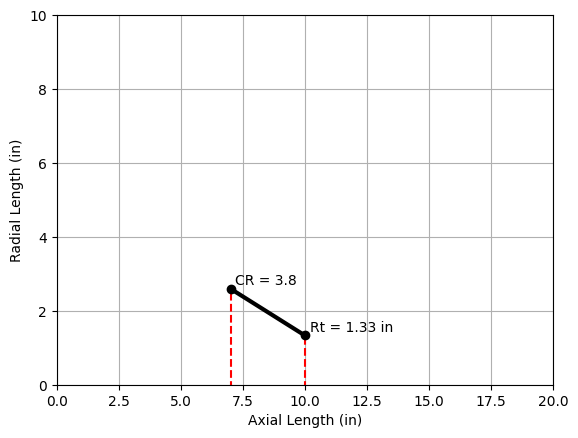

In [140]:
plt.Figure
eps_c = round(chosen_CR, 1)
# --- Throat ----- 
x_tempThroat = 10 # temporary coordinates
plt.scatter(x_tempThroat, R_t, c = 'k', zorder = 3)
plt.annotate(f"Rt = {R_t:.2f} in", (x_tempThroat, R_t), 
             (x_tempThroat + 0.2, R_t+0.1))
plt.vlines(x_tempThroat, -1, R_t, colors='r', linestyles='--')
# --- Coverging section ----- 
x_tempConvStart = x_tempThroat - 3
y_tempConvStart = R_t*np.sqrt(eps_c)
plt.scatter(x_tempConvStart, y_tempConvStart, c = 'k', zorder = 3)
plt.annotate(f"CR = {eps_c:.1f}", (x_tempConvStart, y_tempConvStart), 
             (x_tempConvStart + 0.2, y_tempConvStart+0.1))
plt.vlines(x_tempConvStart, -1, y_tempConvStart, colors='r', 
           linestyles='--')
x_Conv = np.linspace(x_tempConvStart, x_tempThroat, 400)
slope_Conv = ((y_tempConvStart - R_t) / (x_tempConvStart - x_tempThroat))
y_Conv = slope_Conv*(x_Conv - x_tempThroat) + R_t
plt.plot(x_Conv, y_Conv, c='k', linewidth = 3)
plt.ylim([0, 10])
plt.xlim([0, 20])
plt.grid(True)
plt.xlabel("Axial Length (in)")
plt.ylabel("Radial Length (in)");

How can we better constrain the converging section along the x-direction? Our primary consideration will be the angle at which the line presented is with respect to the horizontal. Typically, this angle, which we will call the *convergence half-angle*, $\theta_c$, is determined through lots of fluids simulations to see which configuration gives the lowest stagnation pressure loss. Without those resources, the best we can do is kind of just guess based on what's easy to manufacture. Based on Sutton, "The converging nozzle section shape between the chamber and the throat does not significantly affect nozzle performance"..."subsonic flow can easily be turned with very low pressure drops and almost any given radius, cone angle, wall con- tour curve, or nozzle inlet shape is satisfactory." Moreover, Sutton also implies that the throat curvature leading up to the throat is also not that critical. Since the pressure before the throat is so much higher than the pressure after, flow separation due to weird turns and dents is usually not an issue. For us, all this means is that we should make the converginge section as smooth as possible in a way that's as easy to manufacture as possible without making our engine absurdly heavy: just do what has worked before.

Based on previous YJSP designs and this paper, *Numerical Analysis of Convergent-Divergent Angles and Operating Conditions Impact on Rocket Nozzle Performance Parameters*, which created flow simulations for RP-1/LOX, angles between 25° and 40° work pretty well, with an optimal point being 37.5°. We can't be sure how generalizable this is for engines of our size, but we will use 37.5° as a starting point and then optimize more later on.

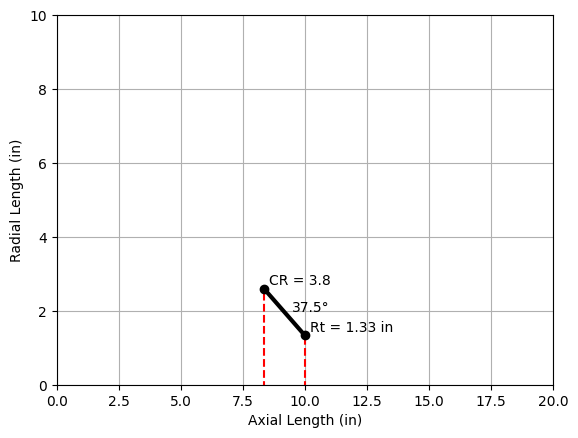

In [141]:
plt.Figure
eps_c = round(chosen_CR, 1)
# --- Throat ----- 
x_tempThroat = 10 # temporary coordinates
plt.scatter(x_tempThroat, R_t, c = 'k', zorder = 3)
plt.annotate(f"Rt = {R_t:.2f} in", (x_tempThroat, R_t), 
             (x_tempThroat + 0.2, R_t+0.1))
plt.vlines(x_tempThroat, -1, R_t, colors='r', linestyles='--')
# --- Coverging section ----- 
theta_c = 37.5 # degrees
y_tempConvStart = R_t*np.sqrt(eps_c)
slope_Conv = np.tan(np.deg2rad(-theta_c))
x_tempConvStart = ((y_tempConvStart - R_t)/slope_Conv) + x_tempThroat
plt.scatter(x_tempConvStart, y_tempConvStart, c = 'k', zorder = 3)
plt.annotate(f"CR = {eps_c:.1f}", (x_tempConvStart, y_tempConvStart), 
             (x_tempConvStart + 0.2, y_tempConvStart+0.1))
plt.vlines(x_tempConvStart, -1, y_tempConvStart, colors='r', 
           linestyles='--')
x_Conv = np.linspace(x_tempConvStart, x_tempThroat, 400)
y_Conv = slope_Conv*(x_Conv - x_tempThroat) + R_t
plt.plot(x_Conv, y_Conv, c='k', linewidth = 3)
plt.annotate(f"{theta_c}°", ((x_tempConvStart+x_tempThroat)/2 + 0.3, 
                             (y_tempConvStart+R_t)/2))
plt.ylim([0, 10])
plt.xlim([0, 20])
plt.grid(True)
plt.xlabel("Axial Length (in)")
plt.ylabel("Radial Length (in)");

If we connected this to the chamber as it is, there would be a pretty sharp turn to start the converging section. To eliminate any potential stagnation points (bad for wall heating), we should make the converging section a bit more cruved on either end. The radii of these curves will be established as a ratios with respect to the thraot radius. We will call the radius at the beginning of the converging section $R_c$, the convergence radius, and the radius directly upstream of the throat $R_{tc}$, the lead-in radius. Again, the values of $R_c/R_t$ and $R_{tc}/R_t$ don't actually have a huge impact. Usually, these values are between 0.5-1.5 times the throat radius, so we will just roll with 1 for both

$\frac{R_c}{R_t} = 1$

$\frac{R_{tc}}{R_t} = 1$

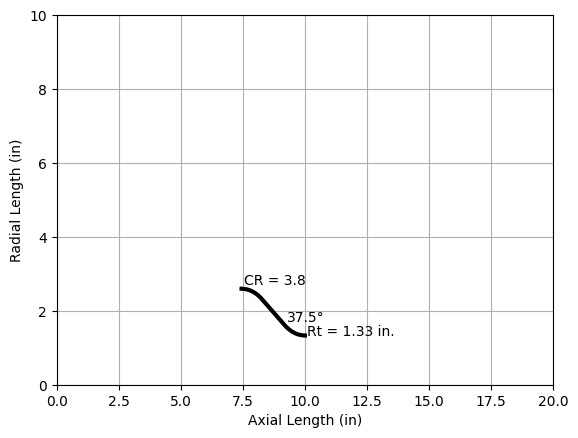

In [142]:
Rc_Rt = 1
Rtc_Rt = 1
theta_c = 37.5 # deg
eps_c = 3.8

G = Geometry(Rthrt=R_t, CR=eps_c, RupThroat=Rtc_Rt, 
             RchmConv=Rc_Rt, cham_conv_deg=theta_c)
N = G.getNozObj()
#N.set_abs_Rt(R_t)
z = np.array(N.abs_zContour)
r = np.array(N.abs_rContour)
ind = z <= 0# RocketIsp defaults throat at (0, 0)
z = z[ind] + 10
r = r[ind]

plt.figure
plt.plot(z, r, c='k', linewidth=3)
plt.ylim([0, 10])
plt.xlim([0, 20]) 
plt.grid(True)
plt.xlabel("Axial Length (in)")
plt.ylabel("Radial Length (in)")
plt.annotate(f"CR = {eps_c}", (z[0], r[0]), (z[0] + 0.1, r[0] + 0.1))
plt.annotate(f"{theta_c}°", (z[10], r[10]), (z[10] + 0.1, r[10] + 0.1))
plt.annotate(f"Rt = {r[-1]:.2f} in.", (z[-1], r[-1]), (z[-1] + 0.1, r[-1]));

### Combustion Chamber

Now we have to figure out how long the chamber needs to be. For this, we can't rely on isentropic expansion, but that's okay: there are a plethora of things that constrain the size of our chamber. Most of it comes down to manufacturing constraints and weight. For example, we don't want to have too much surface area to cool, and we don't want a nozzle that's so long that it adds unecessary weight (and friction). To start, we can attempt to find a happy medium between a practical surface area, a large enough contraction ratio that our injector isn't impossible to machine, and a chamber length that gives enough stay time for the propellants. This last constraint is set by a design choice called the characteristic length, $L^*$.

#### $L^*$, Characteristic Length

This is the ratio of the engine volume before the throat to the throat area (NOT just the cylindrical portion because the reaction equilibrium reactions continue to occur until the throat). In other words, it tells you how much space your propellants have to react before getting accelerated. Therefore, the $L^*$ is a function of the chosen propellants. Some propellants require more *stay time* in the chamber and others don't need as much. Keep in mind, this is not a real length (the combustion chamber is not actually $L^*$ inches long), but a fictional dimension that happens to have the same units as real length.

Increasing  $L^*$ to improve performance comes with the downsides of added weight, more frictional losses, and more surface area that needs cooling. It's also best to test values before settling on an $L^*$. However, there is a lot of test data that serve as a starting point. Based on Table 4-1 in H&H, for RP-1/LOX, recommended $L^*$ values are between *40-50 inches*. Figure 4-7 in H&H also indicates the increasing $L^*$ can asymptotically increase your $C^*$ efficiency. This is because the propellants have more time to combine, increasing the energy release and decreasing kinetics losses. There's no way to analytically determine this relationship using our simple models since it's a highly non-isentropic phenomenon, but it should be noted that the relationship is asymptotic: increasing $L^*$ comes with diminishing returns on performance.

With the constraint of $L^*$ = 40-50 inches, let's do some chamber optimization

lstar.jpeg

#### Constraints and Optimization

Imagine now that you're tasked with creating a combustion chamber while trading a bunch of variables. For example, you want to maximize the chamber volume to give the propellants time to mix, but you also want to minimize surface area so your don't have too much area to cool with your regen channels. You want to increase your chamber length to increase $L^*$, but that adds to your weight. You want to increase your contraction ratio to help Rayleigh Line Loss, but that makes manufacturing harder. How do you trade all of these variables?

The following code optimizes for a few different things:

- Maximize volume and manufacturability
- Minimize surface area, price, weight, and line loss

We will first define weightings for each of the considerations discussed. Notice that we care the most about manufacturability. We will then find the minimum and maximum chamber lengths (the cylindrical section lengths) for our optimization bounds. The minimum chamber cylindrical length is when the volume is minimum, $\epsilon_c$ is maximum, and $\theta_c$ is minimum. The converse is true for the maximum chamber length. RocketIsp provides a method to find the approximate total chamber volume and H&H gives a formula to the approximate surface area (chamber and converging section). While these methods are used for comparison, the code itself uses solids of revolution to find the volume and surface area. Using this, we define a scalar cost function that decreases as our targets are reached. The parameters $L_c$ (cylindrical length), $\epsilon_c$, $\theta_c$ that minimze this cost function are then determined.

Feel free to play around with the weights and see what they do.

In [143]:
# WEIGHTS
a = 5 # surface area weight
b = 20 # engine weight weight
c = 10 # price weight
d = 0.3 # line loss weight
e = 0.9 # volume weight
f = 50 # manufacturability weight

Rc_Rt = 1
Rtc_Rt = 1
eps_c_range = np.array([3.5, 4.3]) 
theta_c_range = np.array([35, 40]) # deg
Lstar_range = np.array([40, 50]) # in

# Compute throat area and chamber volume range
A_t = np.pi * R_t**2
Vc_range = A_t * Lstar_range # calculate min and max chamber volume

# Initialize Geometry instance (Assuming Geometry class exists)
G1 = Geometry(Rthrt=R_t, CR=eps_c_range[1], RupThroat=Rtc_Rt, 
             RchmConv=Rc_Rt, cham_conv_deg=theta_c_range[0], 
             LchamberInp=10) # min Lc case

G2 = Geometry(Rthrt=R_t, CR=eps_c_range[0], RupThroat=Rtc_Rt, 
             RchmConv=Rc_Rt, cham_conv_deg=theta_c_range[1], 
             LchamberInp=10) # max Lc case

# finds Lc corresponding to a certain chamber volume, 
# uses RocketIsp's built in volume finder
def search_Lc(Vc, geo):
    """Finds the chamber length (Lc) that results in 
    the target chamber volume (Vc)."""
    L = np.linspace(0, 30, 10000)
    dV = 0.05 
    for i in range(len(L)):
        geo.reset_attr('LchamberInp', L[i])
        if abs(Vc - geo.Vcham) < dV:
            return geo.Lcham_cyl
    return None 

# finds volume and surface area using solids of revolution
def volume_and_surface_area(Lc, eps_c, theta_c):
    geo = Geometry(Rthrt=R_t, CR=eps_c, RupThroat=Rtc_Rt, 
                   RchmConv=Rc_Rt, cham_conv_deg=theta_c, 
                   LchamberInp=10)
    total_L = Lc + geo.Lcham_conv
    geo.reset_attr('LchamberInp', total_L)
    vol_cyl = solidCylVol(geo.Dinj, geo.Lcham_cyl)
    
    noz = geo.getNozObj()
    z = np.array(noz.abs_zContour)
    r = np.array(noz.abs_rContour)
    ind_conv = z <= 0
    x_conv = z[ind_conv]
    y_conv = r[ind_conv]
    dx_conv = np.diff(x_conv)
    dy_conv = np.diff(y_conv)

    vol_conv = np.pi * np.sum((y_conv[:-1]**2 + y_conv[1:]**2) / 2 * dx_conv)
    volume = vol_cyl + vol_conv

    ds = np.sqrt(dx_conv**2 + dy_conv**2) 
    conv_surface_area = 2 * np.pi * np.sum((y_conv[:-1] + y_conv[1:]) / 2 * ds)
    chamber_surface_area = 2 * geo.Lcham_cyl * np.sqrt(np.pi * geo.CR * geo.At)
    surface_area = chamber_surface_area + conv_surface_area

    # surface area from H&H for comparison if needed
    surface_area_compare = (1 / np.sin(np.deg2rad(geo.cham_conv_deg))) * (geo.CR - 1) * geo.At + 2 * geo.Lcham_cyl * np.sqrt(np.pi * geo.CR * geo.At)

    return volume, surface_area, surface_area_compare

# scalar cost function to minimize
def cost_function(x):
    Lc, eps_c, theta_c = x  # Unpack the variables
    vol, surf, surf_c = volume_and_surface_area(Lc, eps_c, theta_c)
    weight = 0;
    manfacturability = 1;
    price = 2*Lc;
    line_loss = 1 + 0.54/(eps_c**2)
    if Lc > 10:
        weight = 5*Lc # after Lc > 10 in, weight becomes concern (arbitrary), 
        #a cost of 5 is incurred for each extar inch
    if eps_c >= 3.85:
        manfacturability = 1 - (eps_c/3.85) # after eps_c >= 3.85 in, 
        # manufacturability becomes concern (arbitrary)
    cost = (a*surf + b*weight + c*price + d*line_loss)/(e*vol + f*manfacturability)
    return cost

Lc_range = np.array([search_Lc(Vc_range[0], G1), search_Lc(Vc_range[1], G2)])
Lc_range = np.around(Lc_range, 1)
print(f"Chamber Cylindrical Length Range: {Lc_range[0]:.1f}-{Lc_range[1]:.1f} in.")

bounds = [(Lc_range[0], Lc_range[1]), 
          (eps_c_range[0], eps_c_range[1]),
            (theta_c_range[0], theta_c_range[1])]
x0 = np.array([8, 3.6, 37.5])  # Initial guess
result = minimize(cost_function, x0, bounds=bounds, method='SLSQP')
Lc_opt, eps_c_opt, theta_c_opt = np.around(result.x, 1)
print(f"Optimized Lc: {Lc_opt} in, eps_c: {eps_c_opt}, theta_c: {theta_c_opt}°")

G_opt = Geometry(Rthrt=R_t, CR=eps_c_opt, RupThroat=Rtc_Rt, 
             RchmConv=Rc_Rt, cham_conv_deg=theta_c_opt, LchamberInp=10)
L_total = Lc_opt + G_opt.Lcham_conv 
# get the final injector 
#to throat length for future reference

Chamber Cylindrical Length Range: 7.7-12.9 in.
Optimized Lc: 7.9 in, eps_c: 3.8, theta_c: 37.5°


Obviously, the optimization we did is very high-level and is missing much of the nuance needed for realistic design trades. But, we can see how we the computer could do a lot of the work for us. Let's design the chamber and the coverging section based on these parameters from the optimization: $L_c = 7.9$ in, $\epsilon_c = 3.8$, $\theta_c = 37.5$°. The following code uses parametric equations to simplify the contour generations process and to make the contour scaleable.

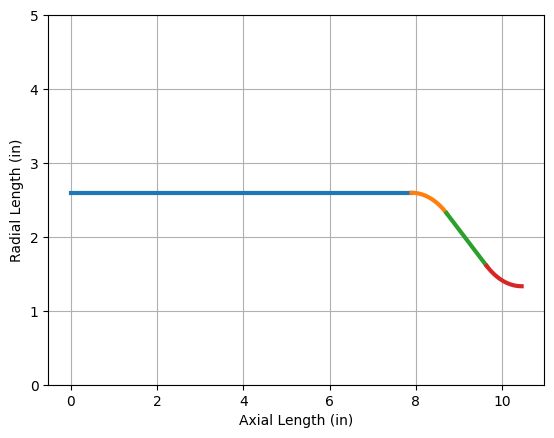

In [144]:
Rc = 1 * R_t # in
Rtc = 1 * R_t # in
theta_c = 37.5 # deg
Lc = 7.9 # cylindrical length
eps_c = 3.8

# Chamber cylinder section
theta_c = np.deg2rad(theta_c)
f1z = np.linspace(0, Lc, 400)
f1r = np.ones(len(f1z))*np.sqrt(eps_c)*R_t
plt.figure
plt.ylim([0, 5])
plt.grid(True)
plt.plot(f1z, f1r, linewidth=3)

# Converging entrance arc
t = np.linspace(np.pi/2, np.pi/2 - theta_c, 400)
f2z = Rc*np.cos(t) + Lc
f2r = Rc*np.sin(t) + R_t*np.sqrt(eps_c) - Rc
inds = np.argsort(f2z)
f2z = f2z[inds]
f2r = f2r[inds]
plt.plot(f2z, f2r, linewidth=3)

# Converging linear section
y3 = R_t*(np.sqrt(eps_c)-1) - (Rc-Rc*np.cos(theta_c)) - (Rtc-Rtc*np.cos(theta_c))
x3 = y3 / (np.tan(theta_c))
f3z = np.linspace(f2z[-1], f2z[-1] + x3, 400)
m = -np.tan(theta_c)
f3r = m*(f3z - f2z[-1]) + f2r[-1]
plt.plot(f3z, f3r, linewidth=3)

# Converging throat arc
t = np.linspace(np.pi + np.pi/2 - theta_c, 3*np.pi/2, 400)
h = f3z[-1] + Rtc*np.sin(theta_c)
k = R_t + Rtc
f4z = Rtc*np.cos(t) + h
f4r = Rtc*np.sin(t) + k
inds = np.argsort(f4z)
f4z = f4z[inds]
f4r = f4r[inds]
plt.plot(f4z, f4r, linewidth=3)
plt.xlabel("Axial Length (in)")
plt.ylabel("Radial Length (in)");

Let's do one last check with historical data in order to make sure that our designs are on the right track. I will use the data presented in Figure 4-10 of H&H to intepolate the chamber length for our throat diameter. I have digitized the data for interpolation.

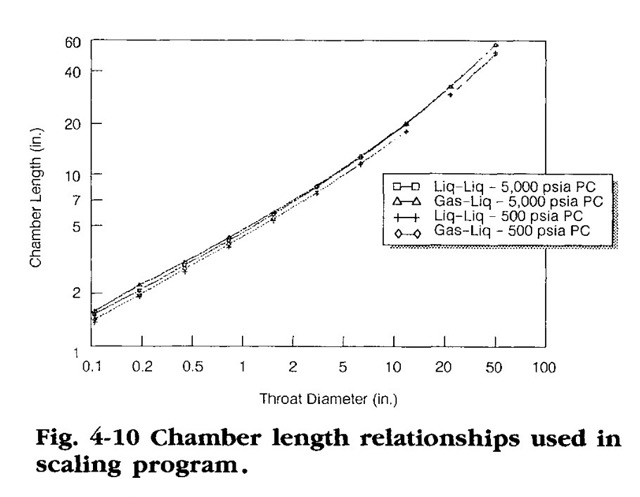

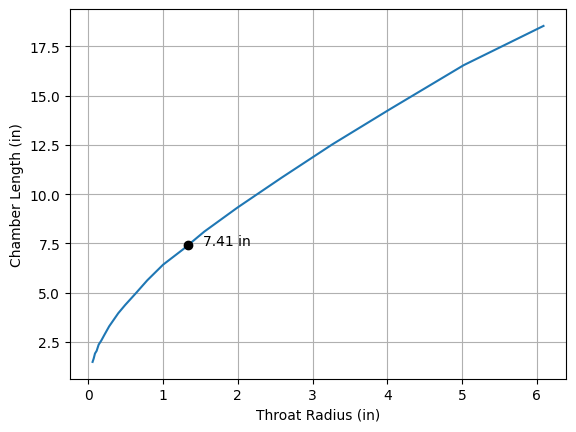

In [145]:
chamber_length_data = np.array([
    [0.10958427823823656, 1.4788710805161214],
    [0.13887019927618502, 1.64538118939387],
    [0.17437680655707705, 1.9066978573941842],
    [0.21829273560249032, 2.040128909503239],
    [0.2729485649548156, 2.357285616348729],
    [0.34210412206562707, 2.561020912458446],
    [0.4314530733984856, 2.8724636095918923],
    [0.5542449897593084, 3.2877713847859042],
    [0.7980107718221926, 3.954559557628561],
    [0.9852410125550133, 4.376552121760222],
    [1.2570661146456072, 4.9430166394235515],
    [1.575279949408834, 5.625590937439207],
    [1.9986704760061416, 6.418418975389426],
    [2.524309102356451, 7.1837670998197405],
    [3.1017333675908145, 8.09791501855886],
    [3.9864720578623865, 9.313530173107724],
    [5.1647136942963146, 10.82780183843921],
    [6.527336022287627, 12.524143776097716],
    [8.066317100268563, 14.30705302821778],
    [10.045168276151113, 16.5471707954952],
    [12.18291434709392, 18.541905308016172]
])

L_c_interp = np.interp(R_t, chamber_length_data[:, 0]/2, 
                       chamber_length_data[:, 1])

plt.Figure
plt.plot(chamber_length_data[:, 0]/2, chamber_length_data[:, 1])
plt.grid(True)
plt.ylabel("Chamber Length (in)")
plt.xlabel("Throat Radius (in)")
plt.scatter(R_t, L_c_interp, c='k', zorder = 3)
plt.annotate(f"{L_c_interp:.2f} in", (R_t + 0.2, L_c_interp));

As we can see, we are very close to what H&H prescribes with slight modifications to accomodate the characteristic length for RP-1/LOX and for weight and manufacturability optimzation. Looks like we're good to go on everything upstream of the throat.

### Diverging Section

#### $MR$ vs $\epsilon$

The primary constraint for diverging section is $\epsilon$, the expansion ratio, the ratio between the nozzle exit area and the throat area. This is determined entirely by the exit pressure, which can be found using $P_c$ and $\gamma$ with isentropic relations. However, $\gamma$ depends on what kind equilibrium model we use. We already know that $\gamma$ is affected by $MR$, so, before sizing the diverging section of the nozzle, let's see what kind of impact that $MR$ has on $\epsilon$ for a given $P_e$

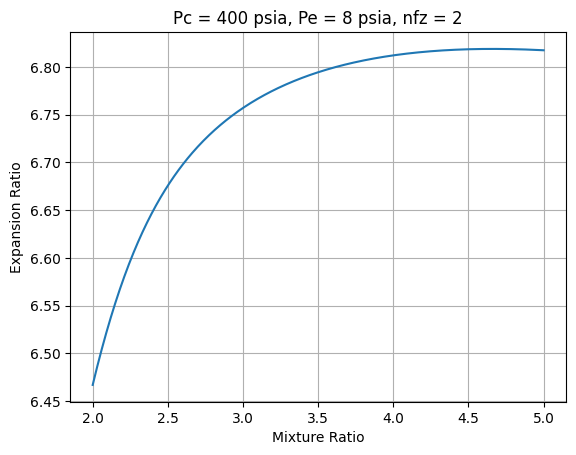

In [146]:
Pc = 400 #psia
Pe = 8 # psia
MR = np.linspace(2, 5, 400)

eps = np.zeros(len(MR))
for i, mc in enumerate(MR):
    eps[i] = rocket.get_eps_at_PcOvPe(Pc, mc, Pc/Pe, 1, 1) 
    # nfz = 2

plt.Figure
plt.plot(MR, eps)
plt.grid(True)
plt.xlabel('Mixture Ratio')
plt.ylabel('Expansion Ratio')
plt.title(f"Pc = {Pc} psia, Pe = {Pe} psia, nfz = 2");

We can pretty clearly see that the required exit area increases a good bit to reach the same $P_e$. 

#### $P_c$ vs $\epsilon$

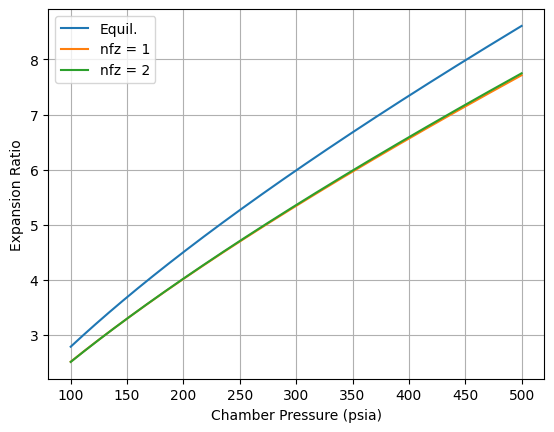

In [147]:
Pc = np.linspace(100, 500, 400) # psia
Pe = 8 # psia
MR = 2.23

eps = np.zeros((3, len(Pc)))
for i, p in enumerate(Pc):
    eps[0, i] = rocket.get_eps_at_PcOvPe(p, MR, p/Pe) 
    # shifting equilibrium
    eps[1, i] = rocket.get_eps_at_PcOvPe(p, MR, p/Pe, 1) 
    # nfz = 1
    eps[2, i] = rocket.get_eps_at_PcOvPe(p, MR, p/Pe, 1, 1) 
    # nfz = 1

plt.Figure
plt.plot(Pc, eps[0, :], label='Equil.')
plt.plot(Pc, eps[1, :], label='nfz = 1')
plt.plot(Pc, eps[2, :], label='nfz = 2')
plt.xlabel('Chamber Pressure (psia)')
plt.ylabel('Expansion Ratio')
plt.grid(True)
plt.legend();

With a higher chamber pressure, a larger expansion ratio is needed to reach the same exit pressure. The $\epsilon$ needed for equilibrium is more than the frozen methods due to the higher consistent energy release. Let's find the expansion ratio for our case and create a to form the whole nozzle.

#### De Laval Nozzles and The Method of Characteristics

Now that we have established the relations that dictate the required exit area, we can figure out what nozzle shapes will lead up to that exit area. The types of nozzles that we area considering at the moment are called converging-diverging (CD) nozzles or *De Laval* nozzles. These are the most common type of engine contours, and they employ exactly what their description implies: there's a converging section and a diverging section with a pinched section that we call a throat. Regardless of what type of De Laval nozzle is used, the constraints we have been discussing for the entire contour optimization section still apply. The exit pressur emust be met without any flow separation, the nozzle shouldn't get so big that it's a weight burden, and it shouldn't be a hassle to manufacture. 

The first an foremost thing that any engine's diverging section should avoid is any shocks (weak or strong) in the nozzle during nominal operation. Because the gases are supersonic downstream of the throat, any irregularities in the smoothness of the contour will result in shock waves, which can lead to devastating losses in stagnation pressure. Sharp corners and aggresive area changes should be avoided at all costs. H&H does not, however, that, "Only the nozzle exit plane has a sharp edge, because a rounded one would permit over-expansion and flow separation". This goes to show that nozzle design is nuanced art that can only be as good as the tests that are conducted to prove their efficacy. 

In the past, the *Method of Characteristics* was a very convenient but complicated way of determining the necessary contour of a nozzle. While applications like CEA are excellent for giving us flow properties for one-dimensional flow, they are limited when it comes to two/three-dimensional phenomena like shocks. The Method fo Characteristics provides a rigorous approach to ensuring that the Mach waves formed during flow turning do not eventually lead to excessive overexpansion. Therefore, phenomena like flow separation, which occurs due to a contour that promotes excessive expansion, are eliminated. Nearly every commercial nozzle you will see have an expanding section dirctly downstream of the throat and then a straightening section right after (the extremes of this are conical nozzles which only have an expanding section).

As the flow enters the expanding section, the convex turn of the contour induces *Prandtl-Meyer Expansion Waves*, which are responsible for the acceleration of the supersonic flow. Once the straighening section starts, these PM waves cease to be generated since the turning is no longer convex but more concave (this does not mean they cease to exist). These PM waves (which are just a series of Mach waves), reflect off of the nozzle wall and continue to expand the flow. The region is which these PM wave reflections intersect is an area of high temperature called a *non-simple region* (same thing that causes Mach diamonds). Since the turn angle and the upstream conditions of the PM waves are known, the *characteristics* (the directions in which Mach waves propogate) of the non-simple region (which is kind of shaped like the tip of a thick, round paintbrush) are completely defined by the throat conditions. As such, the non-simple region is often dubbed the *kernel* of the supersonic flow. 

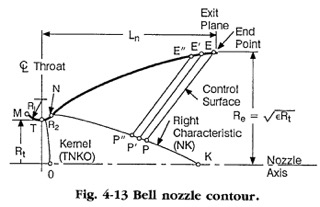       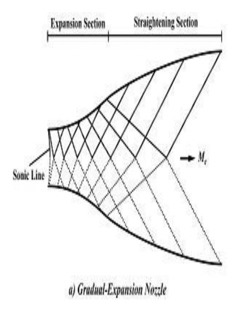

The first step in the Method of Characteristics is to identify the shape and properties of the kernel. Then, nozzle contour points can be chosen for the straightening section such that PM waves impinge directly on the points where compressions waves are generated due to concave flow turning, in effect, begin "absorbed". This ultimately prevents flow separation since the cancellation of PM and compression prevents the coalescence of the compressions in to a shock.

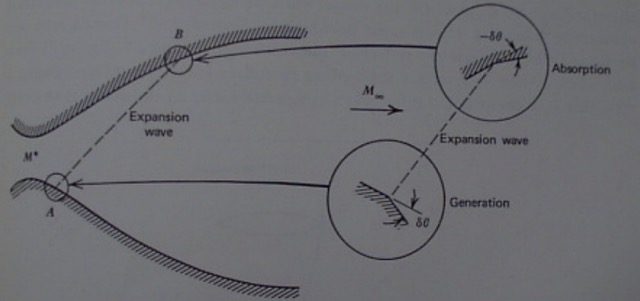

H&H provides a simplified procedure for how this is accomplished for typical gradual-expansion nozzles with Figure 4-13. Method of Characteristics can also be used to generate minimum length nozzles (also called Expansion-Deflection nozzles), which features no expanding section, meaning the nozzle is a lot shorter. This does mean that there's a sharp turn downstream of the throat which can lead to lower discharge coefficients and unwanted structural loads, but, the major benefit is that the engine is a lot lighter and shorter. 

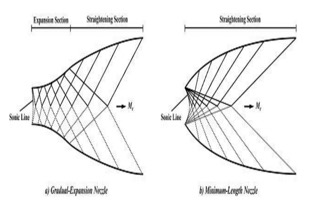

Luckily, nowadays, computer softwares can very easily accomplish this process and achieve a perfect contour. Even better, instead of having to worry about solving several hyperbolic PDEs, we have simple algebraic equations that directly generate the contours.

#### Conical Nozzles

One of the most simple types of De Laval nozzles is a conical nozzle. It features a a diverging section the maintains a constant slope throughout the expansion and has no flow straightening. For liquid rocket engines, they tend to be very long, which can add unwanted mass. But because of their simpler shape, a conical nozzle makes manufacturing a whole lot easier. 

The expanding section of a conical nozzle tends to be pretty arbitrary, being set by the *lead-out* radius from the throat, or the radius of curvature of the nozzle directly downstream of the throat, $R_{td}$. Because this nozzle is not implemented with the Method of Characteristics, the kernel region generated by the expanding section is not optimized in any way and is primarily just based on manufacturing capability and $C_d$ measurements. Therefore, we will just choose a value that's between 0.3 - 1.5, so for now, $\frac{R_{td}}{R_t} = 0.5$. 

The choice for the divergent cone half-angle, $\alpha$ is usually bit more intentional since it can contribute greatly to divergence loses. From experimentation, 12-18° usually works well. Making $\alpha$ less than 12° comes with diminishing returns on divergence losses due to added weight and length to reach the same $\epsilon$. Moreover, increasing the angle past 15° can severely reduce the thrust coefficient due to non-axial flow at the exit. We get excessive over expansion in the nozzle since the Prandtl-Meyer expansions produced in the kernel are not cancelled out, leading to imminent flow separation. This is why $\alpha = 15°$ is often used as an industry starting point for conical nozzles since it's a happy medium between all of the constraints. 

Let's plot what a conical contour would look like for a $\alpha = 15°$ and $\frac{R_{td}}{R_t} = 0.5$.

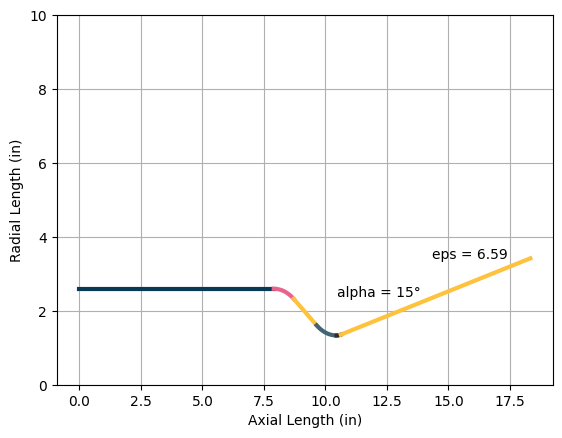

In [148]:
Pc = 400 # psi
Pe = 8 # psi
MR = 2.23

Rc = 1 * R_t # in
Rtc = 1 * R_t # in
theta_c = 37.5 # deg
Lc = 7.9 # cylindrical length
eps_c = 3.8
alpha = 15 # deg
Rtd = 0.5 * R_t # in
eps = rocket.get_eps_at_PcOvPe(Pc, MR, Pc/Pe, 1, 1)

# Chamber cylinder section
theta_c = np.deg2rad(theta_c)
f1z = np.linspace(0, Lc, 400)
f1r = np.ones(len(f1z))*np.sqrt(eps_c)*R_t
plt.figure
plt.ylim([0, 10])
plt.grid(True)
plt.plot(f1z, f1r, color='#083955', linewidth=3)

# Converging entrance arc
t = np.linspace(np.pi/2, np.pi/2 - theta_c, 400)
f2z = Rc*np.cos(t) + Lc
f2r = Rc*np.sin(t) + R_t*np.sqrt(eps_c) - Rc
inds = np.argsort(f2z)
f2z = f2z[inds]
f2r = f2r[inds]
plt.plot(f2z, f2r, linewidth=3, color='#ea638b')

# Converging linear section
y3 = R_t*(np.sqrt(eps_c)-1) - (Rc-Rc*np.cos(theta_c)) - (Rtc-Rtc*np.cos(theta_c))
x3 = y3 / (np.tan(theta_c))
f3z = np.linspace(f2z[-1], f2z[-1] + x3, 400)
m = -np.tan(theta_c)
f3r = m*(f3z - f2z[-1]) + f2r[-1]
plt.plot(f3z, f3r, linewidth=3, color='#ffc23d')

# Converging throat arc
t = np.linspace(np.pi + np.pi/2 - theta_c, 3*np.pi/2, 400)
h = f3z[-1] + Rtc*np.sin(theta_c)
k = R_t + Rtc
f4z = Rtc*np.cos(t) + h
f4r = Rtc*np.sin(t) + k
inds = np.argsort(f4z)
f4z = f4z[inds]
f4r = f4r[inds]
plt.plot(f4z, f4r, linewidth=3, color='#436475')

# Diverging Entrance Arc
alpha = np.deg2rad(alpha)
t = np.linspace(3*np.pi/2, 3*np.pi/2 + alpha, 400)
k = R_t + Rtd
f5z = Rtd*np.cos(t) + h
f5r = Rtd*np.sin(t) + k
inds = np.argsort(f5z)
f5z = f5z[inds]
f5r = f5r[inds]
plt.plot(f5z, f5r, linewidth=3, color='#2f2c2c')

# Conical Section
f6z = np.linspace(f5z[-1], f5z[-1] + ((np.sqrt(eps)*R_t - f5r[-1])/(np.tan(alpha))), 400)
m = np.tan(alpha)
f6r = m*(f6z - f5z[-1]) + f5r[-1]
plt.plot(f6z, f6r, linewidth=3, color='#ffc23d')
plt.xlabel("Axial Length (in)")
plt.ylabel("Radial Length (in)")
plt.annotate(f"eps = {eps:.2f}", (f6z[-1] - 4, f6r[-1]))
plt.annotate(f"alpha = {np.rad2deg(alpha):.0f}°", (f6z[200] - 4, f6r[200]));

As you can see, the contour generation of a concical nozzle is relatively simple. However, as simple as it is to generate and manufacture, conical nozzles come with a major downside: divergence losses. If you recall, divergence losses in a nozzle were caused by flow exiting the nozzle is such a way that the momentum outflux was not fully axial. As a result, only a fraction of the total momentum at the exit contributes to thrust. For a conical nozzle, since there is no flow straightening, a large portion of the exiting momentum is radial, meaning those components are effectively wasted energy. The fraction of the total momentum that actually contributes to thrust generation is given by $\lambda = \frac{1}{2}(1 + \cos{\alpha})$. In other words, this represents the $I_{sp}$ efficiency decrease due to increasing the conical half-angle. We can plot this relationship.

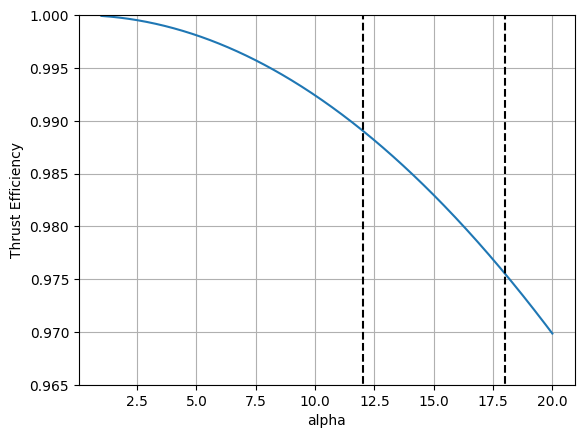

In [149]:
alpha = np.linspace(1, 20, 400) # °
lam = 0.5*(1 + np.cos(np.deg2rad(alpha)))
plt.Figure
plt.plot(alpha, lam)
plt.grid(True)
plt.xlabel('alpha')
plt.ylabel('Thrust Efficiency')
plt.ylim([0.965, 1])
plt.vlines(12, -100, 100, colors='k', linestyles='--')
plt.vlines(18, -100, 100, colors='k', linestyles='--');


We can see that as long as we keep $\lambda$ between 12°-18°, a range chosen for ease of manufacturing, the divergence losses due to radial flow are minimal. However, the rate of decrease of the nozzle efficiency rapidly grows after 18°. Going below 12° can help regain some losses, but by that point, the gains in efficiency as offset by the added weight. However, even if our radial-flow-related divergence losses are minimal within the optimal $\lambda$ range, the concern of flow separation poses a major risk. During transients like startup, the rapidly expanding nozzle can cause the boundary layer to detach by inducing a shock. As a result, very asymmetric side-loads can rattle and generate unwanted tension in the TCA. Therefore, many industry nozzles today are bell nozzles.

#### Bell Nozzles

The primary type of nozzle produced by the Method of Characteristics is the bell nozzle, which provides a quick expanding region in which the flow has a large radial component (the same region which defines the rocket's kernel) and a long straightening section which absorbs the Mach waves generated by those expansions.

Bell nozzles are designed with expanding and straigtening sections such that the PM waves generated by the convex turns are absorbed and also cancel out the compression Mach waves that are generated by the concave flow turning (compressive Mach waves tend to decrease stagnation pressure, which is horrible for thrust generation. If the concave flow turning is sharp, these mach waves can combine into a shock, which would not only decrease stagnation pressure, but would also detatch the boundary layer). Therefore, the use of Method of Characteristics allows bell nozzles to give shock-free supersonic flow.

Moreover, they have achieve the same expansion ratio as a conical nozzle but in a much shorter length. The biggest downside of this type of nozzle is the difficulty in manufacturing, especially with cooling channels, but even then, industry practices like additive manufacturing have made bell nozzles ubiquitous. Therefore, a bell nozzle will be the type of nozzle we will aim for in our design as well.

One of the primary geometric parameters of a bell nozzle is what fraction of the length (from throat to exit plane) of an equivalent 15° conical nozzle (same throat radius and $\epsilon$) the bell nozzle's length is, $L_f$ or *percent bell*. Let's observe how increasing $L_f$ with our set of engine parameters alters the nozzle efficiency (due to divergence losses) of a bell nozzle and conicall nozzle. For the conical curve, the conical half-angle is adjusted so that the bell and conical nozzle for a given $L_f$ have the same length.

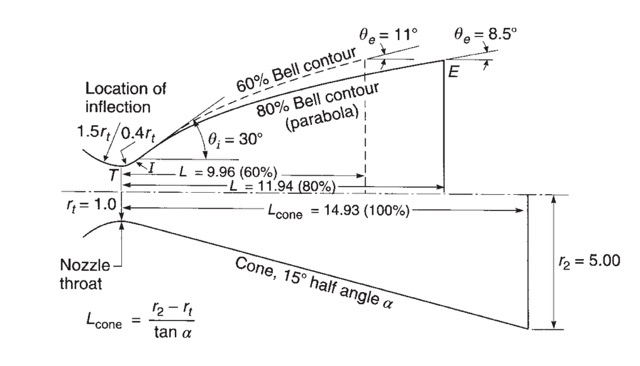

reading cea isp data files for N2O4 / MMH 200 times


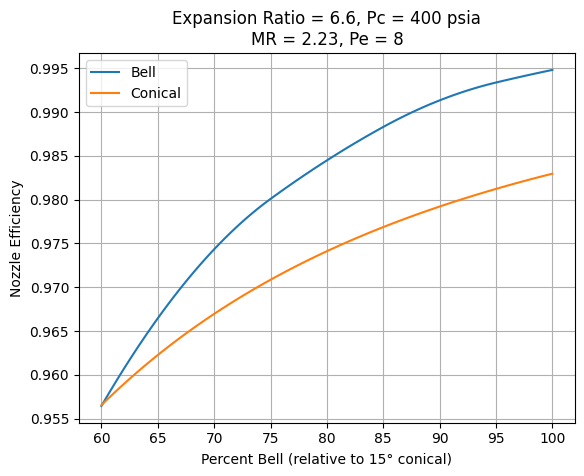

In [150]:
Rc_Rt = 1
Rtc_Rt = 1
theta_c = 37.5 # deg
eps_c = 3.8
Lc = 7.9 # cylindrical length, in
Rtd_Rt = 1
alpha = 15 # deg
Pc = 400 # psia
MR = 2.23
Pe = 8 # psia
eps = rocket.get_eps_at_PcOvPe(Pc, MR, Pc/Pe, 1, 1)
T = 3500 # lbf
G = Geometry(Rthrt=R_t, CR=eps_c, RupThroat=Rtc_Rt, 
             RchmConv=Rc_Rt, cham_conv_deg=theta_c, 
             LchamberInp=L_total, 
             RdwnThroat=Rtd_Rt, eps=eps, pcentBell=80) 
C = CoreStream(geomObj=G, effObj=Efficiencies(),
                oxName='N2O4', fuelName='MMH',  MRcore=MR, 
                Pc=Pc, pcentFFC=0.0, CdThroat=1)
R = RocketThruster(name = 'Fullscale', coreObj=C)
#R.summ_print()
Lf = np.linspace(60, 100, 100) # percent bell
div_eff = np.zeros((2, len(Lf)))
for i, l in enumerate(Lf):
    G.reset_attr('pcentBell', l)
    E = Efficiencies()
    C = CoreStream(geomObj=G, effObj=E,
                oxName='N2O4', fuelName='MMH',  MRcore=MR, 
                Pc=Pc, pcentFFC=0.0, CdThroat=1)
    R = RocketThruster(name = 'Fullscale', coreObj=C)
    div_eff[0, i] = float(E.get_state_str_list()[0].split('|')[1])
    al = np.rad2deg(np.arctan(np.tan(np.deg2rad(15))/(l/100)))
    div_eff[1, i] = 0.5*(1 + np.cos(np.deg2rad(al)))

plt.figure
plt.plot(Lf, div_eff[0, :], label = 'Bell')
plt.grid(True)
plt.xlabel('Percent Bell (relative to 15° conical)')
plt.ylabel('Nozzle Efficiency')
plt.plot(Lf, div_eff[1, :], label = 'Conical')
plt.legend()
plt.title(f'Expansion Ratio = {eps:.1f}, Pc = {Pc} psia\nMR = {MR}, Pe = {Pe}');

We can pretty clearly see that for the same length nozzle, the bell nozzle tends to be more efficient. A similar graph with more expansion ratios is presented in Figure 4-14 of H&H. We should notice that once we reach about 85% bell, we are already very close to 99% nozzle efficiency, and increasing the bell nozzle length after that comes with diminishing returns in performance and definitely greater weight. Even then, many engines have 100 % bell engines to achieve maximum efficiency. But below around 75%, we start to dip below 98% efficiency and the efficiency decreases faster after that. Therefore, a happy medium of 80% bell is often used as a starting point for design. 

In the past, bell nozzles may have been done with Method of Characteristics, and while computer programs still do this automatically now, we can get a near-perfect parabolic approximation of a bell-nozzle using a Rao curve, which appends a parabola at the end of our expanding section. Engines that are created exclusively by using Rao curves are said to have Thrust Optimized Parabolic Nozzles (TOP). In many cases, a TOP nozzles is actually better than one that is generated purely by Method of Characteristics due to delayed flow separation.

It's a commonly held belief that, to define a Rao curve (also called a Bézier curve because it is a parametric curve that can be scaled with no reliance on absolute dimensions), you need three extra characteristics: $L_f$, percent bell, $\theta_n$, the entrance angle (the angle at the start of the parabola), and $\theta_e$, the exit angle (the angle at the end of the parabola). If you read H&H or Sutton and immediately try to implement a parabolic contour using these parameters, you'll notice that the nozzle is actually *overdefined*: you physically cannot meet two of the parameters and also meet the third. So what's the solution? The misunderstanding comes from the fact that the parabola can actually be *rotated*, meaning the parabola's axis does not need to be aligned with the x or y axes. Now, because the parabola can no longer be defined as regular function, it must be defined parametrically (this actually a flaw in our current engine code and it needs to be fixed ASAP). For a canted parabola nozzle, it is very difficult to solve for $\theta_e$ given a $\theta_n$ value without using Method of Charcateristics. Therefore, it is best to interpolate from the chart that Rao put forth in his original paper *Approximation of Optimum Thrust Nozzle Contour* in Figure 2.

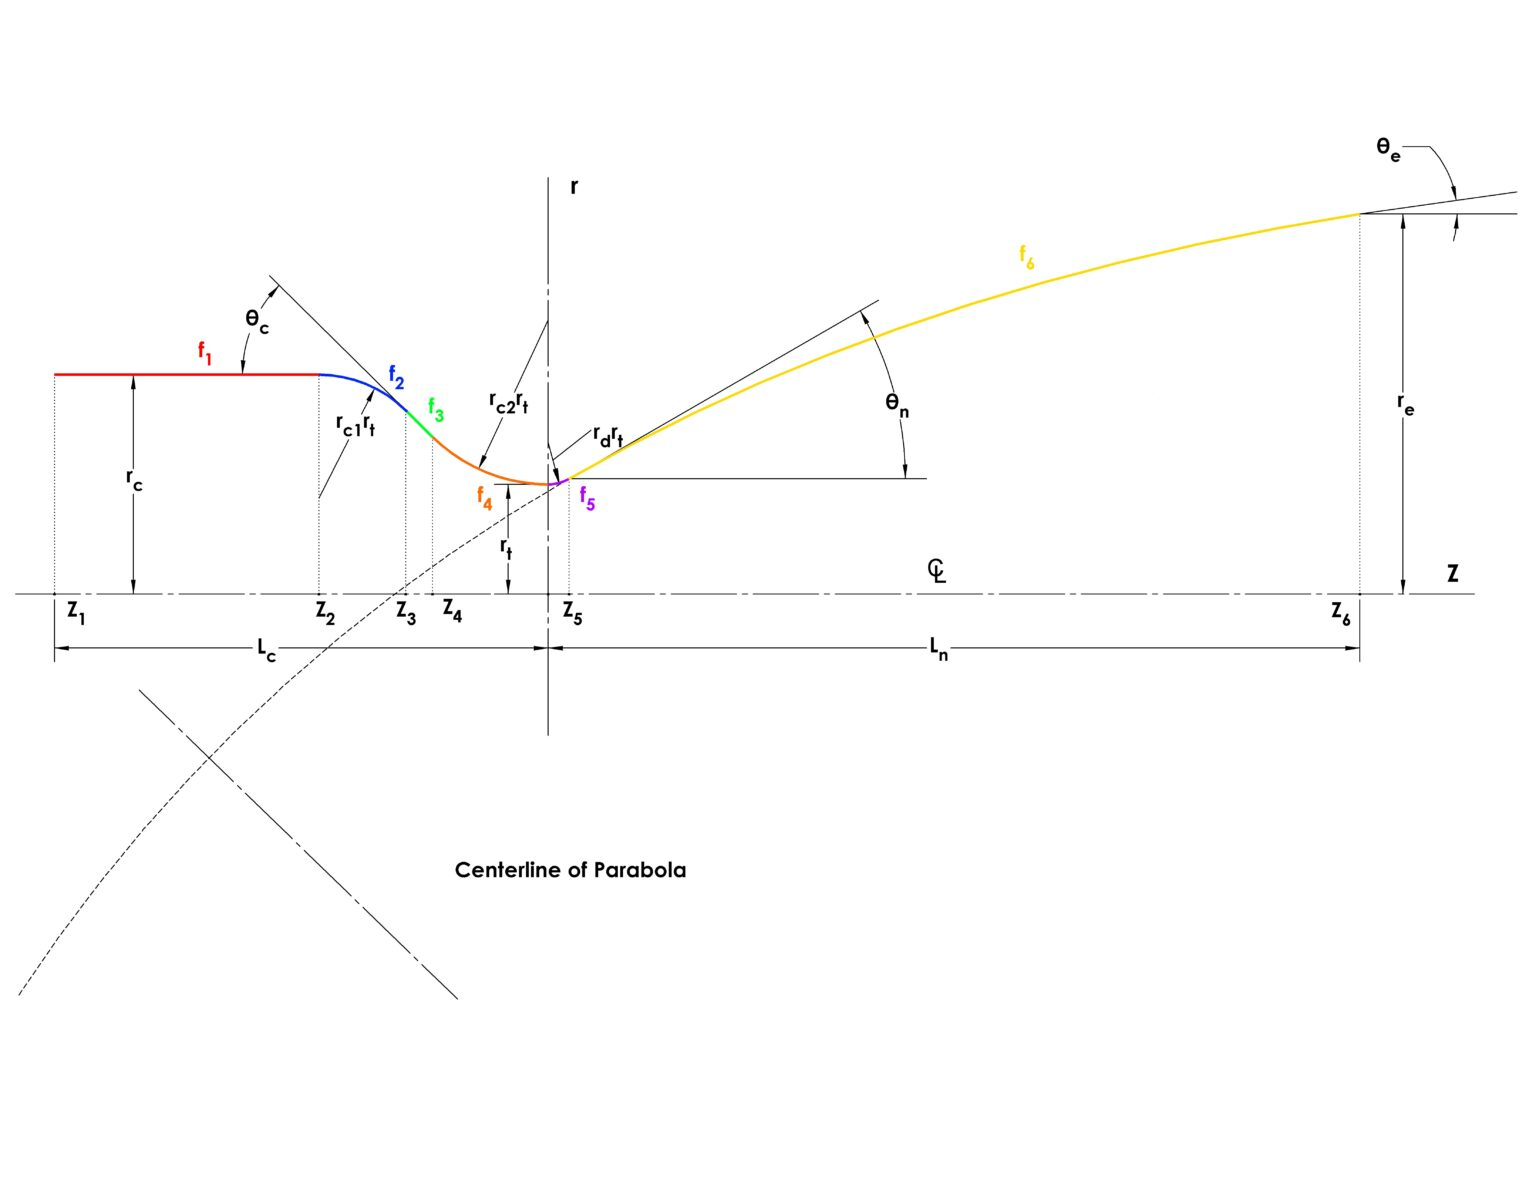

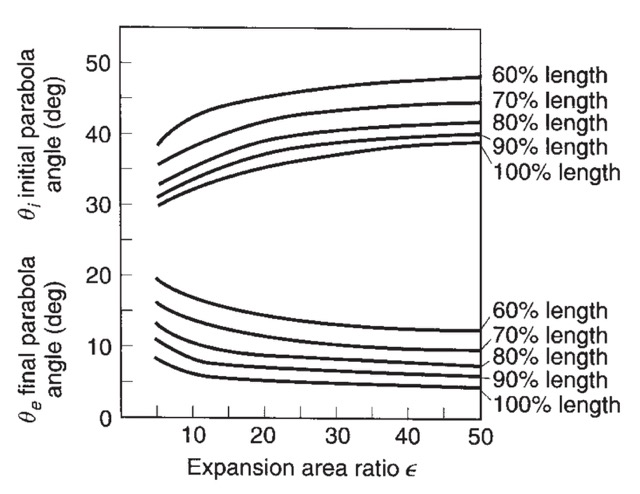

It is true that the mixture ratio would change the angles as well, however, Rao states, "The values of $\theta_n$ and $\theta_e$ shown in Fig. 2 are the results of calculations using $\gamma$ = 1.23... A different value of $\gamma$ does not appear to appreciably change the nozzle contour when the area ratio and length are prescribed..."(Rao). So, this is the best we can do without Method of Characteristics. 

I have already digitized the plot data to be used for interpolation (probably best if you just keep the sections closed while you run the code, the arrays are quite lengthy)

##### Load $\theta_i$ Data

In [151]:
theta_e_data = np.array([[100.        ,   4.85262706,   8.53719685],
                     [100.        ,   5.40328502,   8.30694507],
                     [100.        ,   5.99817715,   7.95418538],
                     [100.        ,   6.64179795,   7.66102291],
                     [100.        ,   7.24438868,   7.42482043],
                     [100.        ,   7.76246974,   7.08921409],
                     [100.        ,   8.39917929,   6.85037437],
                     [100.        ,   8.99393682,   6.62285346],
                     [100.        ,   9.59596228,   6.41827191],
                     [100.        ,  10.17255003,   6.22960746],
                     [100.        ,  10.7788151 ,   6.06575496],
                     [100.        ,  11.41475748,   5.95592413],
                     [100.        ,  12.02526216,   5.79922156],
                     [100.        ,  12.62728761,   5.77518986],
                     [100.        ,  13.24627153,   5.67469366],
                     [100.        ,  13.83981775,   5.63060244],
                     [100.        ,  14.44608282,   5.58412792],
                     [100.        ,  15.05234788,   5.50064589],
                     [100.        ,  15.65861295,   5.46277776],
                     [100.        ,  16.26487802,   5.43437666],
                     [100.        ,  16.87114309,   5.40855748],
                     [100.        ,  17.47740815,   5.37499254],
                     [100.        ,  18.08367322,   5.30786267],
                     [100.        ,  18.68993829,   5.29237116],
                     [100.        ,  19.29620336,   5.26138814],
                     [100.        ,  19.90246842,   5.24331471],
                     [100.        ,  20.50873349,   5.24847855],
                     [100.        ,  21.12771741,   5.15473506],
                     [100.        ,  21.72126363,   5.12196456],
                     [100.        ,  22.32752869,   5.12196456],
                     [100.        ,  22.93379376,   5.12196456],
                     [100.        ,  23.54005883,   5.0858177 ],
                     [100.        ,  24.1463239 ,   5.06774428],
                     [100.        ,  24.75258896,   5.0703262 ],
                     [100.        ,  25.35885403,   5.07290811],
                     [100.        ,  25.95240025,   4.97340496],
                     [100.        ,  26.57138417,   4.99545057],
                     [100.        ,  27.17764924,   4.9851229 ],
                     [100.        ,  27.7839143 ,   4.95155796],
                     [100.        ,  28.39017937,   4.94123029],
                     [100.        ,  28.99644444,   4.92315686],
                     [100.        ,  29.60270951,   4.94897604],
                     [100.        ,  30.20897457,   4.93348453],
                     [100.        ,  30.81523964,   4.92315686],
                     [100.        ,  31.42150471,   4.85086315],
                     [100.        ,  32.02776978,   4.81471629],
                     [100.        ,  32.63403484,   4.82246205],
                     [100.        ,  33.24029991,   4.80955246],
                     [100.        ,  33.84656498,   4.79922479],
                     [100.        ,  34.45283005,   4.72693108],
                     [100.        ,  35.05909511,   4.71143957],
                     [100.        ,  35.66536018,   4.72434916],
                     [100.        ,  36.27162525,   4.71918532],
                     [100.        ,  36.87789032,   4.69336614],
                     [100.        ,  37.48415538,   4.63656394],
                     [100.        ,  38.09042045,   4.63914586],
                     [100.        ,  38.69668552,   4.62623627],
                     [100.        ,  39.30295059,   4.61074476],
                     [100.        ,  39.92102601,   4.50728361],
                     [100.        ,  40.51548072,   4.49972228],
                     [100.        ,  41.12174579,   4.49714036],
                     [100.        ,  41.72801086,   4.49714036],
                     [100.        ,  42.33427592,   4.49714036],
                     [100.        ,  42.94054099,   4.47648501],
                     [100.        ,  43.54680606,   4.44550199],
                     [100.        ,  44.15307113,   4.44033816],
                     [100.        ,  44.75933619,   4.44033816],
                     [100.        ,  45.36560126,   4.4325924 ],
                     [100.        ,  45.97186633,   4.44033816],
                     [100.        ,  46.5781314 ,   4.38611787],
                     [100.        ,  47.18439646,   4.38095404],
                     [100.        ,  47.79066153,   4.37062637],
                     [100.        ,  48.3969266 ,   4.33447951],
                     [100.        ,  49.00319167,   4.32673376],
                     [100.        ,  49.60945673,   4.2905869 ],
                     [100.        ,  49.94014677,   4.26993156],
                    [90.        ,  4.80830541, 11.27174943],
                    [90.        ,  5.38602373, 10.98788408],
                    [90.        ,  6.02321305, 10.54156272],
                    [90.        ,  6.56463694, 10.19014087],
                    [90.        ,  7.16302843,  9.89132073],
                    [90.        ,  7.75305426,  9.53833563],
                    [90.        ,  8.4079277 ,  9.18332187],
                    [90.        ,  8.96765121,  8.92013835],
                    [90.        ,  9.58861361,  8.67020867],
                    [90.        , 10.20646696,  8.46237087],
                    [90.        , 10.85573385,  8.23391367],
                    [90.        , 11.39113676,  8.05539247],
                    [90.        , 12.02102255,  7.98810891],
                    [90.        , 12.57584694,  7.8579372 ],
                    [90.        , 13.27170922,  7.78948327],
                    [90.        , 13.80166121,  7.70864937],
                    [90.        , 14.44608282,  7.6832274 ],
                    [90.        , 15.04810827,  7.57319797],
                    [90.        , 15.65861295,  7.56187725],
                    [90.        , 16.26487802,  7.51023889],
                    [90.        , 16.9008204 ,  7.43774657],
                    [90.        , 17.47740815,  7.39405257],
                    [90.        , 18.08367322,  7.39147065],
                    [90.        , 18.68993829,  7.3424142 ],
                    [90.        , 19.29620336,  7.33725037],
                    [90.        , 19.89822881,  7.23020007],
                    [90.        , 20.50873349,  7.22364597],
                    [90.        , 21.11499856,  7.22364597],
                    [90.        , 21.69764291,  7.09989832],
                    [90.        , 22.32752869,  7.13844267],
                    [90.        , 22.93379376,  7.13844267],
                    [90.        , 23.51886075,  7.04231587],
                    [90.        , 24.1463239 ,  7.05323937],
                    [90.        , 24.75258896,  7.05323937],
                    [90.        , 25.36309365,  6.95711257],
                    [90.        , 25.9651191 ,  6.93963497],
                    [90.        , 26.57138417,  6.93963497],
                    [90.        , 27.17764924,  6.93963497],
                    [90.        , 27.7839143 ,  6.89316044],
                    [90.        , 28.39017937,  6.88283277],
                    [90.        , 28.99644444,  6.90090619],
                    [90.        , 29.60270951,  6.90607003],
                    [90.        , 30.20897457,  6.87250509],
                    [90.        , 30.81523964,  6.83635824],
                    [90.        , 31.42150471,  6.84152207],
                    [90.        , 32.02776978,  6.77697412],
                    [90.        , 32.63403484,  6.74082727],
                    [90.        , 33.24029991,  6.74082727],
                    [90.        , 33.84656498,  6.74082727],
                    [90.        , 34.44548138,  6.57610088],
                    [90.        , 35.05909511,  6.64787821],
                    [90.        , 35.66536018,  6.65046013],
                    [90.        , 36.27162525,  6.61173136],
                    [90.        , 36.87789032,  6.57300258],
                    [90.        , 37.48415538,  6.56009299],
                    [90.        , 38.09042045,  6.54976532],
                    [90.        , 38.69668552,  6.5471834 ],
                    [90.        , 39.29835767,  6.44971599],
                    [90.        , 39.90921565,  6.42841516],
                    [90.        , 40.51548072,  6.44907051],
                    [90.        , 41.12174579,  6.42841516],
                    [90.        , 41.72801086,  6.39485023],
                    [90.        , 42.33427592,  6.37161296],
                    [90.        , 42.94054099,  6.37161296],
                    [90.        , 43.54680606,  6.37161296],
                    [90.        , 44.14883151,  6.26674736],
                    [90.        , 44.75933619,  6.25800856],
                    [90.        , 45.36560126,  6.24251705],
                    [90.        , 45.97186633,  6.27091815],
                    [90.        , 46.5781314 ,  6.27350007],
                    [90.        , 47.18439646,  6.22960746],
                    [90.        , 47.79066153,  6.22444363],
                    [90.        , 48.3969266 ,  6.20120636],
                    [90.        , 49.03286898,  6.13129596],
                    [90.        , 49.60945673,  6.09534772],
                    [90.        , 50.20837313,  6.06307183],
                    [90.        , 50.45822783,  5.72406788],
                    [80.        ,  4.84382397, 13.48924422],
                    [80.        ,  5.35859092, 13.17952372],
                    [80.        ,  5.78515328, 12.79634754],
                    [80.        ,  6.2925066 , 12.53820182],
                    [80.        ,  6.75294654, 12.21277255],
                    [80.        ,  7.31504895, 11.97099908],
                    [80.        ,  7.90806521, 11.59386525],
                    [80.        ,  8.46610465, 11.31971574],
                    [80.        ,  9.08720837, 11.13644368],
                    [80.        ,  9.68782062, 10.91578898],
                    [80.        , 10.31245736, 10.72214512],
                    [80.        , 10.94234314, 10.48165788],
                    [80.        , 11.48932484, 10.26924629],
                    [80.        , 12.12152638, 10.1305821 ],
                    [80.        , 12.77567417, 10.06812538],
                    [80.        , 13.34378269,  9.9811346 ],
                    [80.        , 13.92037045,  9.81688488],
                    [80.        , 14.55631283,  9.77974498],
                    [80.        , 15.1625779 ,  9.66355866],
                    [80.        , 15.76884296,  9.56802768],
                    [80.        , 16.37510803,  9.47766055],
                    [80.        , 16.9813731 ,  9.41053067],
                    [80.        , 17.58763817,  9.33565505],
                    [80.        , 18.18118439,  9.22264647],
                    [80.        , 18.8001683 ,  9.1762216 ],
                    [80.        , 19.44186444,  9.06160287],
                    [80.        , 20.01269844,  9.04131637],
                    [80.        , 20.6189635 ,  8.99742376],
                    [80.        , 21.26065965,  8.89119627],
                    [80.        , 21.83149364,  8.87090977],
                    [80.        , 22.43775871,  8.84767251],
                    [80.        , 23.04402377,  8.81410757],
                    [80.        , 23.62909076,  8.69831847],
                    [80.        , 24.25655391,  8.72632235],
                    [80.        , 24.86281898,  8.67726591],
                    [80.        , 25.46908404,  8.66693824],
                    [80.        , 26.07534911,  8.61271795],
                    [80.        , 26.68161418,  8.58689877],
                    [80.        , 27.28787925,  8.51718698],
                    [80.        , 27.89414431,  8.50685931],
                    [80.        , 28.50040938,  8.47845821],
                    [80.        , 29.10667445,  8.45005711],
                    [80.        , 29.7359041 ,  8.437793  ],
                    [80.        , 30.31920459,  8.35968997],
                    [80.        , 30.92546965,  8.35968997],
                    [80.        , 31.53173472,  8.3493623 ],
                    [80.        , 32.13799979,  8.30288777],
                    [80.        , 32.74426486,  8.30288777],
                    [80.        , 33.32085261,  8.17180577],
                    [80.        , 33.95679499,  8.18928337],
                    [80.        , 34.6012166 ,  8.12592707],
                    [80.        , 35.14636054,  8.06384518],
                    [80.        , 35.77559019,  8.07567897],
                    [80.        , 36.38185526,  8.06793322],
                    [80.        , 36.98812033,  8.02145869],
                    [80.        , 37.5943854 ,  8.01887677],
                    [80.        , 38.23880701,  7.95552047],
                    [80.        , 38.80691553,  7.90785429],
                    [80.        , 39.4131806 ,  7.90269045],
                    [80.        , 40.01944567,  7.90010853],
                    [80.        , 40.62571073,  7.85105209],
                    [80.        , 41.2319758 ,  7.84847017],
                    [80.        , 41.83824087,  7.84847017],
                    [80.        , 42.41482863,  7.71738817],
                    [80.        , 43.050771  ,  7.72970193],
                    [80.        , 43.65703607,  7.7245381 ],
                    [80.        , 44.26330114,  7.68839124],
                    [80.        , 44.86956621,  7.62384329],
                    [80.        , 45.47583127,  7.6264252 ],
                    [80.        , 46.08209634,  7.65740822],
                    [80.        , 46.66998974,  7.57155944],
                    [80.        , 47.29462648,  7.60576986],
                    [80.        , 47.90089154,  7.56445917],
                    [80.        , 48.50715661,  7.53605807],
                    [80.        , 49.11342168,  7.50765697],
                    [80.        , 49.71968675,  7.49474738],
                    [80.        , 50.20194305,  7.23784652],
                    [70.        ,  4.84958763, 16.59433835],
                    [70.        ,  5.35859092, 16.28526755],
                    [70.        ,  5.77727971, 15.8981534 ],
                    [70.        ,  6.30851426, 15.64707813],
                    [70.        ,  6.89226503, 15.28482488],
                    [70.        ,  7.48846942, 14.98390846],
                    [70.        ,  8.1117939 , 14.78848184],
                    [70.        ,  8.71412218, 14.52678599],
                    [70.        ,  9.32038725, 14.26534372],
                    [70.        ,  9.92665231, 14.13285905],
                    [70.        , 10.52867776, 13.88042689],
                    [70.        , 11.18132922, 13.60323313],
                    [70.        , 11.76664559, 13.46424154],
                    [70.        , 12.32599225, 13.3336693 ],
                    [70.        , 12.95797765, 13.17476879],
                    [70.        , 13.52608618, 13.03057859],
                    [70.        , 14.17050779, 12.90902982],
                    [70.        , 14.7894917 , 12.75749109],
                    [70.        , 15.37568925, 12.56873301],
                    [70.        , 15.98471007, 12.47311597],
                    [70.        , 16.61676614, 12.32273579],
                    [70.        , 17.20183312, 12.2532226 ],
                    [70.        , 17.80809819, 12.13703628],
                    [70.        , 18.4525198 , 11.99284608],
                    [70.        , 19.02062833, 11.92015516],
                    [70.        , 19.60327268, 11.74753548],
                    [70.        , 20.23315846, 11.72651129],
                    [70.        , 20.7921821 , 11.56089968],
                    [70.        , 21.4456886 , 11.5431951 ],
                    [70.        , 22.05619328, 11.41171588],
                    [70.        , 22.65821873, 11.33405973],
                    [70.        , 23.2644838 , 11.27983945],
                    [70.        , 23.88346771, 11.16921418],
                    [70.        , 24.47701393, 11.12492435],
                    [70.        , 25.09705775, 11.03649366],
                    [70.        , 25.68954407, 10.97259118],
                    [70.        , 26.29580914, 10.94935392],
                    [70.        , 26.9020742 , 10.87964213],
                    [70.        , 27.50833927, 10.80734842],
                    [70.        , 28.11460434, 10.75829197],
                    [70.        , 28.72086941, 10.72730895],
                    [70.        , 29.3059364 , 10.62303918],
                    [70.        , 29.93339954, 10.63177798],
                    [70.        , 30.53966461, 10.5775577 ],
                    [70.        , 31.18408622, 10.51161948],
                    [70.        , 31.75219474, 10.4639533 ],
                    [70.        , 32.37117866, 10.37835278],
                    [70.        , 32.96472488, 10.37616808],
                    [70.        , 33.57098995, 10.35551273],
                    [70.        , 34.17725501, 10.29871053],
                    [70.        , 34.78352008, 10.29612861],
                    [70.        , 35.38978515, 10.1799423 ],
                    [70.        , 35.99605022, 10.17736038],
                    [70.        , 36.60231529, 10.16961462],
                    [70.        , 37.20858035, 10.12572201],
                    [70.        , 37.81484542, 10.12055818],
                    [70.        , 38.42111049, 10.12572201],
                    [70.        , 39.02737556, 10.05859214],
                    [70.        , 39.63364062, 10.00695378],
                    [70.        , 40.23990569, 10.00695378],
                    [70.        , 40.84617076,  9.99920802],
                    [70.        , 41.45243583, 10.00695378],
                    [70.        , 42.05870089,  9.98371651],
                    [70.        , 42.66496596,  9.95015158],
                    [70.        , 43.27123103,  9.95015158],
                    [70.        , 43.8774961 ,  9.95015158],
                    [70.        , 44.48376116,  9.90884089],
                    [70.        , 45.09002623,  9.89334938],
                    [70.        , 45.6962913 ,  9.90109513],
                    [70.        , 46.30255637,  9.95531541],
                    [70.        , 46.90882143,  9.95015158],
                    [70.        , 47.5150865 ,  9.94240582],
                    [70.        , 48.12135157,  9.93466007],
                    [70.        , 48.72761664,  9.91916856],
                    [70.        , 49.3338817 ,  9.93207815],
                    [70.        , 49.82991676,  9.89334938],
                    [60.        ,  4.95405398, 20.00414101],
                    [60.        ,  5.4657815 , 19.65090233],
                    [60.        ,  5.85662109, 19.25478891],
                    [60.        ,  6.36989725, 19.03092998],
                    [60.        ,  6.80084411, 18.67740391],
                    [60.        ,  7.36931603, 18.44965413],
                    [60.        ,  7.98790092, 18.097926  ],
                    [60.        ,  8.54188778, 17.81903137],
                    [60.        ,  9.14769356, 17.59572772],
                    [60.        ,  9.76130729, 17.34686308],
                    [60.        , 10.38029121, 17.1443687 ],
                    [60.        , 10.95762713, 16.86331347],
                    [60.        , 11.60130058, 16.6965052 ],
                    [60.        , 12.22179864, 16.514863  ],
                    [60.        , 12.82707951, 16.30489772],
                    [60.        , 13.3988977 , 16.24228621],
                    [60.        , 14.04059384, 16.00567185],
                    [60.        , 14.63347384, 15.82539248],
                    [60.        , 15.2176929 , 15.75172175],
                    [60.        , 15.82395797, 15.60713433],
                    [60.        , 16.45318762, 15.44576445],
                    [60.        , 16.99833156, 15.307036  ],
                    [60.        , 17.61913246, 15.1516102 ],
                    [60.        , 18.24477862, 15.0164709 ],
                    [60.        , 18.85528331, 14.97456438],
                    [60.        , 19.46154838, 14.82997696],
                    [60.        , 20.05403469, 14.70260233],
                    [60.        , 20.69527659, 14.58608499],
                    [60.        , 21.28034358, 14.52531061],
                    [60.        , 21.87742281, 14.3972905 ],
                    [60.        , 22.49287371, 14.34715826],
                    [60.        , 23.09913878, 14.25679112],
                    [60.        , 23.70540385, 14.17675166],
                    [60.        , 24.31166892, 14.1122037 ],
                    [60.        , 24.91793398, 14.02183656],
                    [60.        , 25.57144048, 13.89587584],
                    [60.        , 26.13046412, 13.86950339],
                    [60.        , 26.72098204, 13.72749789],
                    [60.        , 27.29575282, 13.66460974],
                    [60.        , 27.94501971, 13.61607819],
                    [60.        , 28.55552439, 13.58549239],
                    [60.        , 29.16178946, 13.57000088],
                    [60.        , 29.76805452, 13.53127211],
                    [60.        , 30.36697092, 13.39236491],
                    [60.        , 30.98058466, 13.41250387],
                    [60.        , 31.58684973, 13.36344743],
                    [60.        , 32.21431287, 13.27963439],
                    [60.        , 32.79937986, 13.24467919],
                    [60.        , 33.40564493, 13.22660576],
                    [60.        , 34.01191   , 13.18787699],
                    [60.        , 34.66961574, 13.08752643],
                    [60.        , 35.22444013, 13.07685451],
                    [60.        , 35.8307052 , 13.07427259],
                    [60.        , 36.43697027, 13.03812573],
                    [60.        , 37.04323533, 13.01747039],
                    [60.        , 37.6495004 , 13.01747039],
                    [60.        , 38.24304662, 12.90386599],
                    [60.        , 38.86203054, 12.90386599],
                    [60.        , 39.4682956 , 12.90386599],
                    [60.        , 40.07456067, 12.90386599],
                    [60.        , 40.68082574, 12.85997338],
                    [60.        , 41.28709081, 12.84706379],
                    [60.        , 41.89335587, 12.84706379],
                    [60.        , 42.49962094, 12.84706379],
                    [60.        , 43.10588601, 12.84706379],
                    [60.        , 43.71215108, 12.81349885],
                    [60.        , 44.31841614, 12.79542542],
                    [60.        , 44.92468121, 12.79800734],
                    [60.        , 45.53094628, 12.79026159],
                    [60.        , 46.13721135, 12.83157228],
                    [60.        , 46.74347642, 12.84706379],
                    [60.        , 47.34974148, 12.84706379],
                    [60.        , 47.95600655, 12.84706379],
                    [60.        , 48.56227162, 12.8057531 ],
                    [60.        , 49.16853669, 12.80317118],
                    [60.        , 49.77480175, 12.79800734]])

##### Load $\theta_n$ Data

In [152]:
data = """
5.080835590089951, 20.017195648039717
5.669237812102082, 20.290523751613968
6.273042388304617, 20.63843722787737
6.855691192313262, 20.943845437809944
7.47122711325272, 21.292092849948
8.097715753018413, 21.476158304056693
8.662245543292073, 21.75197025447003
9.259840873511724, 22.020995355773756
9.886266473237718, 22.304204780896068
10.490222801669407, 22.53738743165371
11.114247265931375, 22.731765370773118
11.660215079804875, 22.979900170693792
12.278963460709644, 23.25347316057612
12.90587618801516, 23.487482700166243
13.510372859644306, 23.666090687980606
14.110962434307218, 23.811114267829876
14.719693683628336, 23.990231110310383
15.323371653443154, 24.25152798137214
15.927991130344452, 24.417732636699395
16.53738568557783, 24.565539015504108
17.137626569739993, 24.710096902466958
17.751356735867255, 24.883891216006564
18.328353213553044, 25.05671098199361
18.951088514850937, 25.248755913335682
19.552259997572655, 25.335006779246037
20.160966056068716, 25.51666789505723
20.765831143514312, 25.658065885410267
21.370794475177625, 25.78954120977362
21.975880612113095, 25.908613201649864
22.58086850483084, 26.037607859515795
23.19396809512498, 26.089536478195157
23.790893412375198, 26.29063584225281
24.39600411036509, 26.407227167631632
25.001016564137267, 26.53374115900014
25.611024358518108, 26.58392695044798
26.21150813171579, 26.739636478286148
26.81661882970569, 26.85622780366497
27.42197513823988, 26.948012464069574
28.027282324665215, 27.044758457469023
28.623467126124375, 27.1350960624168
29.231042525926306, 27.188306358786495
29.87302289333102, 27.32068490018224
30.44829002087669, 27.45406842954361
31.05376913468303, 27.533449757461103
31.659174565326083, 27.620273084870867
32.28793960548653, 27.667199026113764
32.8474649864545, 27.74906102052868
33.475980322561576, 27.82120707116203
34.081434875313484, 27.903069065576947
34.68698767228312, 27.975008394002177
35.29246678608946, 28.054389721919673
35.898142388331244, 28.113925717857796
36.50406360111734, 28.1486550488217
37.109640959141394, 28.218113710749506
37.71531656138318, 28.27764970668763
38.32096760257053, 28.339666369123172
38.93146095010434, 28.34081129212198
39.53261353970726, 28.428970363030356
40.13824001984019, 28.49346769196332
40.74408754946298, 28.53563902241949
41.34998420119463, 28.572849019880817
41.955561559218694, 28.642307681808628
42.561261722514914, 28.699363011249325
43.16715837424657, 28.73657300871065
43.77325151441366, 28.753937674192603
44.37934465458075, 28.771302339674556
44.98521674525797, 28.810993003633303
45.59069585906432, 28.8903743315508
46.196641632904836, 28.922622996017285
46.80258740674534, 28.954871660483764
47.40865598585801, 28.97471699246314
48.01425790493651, 29.04169498789353
48.62037560615803, 29.05657898687806
49.226321379998545, 29.088827651344538
49.85491186123644, 28.82203787589563
"""
array_data = np.array([list(map(float, line.split(','))) for line in data.strip().split('\n')])

ones_column = np.full((array_data.shape[0], 1), 100)
theta_n_data100 = np.hstack((ones_column, array_data))

data = """5.084924186950719, 21.231411931011067
5.6506056207754405, 21.47654812307771
6.2535064086536565, 21.816340369736462
6.855923577674403, 22.2049781209992
7.45943780712636, 22.48281276871043
8.08076698805814, 22.816875857029896
8.69572603910381, 23.080653394589074
9.265064191087156, 23.34897882072686
9.882406294183156, 23.62185213544325
10.476863477371413, 23.88667918575134
11.093855742884443, 24.194886096347677
11.713293407739815, 24.470208274144856
12.291626888465455, 24.722091333883064
12.895012978117602, 24.91211487747968
13.494850273244598, 25.23387191435115
14.06120929527972, 25.410571697167498
14.712421564762543, 25.65248438579107
15.307161357519405, 25.888767869670488
15.912249131858502, 26.00767448378024
16.478268329663614, 26.21869651382758
17.12493444243706, 26.42020296161815
17.720467116412564, 26.612088875877046
18.329521910392998, 26.794211141229425
18.930324977298262, 26.91767200460111
19.539059690357824, 27.096439009498642
20.143625951641198, 27.26801844223698
20.737315759321184, 27.345273484585256
21.35347893180454, 27.53841109045595
21.981636085867834, 27.646733527510033
22.525914090199834, 27.734192923252465
23.168712781556508, 27.8981077325821
23.773872601655263, 28.00973772496608
24.378983299645157, 28.126329050344903
24.997672482111042, 28.156097048313963
25.577294473538316, 28.27784052718743
26.16576978043164, 28.361801547100168
26.782180137885867, 28.47899713739503
27.405838525479425, 28.577810352875662
28.00750878653725, 28.613684606838373
28.616551142547813, 28.761379673684868
29.22185832897315, 28.85812566708432
29.827460248051644, 28.925103662514704
30.429264650252897, 28.9474296609915
31.038811452535214, 29.044175654390948
31.64470810426686, 29.081385651852273
32.250138095964346, 29.165728312764614
32.85578913715171, 29.227744975200157
33.461219128849194, 29.312087636112498
34.06726314690742, 29.33441363458929
34.67323348180236, 29.364181632558353
35.27881083982643, 29.433640294486164
35.88453556417707, 29.48821495742944
36.49048133801759, 29.520463621895924
37.11496047418001, 29.536381231921048
37.701930786718876, 29.62961294778248
38.30792568266825, 29.65690027925412
38.91409250599863, 29.666822945243805
39.5061817516316, 29.70692705361879
40.12576300418979, 29.753646272653565
40.731438606431574, 29.81318226859169
41.337556307653095, 29.82806626757622
41.94340383727589, 29.87023759803239
42.55896321717118, 29.859281321002108
43.15514801863034, 29.949618925949885
43.76133940301515, 29.95706092544215
44.36733429896452, 29.98434825691379
44.97345200018604, 29.999232255898317
45.57890655293796, 30.081094250313235
46.1851961815405, 30.078613583815816
46.79077353956455, 30.148072245743624
47.397038607112655, 30.148072245743624
48.002640526191165, 30.215050241174012
48.60875822741267, 30.229934240158542
49.21467944019876, 30.264663571122444
49.57300066327684, 30.257221571630183
"""
array_data = np.array([list(map(float, line.split(','))) for line in data.strip().split('\n')])

ones_column = np.full((array_data.shape[0], 1), 90)
theta_n_data90 = np.hstack((ones_column, array_data))

data = """5.072800236457752, 22.777081831967088
5.621366781952272, 23.03801693916464
6.23075796004067, 23.37171826361989
6.848893853024361, 23.71021111354189
7.417028541455398, 23.982840791370144
8.051048112197943, 24.334051486853035
8.658231763181721, 24.612382267863754
9.285434003916333, 24.886733646368192
9.861389195232018, 25.164723335735516
10.476603696988022, 25.503378610249612
11.041217309732055, 25.80029076459578
11.671770111258216, 26.094854009456295
12.252290637188043, 26.30216364538789
12.862270869842657, 26.607016230923985
13.48762113622406, 26.891784023461348
14.09282670730655, 27.053367829430663
14.686135096258923, 27.379648434620957
15.269624509102982, 27.538983551955354
15.869688099338717, 27.708584812179083
16.4761467898659, 27.967359672301793
17.133476021443037, 28.126710691344506
17.69269411932892, 28.29058461056704
18.312427416509777, 28.520755023434962
18.90958559594747, 28.645319919698352
19.521764614530092, 28.843241668099786
20.11754211183662, 28.97471699246314
20.731666716802295, 29.108672983323913
21.33635987686688, 29.267435639158904
21.94144601380235, 29.38650763103515
22.569642056201836, 29.49090234613498
23.11393218361838, 29.57713731033702
23.778575098922644, 29.675791508734484
24.36223266052395, 29.81814360158653
24.946672397243255, 29.88149600752069
25.572896155483484, 30.006674255390585
26.178301586126544, 30.093497582800346
26.783805260987315, 30.170398244220422
27.389038764249356, 30.274586237112132
27.994665244382283, 30.339083566045097
28.600021552916473, 30.430868226449704
29.205107689851943, 30.549940218325947
29.81093065842031, 30.594592215279537
30.416753626988672, 30.63924421223313
31.022429229230454, 30.69878020817125
31.62817851463553, 30.75087420461711
32.23402604425832, 30.79304553507328
32.83957884122796, 30.864984863498506
33.445303565578605, 30.919559526441788
34.08975729414147, 30.91631557794516
34.65682669744318, 31.021266852836078
35.26262510495711, 31.06839951628709
35.86876736723306, 31.080802848774198
36.47446753052928, 31.1378581782149
37.080486987533085, 31.162664843189116
37.68623627293816, 31.214758839634975
38.29208380256095, 31.256930170091145
38.89837343116348, 31.254449503593722
39.50397535024198, 31.32142749902411
40.109872001973635, 31.358637496485436
40.715694970541996, 31.403289493439026
41.32151793911036, 31.44794149039262
41.92731634662429, 31.495074153843632
42.5291767984113, 31.47605571069673
43.139551749067344, 31.524842151812695
43.74554664501671, 31.552129483284332
44.3513941746395, 31.594300813740503
44.9572873176491, 31.63186519213003
45.56311379493952, 31.676162808155418
46.16928061826991, 31.686085474145106
46.774857976293966, 31.755544136072913
47.38109848278764, 31.758024802570336
47.98670040186614, 31.825002798000725
48.59286722519652, 31.834925463990412
49.19898492641804, 31.849809462974942
49.556790367353095, 31.894461459928532
"""

array_data = np.array([list(map(float, line.split(','))) for line in data.strip().split('\n')])

ones_column = np.full((array_data.shape[0], 1), 80)
theta_n_data80 = np.hstack((ones_column, array_data))

data = """5.003627096787689, 25.58860722348246
5.651834258283952, 25.80574823089011
6.205130682947885, 26.08377581932892
6.838033919654013, 26.44722791490256
7.410139165687806, 26.766148601477344
8.030112462037604, 27.059788378012225
8.633898307856189, 27.371586268504338
9.210111980653345, 27.65023190333973
9.826435744646439, 27.949492967171555
10.4470040144802, 28.21227684840263
11.03707467855154, 28.53811968891691
11.640547972912774, 28.820088780790517
12.220503472870355, 29.091662698770165
12.82024582610628, 29.352841442855855
13.444357657547574, 29.591410683722184
14.0630326071973, 29.8224434235154
14.651681199976842, 30.06426115622359
15.271647827174775, 30.270865237366
15.867448131174704, 30.532575552843994
16.472332867463848, 30.6719890099991
17.072292545546226, 30.880632144482245
17.719104135334362, 31.067445413788086
18.32374817329009, 31.23116940261792
18.889857806157153, 31.43305749140809
19.494379038840727, 31.60918481272503
20.099317809449623, 31.743140803585806
20.704281141112936, 31.874616127949157
21.309170789612963, 32.013533451804776
21.876525479008436, 32.08967083122565
22.51956411297376, 32.22935143708047
23.124650249909237, 32.34842342895671
23.72956445946369, 32.48486008631491
24.339534467606953, 32.53886228775878
24.931166972093116, 32.66078068542373
25.545363213467546, 32.78750139900036
26.150768644110606, 32.87432472641012
26.756272318971376, 32.95122538783019
27.357352957280227, 33.01096810597643
27.967377912910642, 33.09510404468065
28.56371417420545, 33.17014420622766
29.178139652087893, 33.27371203249502
29.77129289519418, 33.31340269645377
30.389294368136028, 33.412629356350635
30.995240141976538, 33.44487802081713
31.614874610152654, 33.48622246244082
32.2065913464601, 33.56395001269337
32.79149963252546, 33.5799789346767
33.41363208589122, 33.654494339849265
34.023986569001906, 33.70534800304641
34.62956392702597, 33.774806664974214
35.23523952926775, 33.83434266091234
35.84120986416269, 33.8641106588814
36.44700827167664, 33.91124332233241
37.05767543590333, 33.89483275934947
37.65897350252095, 33.96829865177311
38.26474734898045, 34.01791198172155
38.87086505020197, 34.03279598070608
39.47644240822604, 34.10225464263388
40.082461865229845, 34.1270613076081
40.688407639070356, 34.15930997207458
41.29445165712859, 34.18163597055138
41.9003974309691, 34.21388463501786
42.502256623214855, 34.23067683900041
43.11206792916026, 34.30070796242762
43.718234752490645, 34.310630628417314
44.32410684316787, 34.35032129237606
44.93024910544382, 34.36272462486317
45.53570365819573, 34.444586619278084
46.14189504258055, 34.452028618770356
46.747595205876756, 34.50908394821106
47.353811151316, 34.514045281205895
47.959855169374244, 34.53637127968269
48.566071114813475, 34.541332612677536
49.17651345092654, 34.54762968917099
49.58495575652061, 34.616372774224544
"""

array_data = np.array([list(map(float, line.split(','))) for line in data.strip().split('\n')])

ones_column = np.full((array_data.shape[0], 1), 70)
theta_n_data70 = np.hstack((ones_column, array_data))

data = """4.7441177246872215, 28.29556563139123
5.301466723332094, 28.906498663784042
5.901566966218287, 29.5291459546369
6.510975202389879, 30.090625232119123
7.109746562962709, 30.55450986713699
7.696386967819226, 30.96829732703819
8.308245041530935, 31.385747637492972
8.899476989406896, 31.711246520047528
9.497553779270437, 32.01830396429982
10.103469701983261, 32.28194156682581
10.690816003330358, 32.54594649881392
11.324561820653734, 32.90161205788176
11.92834826845895, 33.151952651913234
12.51160891712296, 33.33439295143195
13.136651855438675, 33.5788340116779
13.740804672305803, 33.79217133045617
14.345522393424822, 33.948453319793735
14.949969942945103, 34.13202264060294
15.554663103009695, 34.29078529643794
16.155600311058386, 34.4006979043237
16.777493766471437, 34.535035536184076
17.36984291844192, 34.655939404858415
17.973951525411074, 34.87374192333205
18.614944169562044, 34.94479529943678
19.1841974824453, 35.10444390759227
19.789332741489623, 35.21855456647367
20.394320634207368, 35.3475492243396
20.99967694274156, 35.4393338847442
21.605338510095102, 35.50028740439514
22.21021763242895, 35.64026787103536
22.78640107623604, 35.68110345799292
23.3830023135219, 35.800747911368575
24.047666011256837, 35.897303084268216
24.631421817075854, 36.029732511130575
25.23707285826321, 36.09174917356613
25.842257239416398, 36.200898499452684
26.466439596171128, 36.246790829654984
27.053362833355663, 36.344777156303145
27.659210362978456, 36.38694848675931
28.26454211045823, 36.48121381366134
28.870045785319, 36.55811447508141
29.498462877208347, 36.640183191704445
30.081028573986117, 36.71439646441898
30.686483126738032, 36.7962584588339
31.292379778469687, 36.83346845629522
31.8685518864055, 36.8754489662516
32.50363273873554, 36.96246311416115
33.10952939046719, 36.999673111622485
33.715033065327965, 37.076573773042554
34.32085603389633, 37.121225769996144
34.926826368791275, 37.150993767965204
35.53257565419635, 37.203087764411066
36.138153012220414, 37.27254642633888
36.74417246922421, 37.29735309131309
37.349921754629285, 37.349447087758946
37.955646478979936, 37.40402175070223
38.56161681387488, 37.43378974867129
39.16756258771539, 37.46603841313777
39.7737539721002, 37.47348041263004
40.379331330124266, 37.54293907455784
40.98515429869263, 37.58759107151143
41.59105095042428, 37.62480106897276
42.19680023582936, 37.67689506541862
42.841384326911886, 37.66048450243568
43.408544417183805, 37.756276393336115
44.01483404578633, 37.75379572683869
44.62075525857242, 37.788525057802595
45.2266764713585, 37.8232543887665
45.83198365778384, 37.92000038216595
46.456886472135174, 37.89312649511055
47.04399801073702, 37.97209437861181
47.65006658984968, 37.99193971059118
48.255693069982605, 38.05643703952414
48.861884454367406, 38.06387903901641
49.41257877176481, 38.109909184024126
"""

array_data = np.array([list(map(float, line.split(','))) for line in data.strip().split('\n')])

ones_column = np.full((array_data.shape[0], 1), 60)
theta_n_data60 = np.hstack((ones_column, array_data))

theta_n_data = np.vstack((theta_n_data100, theta_n_data90, theta_n_data80, theta_n_data70, theta_n_data60))

##### Generating a Bell Nozzle

We are now ready to determine the shape of the bell nozzle with interpolations for $\theta_n$ and $\theta_e$. Since $L_f = 80$% is good starting point, we will use that.

To define a quadratic Bézier curve, we will use the following equations, which represents a rotated parabola:

$z(t) = (1-t^2)^2N_x + 2(1-t)tQ_x + t^2E_x, (0 \ge t \ge 1)$

$r(t) = (1-t^2)^2N_y + 2(1-t)tQ_y + t^2E_y, (0 \ge t \ge 1)$

$N$, $Q$, and $E$ each represent reference points used in the Rao's geometric construction method for generating the parabola (when G.V.R. Rao developed his method, engineering drawings were still being done by hand, so defining a spline was much harder than just going into SolidWorks and starting a sketch. His method basically involved defining the three points and then creating a bunch of line segments from them that formed the tangents to the parabola). 

Point $N$ is the point at the end of the convex expanding arc in the diverging section. Point $E$ is the point at the exit of the parabola, so it's z-coordinate is given by $L_f$ and its r-coordinate is given by $\epsilon$. Point $Q$ is defined to be the intersection between the tangents at $N$ and $E$, whose slopes are given by $\tan{\theta_n}$ and $\tan{\theta_e}$, respectively.

Let's now implement this.

Conical Length = 8.87 in
Bell Length = 7.09 in
Entrance Angle = 23.57°
Exit Angle = 12.33°


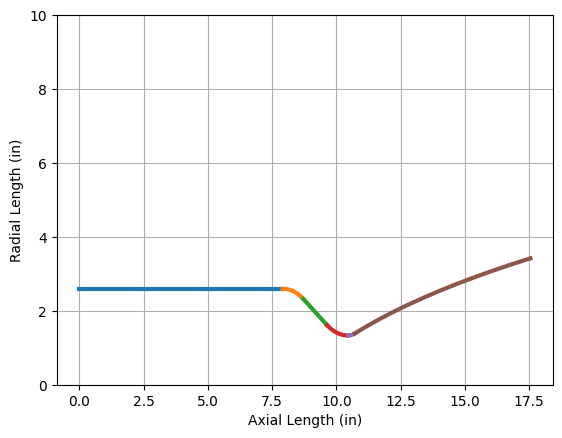

In [153]:
Pc = 400 # psi
Pe = 8 # psi
MR = 2.23

Rc = 1 * R_t # in
Rtc = 1 * R_t # in
theta_c = 37.5 # deg
Lc = 7.9 # cylindrical length
eps_c = 3.8
Rtd = 0.5 * R_t # in
Lf = 80 # percent bell
eps = rocket.get_eps_at_PcOvPe(Pc, MR, Pc/Pe, 1, 1)
theta_n = griddata(theta_n_data[:, :2], theta_n_data[:, 2], 
                   (Lf, eps), method='linear') # deg
theta_e = griddata(theta_e_data[:, :2], theta_e_data[:, 2], 
                   (Lf, eps), method='linear') # deg

# Chamber cylinder section
theta_c = np.deg2rad(theta_c)
f1z = np.linspace(0, Lc, 400)
f1r = np.ones(len(f1z))*np.sqrt(eps_c)*R_t
plt.figure
plt.ylim([0, 10])
plt.grid(True)
plt.plot(f1z, f1r, linewidth=3)

# Converging entrance arc
t = np.linspace(np.pi/2, np.pi/2 - theta_c, 400)
f2z = Rc*np.cos(t) + Lc
f2r = Rc*np.sin(t) + R_t*np.sqrt(eps_c) - Rc
inds = np.argsort(f2z)
f2z = f2z[inds]
f2r = f2r[inds]
plt.plot(f2z, f2r, linewidth=3)

# Converging linear section
y3 = R_t*(np.sqrt(eps_c)-1) - (Rc-Rc*np.cos(theta_c)) - (Rtc-Rtc*np.cos(theta_c))
x3 = y3 / (np.tan(theta_c))
f3z = np.linspace(f2z[-1], f2z[-1] + x3, 400)
m = -np.tan(theta_c)
f3r = m*(f3z - f2z[-1]) + f2r[-1]
plt.plot(f3z, f3r, linewidth=3)

# Converging throat arc
t = np.linspace(np.pi + np.pi/2 - theta_c, 3*np.pi/2, 400)
h = f3z[-1] + Rtc*np.sin(theta_c)
k = R_t + Rtc
f4z = Rtc*np.cos(t) + h
f4r = Rtc*np.sin(t) + k
inds = np.argsort(f4z)
f4z = f4z[inds]
f4r = f4r[inds]
plt.plot(f4z, f4r, linewidth=3)

# Diverging Entrance Arc
theta_n = np.deg2rad(theta_n)
t = np.linspace(3*np.pi/2, 3*np.pi/2 + theta_n, 400)
k = R_t + Rtd
f5z = Rtd*np.cos(t) + h
f5r = Rtd*np.sin(t) + k
inds = np.argsort(f5z)
f5z = f5z[inds]
f5r = f5r[inds]
plt.plot(f5z, f5r, linewidth=3)

# Bell Nozzle
theta_e = np.deg2rad(theta_e)
N = [f5z[-1], f5r[-1]] # Nx, Ny
conical_length = (f5z[-1] + (np.sqrt(eps)*R_t + f5r[-1]/(np.tan(np.deg2rad(15))))) - f4z[-1]
E = [(Lf/100)*conical_length + f4z[-1], R_t*np.sqrt(eps)] # Ex, Ey
m1 = np.tan(theta_n)
m2 = np.tan(theta_e)
Qx = (m1*N[0] - N[1] - m2*E[0] + E[1]) / (m1 - m2) # solve for intersection using point-slope
Qy = m1*(Qx - N[0]) + N[1]
Q = [Qx, Qy]
t = np.linspace(0, 1, 100)
f6z = ((1 - t)**2)*N[0] + 2*(1-t)*t*Q[0] + (t**2)*E[0]
f6r = ((1 - t)**2)*N[1] + 2*(1-t)*t*Q[1] + (t**2)*E[1]
plt.plot(f6z, f6r, linewidth=3)

# Equivalent Cone
f6z = np.linspace(f5z[-1], f5z[-1] + ((np.sqrt(eps)*R_t - f5r[-1])/(np.tan(theta_n))), 400)
m = np.tan(theta_n)
f6r = m*(f6z - f5z[-1]) + f5r[-1]

plt.xlabel("Axial Length (in)")
plt.ylabel("Radial Length (in)")

print(f"Conical Length = {conical_length:.2f} in")
print(f"Bell Length = {(Lf/100)*conical_length:.2f} in")
print(f"Entrance Angle = {np.rad2deg(theta_n):.2f}°")
print(f"Exit Angle = {np.rad2deg(theta_e):.2f}°");

This is our bell nozzle! Let's compare it to how long an equivalent 15° conical nozzle would look. 

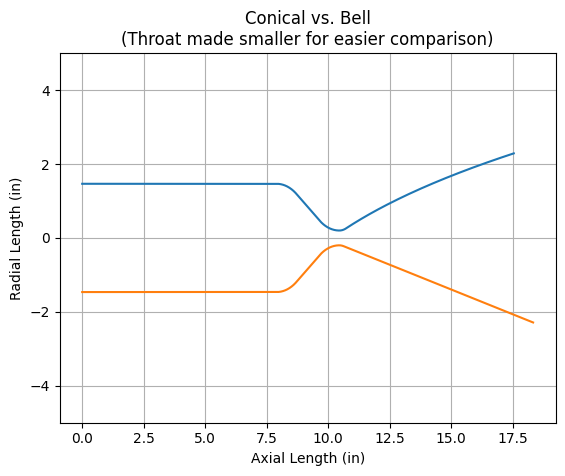

In [154]:
Pc = 400 # psi
Pe = 8 # psi
MR = 2.23

Rc = 1 * R_t # in
Rtc = 1 * R_t # in
theta_c = 37.5 # deg
Lc = 7.9 # cylindrical length
eps_c = 3.8
Rtd = 0.5 * R_t # in
Lf = 80 # percent bell
eps = rocket.get_eps_at_PcOvPe(Pc, MR, Pc/Pe, 1, 1)
theta_n = griddata(theta_n_data[:, :2], theta_n_data[:, 2], 
                   (Lf, eps), method='linear') # deg
theta_e = griddata(theta_e_data[:, :2], theta_e_data[:, 2], 
                   (Lf, eps), method='linear') # deg

# Chamber cylinder section
theta_c = np.deg2rad(theta_c)
f1z = np.linspace(0, Lc, 400)
f1r = np.ones(len(f1z))*np.sqrt(eps_c)*R_t
plt.figure
plt.grid(True)

# Converging entrance arc
t = np.linspace(np.pi/2, np.pi/2 - theta_c, 400)
f2z = Rc*np.cos(t) + Lc
f2r = Rc*np.sin(t) + R_t*np.sqrt(eps_c) - Rc
inds = np.argsort(f2z)
f2z = f2z[inds]
f2r = f2r[inds]

# Converging linear section
y3 = R_t*(np.sqrt(eps_c)-1) - (Rc-Rc*np.cos(theta_c)) - (Rtc-Rtc*np.cos(theta_c))
x3 = y3 / (np.tan(theta_c))
f3z = np.linspace(f2z[-1], f2z[-1] + x3, 400)
m = -np.tan(theta_c)
f3r = m*(f3z - f2z[-1]) + f2r[-1]

# Converging throat arc
t = np.linspace(np.pi + np.pi/2 - theta_c, 3*np.pi/2, 400)
h = f3z[-1] + Rtc*np.sin(theta_c)
k = R_t + Rtc
f4z = Rtc*np.cos(t) + h
f4r = Rtc*np.sin(t) + k
inds = np.argsort(f4z)
f4z = f4z[inds]
f4r = f4r[inds]

# Diverging Entrance Arc
theta_n = np.deg2rad(theta_n)
t = np.linspace(3*np.pi/2, 3*np.pi/2 + theta_n, 400)
k = R_t + Rtd
f5z = Rtd*np.cos(t) + h
f5r = Rtd*np.sin(t) + k
inds = np.argsort(f5z)
f5z = f5z[inds]
f5r = f5r[inds]

# Bell Nozzle
theta_e = np.deg2rad(theta_e)
N = [f5z[-1], f5r[-1]] # Nx, Ny
conical_length = (f5z[-1] + (np.sqrt(eps)*R_t + f5r[-1]/(np.tan(np.deg2rad(15))))) - f4z[-1]
E = [(Lf/100)*conical_length + f4z[-1], R_t*np.sqrt(eps)] # Ex, Ey
m1 = np.tan(theta_n)
m2 = np.tan(theta_e)
Qx = (m1*N[0] - N[1] - m2*E[0] + E[1]) / (m1 - m2) # solve for intersection using point-slope
Qy = m1*(Qx - N[0]) + N[1]
Q = [Qx, Qy]
t = np.linspace(0, 1, 100)
f6z = ((1 - t)**2)*N[0] + 2*(1-t)*t*Q[0] + (t**2)*E[0]
f6r = ((1 - t)**2)*N[1] + 2*(1-t)*t*Q[1] + (t**2)*E[1]

fz_bell = np.hstack((f1z, f2z, f3z, f4z, f5z, f6z))
fr_bell = np.hstack((f1r, f2r, f3r, f4r, f5r, f6r))

# Equivalent Cone
alpha = np.deg2rad(15)
t = np.linspace(3*np.pi/2, 3*np.pi/2 + alpha, 400)
k = R_t + Rtd
f5z_cone = Rtd*np.cos(t) + h
f5r_cone = Rtd*np.sin(t) + k
inds = np.argsort(f5z_cone)
f5z_cone = f5z_cone[inds]
f5r_cone = f5r_cone[inds]
f6z_cone = np.linspace(f5z_cone[-1], f5z_cone[-1] + ((np.sqrt(eps)*R_t - f5r_cone[-1])/(np.tan(alpha))), 400)
m = np.tan(alpha)
f6r_cone = m*(f6z_cone - f5z_cone[-1]) + f5r_cone[-1]
fz_cone = np.hstack((f1z, f2z, f3z, f4z, f5z_cone, f6z_cone))
fr_cone = np.hstack((f1r, f2r, f3r, f4r, f5r_cone, f6r_cone))

plt.plot(fz_bell, fr_bell-(R_t-0.2))
plt.plot(fz_cone, -fr_cone+R_t-0.2)
plt.ylim([-5, 5])
plt.xlabel("Axial Length (in)")
plt.ylabel("Radial Length (in)")
plt.title("Conical vs. Bell\n(Throat made smaller for easier comparison)");

We can pretty clearly see how much length and therefore weight that the bell nozzle saves.

# Summary

This chapter is a very high-level recap of all of the design choices. Firsly, $MR$ choice. It will be calculated assuming that sudden-freezing occurs at the throat. 

In [155]:
Pc = 400 # psia
Pe = 8 # psia
T = 3500 # lbf
cstar_eff = 92.00 # %

MR_list = np.linspace(2, 4, 1000)
Isp = np.zeros(len(MR_list))
for i, m in enumerate(MR_list):
    eps = rocket.get_eps_at_PcOvPe(Pc, m, Pc/Pe, 1, 1)
    Isp[i], _ = rocket.estimate_Ambient_Isp(Pc, m, eps, Pe, 1, 1)
ind = Isp.argmax()
MR = MR_list[ind]
print(f"Thrust: {T} lbf")
print(f"Chamber Pressure: {Pc} psia")
print(f"Exit Pressure: {Pe} psia")
print(f"Optimal Mixture Ratio: {MR:.2f}")
eps = rocket.get_eps_at_PcOvPe(Pc, MR, Pc/Pe, 1, 1)
Me = rocket.get_MachNumber(Pc, MR, eps, 1, 1)
_, _, ae = rocket.get_SonicVelocities(Pc, MR, eps, 1, 1)
Ve = Me * ae
cstar_ideal = rocket.get_Cstar(Pc, MR)
print(f"Characteristic Velocity: {cstar_ideal:.2f} m/s")
print(f"Assumed C* Efficiency: {cstar_eff} %")
mdot = (T*4.44822) / (Ve*(cstar_eff/100))
print(f"Total Mass Flow Rate: {mdot:.2f} kg/s")
mdot_fuel = 1 * mdot / (1 + MR)
mdot_ox = MR * mdot / (1 + MR)
print(f"Fuel Mass Flow Rate: {mdot_fuel:.2f} kg/s")
print(f"LOX Mass Flow Rate: {mdot_ox:.2f} kg/s")
Pt = Pc * 6894.76 / rocket.get_Throat_PcOvPe(Pc, MR)
_, Tt, _ = rocket.get_Temperatures(Pc, MR, eps, 1, 1)
mw, gamma = rocket.get_Throat_MolWt_gamma(Pc, MR, eps, 1)
R = 8314.46261815324 / mw
At = (mdot/Pt) * np.sqrt(R*Tt/gamma) * 1550
print(f"Throat Area: {At:.2f} sq. in.")
Rt = np.sqrt(At/np.pi)
print(f"Throat Radius: {Rt:.2f} in")


Thrust: 3500 lbf
Chamber Pressure: 400 psia
Exit Pressure: 8 psia
Optimal Mixture Ratio: 2.23
Characteristic Velocity: 1796.23 m/s
Assumed C* Efficiency: 92.0 %
Total Mass Flow Rate: 6.17 kg/s
Fuel Mass Flow Rate: 1.91 kg/s
LOX Mass Flow Rate: 4.26 kg/s
Throat Area: 6.06 sq. in.
Throat Radius: 1.39 in


One huge benefit of defining a contour parametrically is that you can easily create interactive, adjustable plots of your 2D contour. Below, I have made such a plot. Feel free to play around with it and see how different geometric parameters affect your engine contour.

In [156]:
At_text = widgets.FloatText(description="At (in^2)", disabled=True)
Lstar_text = widgets.FloatText(description="L* (in)", disabled=True)
vol_text = widgets.FloatText(description="Volcham (in^3)", disabled=True)
surf_text = widgets.FloatText(description="Surfcham (in^2)", disabled=True)
Ainj_text = widgets.FloatText(description="Ainj (in^2)", disabled=True)
Aexit_text = widgets.FloatText(description="Aexit (in^2)", disabled=True)
Lconv_text = widgets.FloatText(description="Lconv (in)", disabled=True)
Lnoz_text = widgets.FloatText(description="Lnoz (in)", disabled=True)
csv_save_button = widgets.Button(description="Save to CSV", button_style='success')

def update_plot(nfz, b_or_c, R_t, Lc, eps_c, theta_c, Rc_Rt, Rtc_Rt, Rtd_Rt, alpha, theta_n, theta_e, Lf):
    plt.figure(figsize=(8, 6))
    
    Pc = 400  # psi
    Pe = 8  # psi
    MR = 2.23
    
    Rc = Rc_Rt * R_t  # in
    Rtc = Rtc_Rt * R_t  # in
    theta_c = np.deg2rad(theta_c)  # convert to radians
    Rtd = Rtd_Rt * R_t  # in
    alpha = np.deg2rad(alpha)
    theta_n = np.deg2rad(theta_n)
    theta_e = np.deg2rad(theta_e)
    if nfz == 'Fully Equilibrium':
        eps = rocket.get_eps_at_PcOvPe(Pc, MR, Pc/Pe)
    elif nfz == 'Fully Frozen':
        eps = rocket.get_eps_at_PcOvPe(Pc, MR, Pc/Pe, 1)
    else:
        eps = rocket.get_eps_at_PcOvPe(Pc, MR, Pc/Pe, 1, 1)
    
    # Chamber cylinder section
    f1z = np.linspace(0, Lc, 400)
    f1r = np.ones(len(f1z)) * np.sqrt(eps_c) * R_t
    plt.plot(f1z, f1r, '#26a9e0', linewidth=3)

    # Converging entrance arc
    t = np.linspace(np.pi/2, np.pi/2 - theta_c, 400)
    f2z = Rc*np.cos(t) + Lc
    f2r = Rc*np.sin(t) + R_t*np.sqrt(eps_c) - Rc
    inds = np.argsort(f2z)
    f2z = f2z[inds]
    f2r = f2r[inds]
    plt.plot(f2z, f2r,'#e61950', linewidth=3)

    # Converging linear section
    y3 = R_t*(np.sqrt(eps_c)-1) - (Rc-Rc*np.cos(theta_c)) - (Rtc-Rtc*np.cos(theta_c))
    x3 = y3 / (np.tan(theta_c))
    f3z = np.linspace(f2z[-1], f2z[-1] + x3, 400)
    m = -np.tan(theta_c)
    f3r = m*(f3z - f2z[-1]) + f2r[-1]
    plt.plot(f3z, f3r, '#f7a829', linewidth=3)

    # Converging throat arc
    t = np.linspace(np.pi + np.pi/2 - theta_c, 3*np.pi/2, 400)
    h = f3z[-1] + Rtc*np.sin(theta_c)
    k = R_t + Rtc
    f4z = Rtc*np.cos(t) + h
    f4r = Rtc*np.sin(t) + k
    inds = np.argsort(f4z)
    f4z = f4z[inds]
    f4r = f4r[inds]
    plt.plot(f4z, f4r, '#fa791b', linewidth=3)

    # Diverging Entrance Arc
    if b_or_c == 'Conical':
        t = np.linspace(3*np.pi/2, 3*np.pi/2 + alpha, 400)
        k = R_t + Rtd
        f5z = Rtd*np.cos(t) + h
        f5r = Rtd*np.sin(t) + k
        inds = np.argsort(f5z)
        f5z = f5z[inds]
        f5r = f5r[inds]
        plt.plot(f5z, f5r, '#e61950', linewidth=3)
    else:
        t = np.linspace(3*np.pi/2, 3*np.pi/2 + theta_n, 400)
        k = R_t + Rtd
        f5z = Rtd*np.cos(t) + h
        f5r = Rtd*np.sin(t) + k
        inds = np.argsort(f5z)
        f5z = f5z[inds]
        f5r = f5r[inds]
        plt.plot(f5z, f5r, '#510c7c', linewidth=3)
    
    # Diverging Nozzle
    if b_or_c == 'Conical':
        f6z = np.linspace(f5z[-1], f5z[-1] + ((np.sqrt(eps)*R_t - f5r[-1])/(np.tan(alpha))), 400)
        m = np.tan(alpha)
        f6r = m*(f6z - f5z[-1]) + f5r[-1]
    else:
        N = [f5z[-1], f5r[-1]] # Nx, Ny
        conical_length = (f5z[-1] + (np.sqrt(eps)*R_t + f5r[-1]/(np.tan(np.deg2rad(15))))) - f4z[-1]
        E = [(Lf/100)*conical_length + f4z[-1], R_t*np.sqrt(eps)] # Ex, Ey
        m1 = np.tan(theta_n)
        m2 = np.tan(theta_e)
        Qx = (m1*N[0] - N[1] - m2*E[0] + E[1]) / (m1 - m2) # solve for intersection using point-slope
        Qy = m1*(Qx - N[0]) + N[1]
        Q = [Qx, Qy]
        t = np.linspace(0, 1, 100)
        f6z = ((1 - t)**2)*N[0] + 2*(1-t)*t*Q[0] + (t**2)*E[0]
        f6r = ((1 - t)**2)*N[1] + 2*(1-t)*t*Q[1] + (t**2)*E[1]
        plt.plot(f6z, f6r, linewidth=3)

    plt.plot(f6z, f6r, '#092843', linewidth=3)

    def vol_and_surf(x, y):
        dy = np.diff(y)
        dx = np.diff(x)
        volume = np.pi * np.sum((y[:-1]**2 + y[1:]**2) / 2 * dx)

        ds = np.sqrt(dx**2 + dy**2) 
        surface_area = 2 * np.pi * np.sum((y[:-1] + y[1:]) / 2 * ds)
        return volume, surface_area
    
    plt.xlabel("Axial Length (in)")
    plt.ylabel("Radial Length (in)")
    plt.ylim([0, 5*R_t])
    plt.grid(True)

    At = np.pi * R_t**2 # in2
    Ainj = np.pi * f1r[0]**2 # in2
    Aexit = np.pi * f6r[-1]**2 # in2
    Lconv = f4z[-1] - f2z[0] # in
    Lnoz = f6z[-1] - f4z[-1] # in
    vol, surf = vol_and_surf(np.hstack((f1z, f2z, f3z, f4z)), np.hstack((f1r, f2r, f3r, f4r)))
    Lstar = vol/At

    At_text.value = At
    Ainj_text.value = Ainj
    Aexit_text.value = Aexit
    Lconv_text.value = Lconv
    Lnoz_text.value = Lnoz
    vol_text.value = vol
    surf_text.value = surf
    Lstar_text.value = Lstar

    z = np.hstack((f1z, f2z, f3z, f4z, f5z, f6z))
    r = np.hstack((f1r, f2r, f3r, f4r, f5r, f6r))
    #z = [1, 2, 3]
    #r = [4, 5, 6]
    contour = z, r
    def save_to_csv(_):
        name = 'contour.csv'
        with open(name, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Z", "R"])
            for zi, ri in zip(z, r):
                writer.writerow([zi, ri]) 

    csv_save_button.on_click(save_to_csv)
    return (At, Ainj, Aexit, Lconv, Lnoz, surf, vol, Lstar)


#plt.show()
nfz_buttons = widgets.RadioButtons(options=['Fully Equilibrium', 'Fully Frozen', 'Frozen from Throat'], description = 'Equilibrium Model')
b_or_c_buttons = widgets.RadioButtons(options=['Conical', 'Bell'], description='Nozzle Shape')
R_t_slider = widgets.FloatSlider(value=Rt, min=1, max=3, step=0.01, readout_format='.2f', description = 'Rt')
print('Rt = Throat Radius (in)')
Lc_slider = widgets.FloatSlider(value=7.9, min=5, max=15, step=0.1, readout_format='.1f', description = 'Lc')
print('Lc = Chamber Cylindrical Length (in)')
eps_c_slider = widgets.FloatSlider(value=3.8, min=2, max=4.5, step=0.1, readout_format='.1f', description = 'eps_c')
print('eps_c = Contraction Ratio')
Rc_Rt_slider = widgets.FloatSlider(value=1, min=0.5, max=1.5, step=0.1, readout_format='.1f', description = 'Rc/Rt')
print('Rc/Rt = Convergence Radius')
theta_c_slider = widgets.FloatSlider(value=37.5, min=25, max=40, step=0.1, readout_format='.1f', description = 'theta_c')
print('theta_c = Convergence Half-Angle (°)')
Rtc_Rt_slider = widgets.FloatSlider(value=1, min=0.5, max=1.5, step=0.1, readout_format='.1f', description = 'Rtc/Rt')
print('RtcRt = Lead-in Radius')
Rtd_Rt_slider = widgets.FloatSlider(value=0.5, min=0.3, max=1.5, step=0.1, readout_format='.1f', description = 'Rtd/Rt')
print('Rtd/Rt = Lead-out Radius')
alpha_slider = widgets.FloatSlider(value=15, min=10, max=25, step=1, readout_format='d', description = 'alpha')
print('alpha = Divergence Half-Angle (°) [Conical Only]')
theta_n_slider = widgets.FloatSlider(value=22, min=20, max=40, step=1, readout_format='d', description = 'theta_n')
print('theta_n = Divergence Entrance Angle (°) [Bell Only]')
theta_e_slider = widgets.FloatSlider(value=10, min=5, max=20, step=1, readout_format='d', description = 'theta_e')
print('theta_n = Divergence Exit Angle (°) [Bell Only]')
Lf_slider = widgets.FloatSlider(value=80, min=60, max=100, step=1, readout_format='d', description = 'Lf')
print('Lf = Percent Bell (%) [Bell Only]')

interactive_plot = widgets.interactive(update_plot, nfz=nfz_buttons, b_or_c=b_or_c_buttons, R_t=R_t_slider, Lc=Lc_slider, eps_c=eps_c_slider, 
                                       theta_c=theta_c_slider, Rc_Rt=Rc_Rt_slider, Rtc_Rt=Rtc_Rt_slider, Rtd_Rt=Rtd_Rt_slider,
                                        alpha=alpha_slider, theta_n=theta_n_slider, theta_e=theta_e_slider, Lf=Lf_slider)
display(interactive_plot)
display(widgets.VBox([At_text, Lstar_text, vol_text, surf_text, Ainj_text, Aexit_text, Lconv_text, Lnoz_text]))
display(csv_save_button)

Rt = Throat Radius (in)
Lc = Chamber Cylindrical Length (in)
eps_c = Contraction Ratio
Rc/Rt = Convergence Radius
theta_c = Convergence Half-Angle (°)
RtcRt = Lead-in Radius
Rtd/Rt = Lead-out Radius
alpha = Divergence Half-Angle (°) [Conical Only]
theta_n = Divergence Entrance Angle (°) [Bell Only]
theta_n = Divergence Exit Angle (°) [Bell Only]
Lf = Percent Bell (%) [Bell Only]


interactive(children=(RadioButtons(description='Equilibrium Model', options=('Fully Equilibrium', 'Fully Froze…

Button(button_style='success', description='Save to CSV', style=ButtonStyle())

I hope that playing around with this tool gives you some more appreciation for how altering different geometric parameters can change you contour. Moreover, I hope that you recognize when a geometry might be really hard to machine or manufacture. Additionally you may notice that some geometries, especially with bell nozzles, are not possible. I also recommend that you zoom out ('CMD' + '-' on Mac) to see the whole widget better. If you want to export the contour to CAD, you can use the 'Save to CSV' button.

I hope that this guide was helpful for you!

# Sources

- *Introduction to Physical Gas Dynamics* by Walter G. Vincenti and Charles H. Kruger, Jr.
- *Design of Liquid Propellant Rocket Engines* by Dieter K Huzel and David H Huang
- *Rocket Propulsion Elements* by George Paul Sutton and Oscar Biblarz
- *Liquid Rocket Thrust Chambers: Aspects of Modeling, Analysis, and Design* by Vigor Yang, Mohammed Habiballah, James Hulka, and Michael Popp
- *Nozzle & Combustion Chamber Design Guide* by Dane M Gleason: https://wikis.mit.edu/confluence/pages/viewpage.action?pageId=153816550
- *RocketCEA v1.2.1 documentation* by Charlie Taylor: https://rocketcea.readthedocs.io/en/latest/index.html
- *RocketIsp 0.1.11 documentation* by Charlie Taylor: https://rocketisp.readthedocs.io/en/latest/index.html#
- *RocketProps 0.1.8 documentation* by Charlie Taylor: https://rocketprops.readthedocs.io/en/latest/index.html
- *Rocket Propulsion* by Robert A. Braeunig: http://www.braeunig.us/space/propuls.htm
- *Propellant Combustion Chamber* by Robert A. Braeunig: http://www.braeunig.us/space/comb.htm
- *NASA Reference Publication 1311: Computer Program for Calculation Complex Chemical Equilibrium Compositions and Applications* by Sanford Gordon and Bonnie J. McBride: https://ntrs.nasa.gov/citations/19950013764
- *NASA Technical Memorandum 19690009560* by Uwe H. von Glahn
- *NASA Technical Note 19980223617* by Martin Hersch
- *NASA Technical Paper 19960042495* by Robert S. Jankovsky, John M. Kazaroff, and Albert J. Pavli
- *NASA Technical Memorandum 19730012958* by W. B. Powell
- *AE 4451: Jet and Rocket Propulsion* by Jerry Seitzman: https://seitzman.gatech.edu/classes/ae4451/
- *AE 6450: Rocket Propulsion* by Jerry Seitzman: https://seitzman.gatech.edu/classes/ae6450/
- *NASA Technical Memorandum 19750003989* by Robert H. Schmucker
- *NASA Analysis Of Rocket Engine Injection Combustion Processes Report* by J.W. Salmon: https://ntrs.nasa.gov/api/citations/19770008146/downloads/19770008146.pdf
- *Space Propulsion and Analysis Design* by Ronald W. Humble, Gary N. Henry, and Wiley J. Larson
- *Numerical Analysis of Convergent-Divergent Angles and Operating Conditions Impact on Rocket Nozzle Performance Parameters* by Nabila Alili, Khacem Kaddouri, Salem Mokadem, Ahmed Alami: https://bulletin.incas.ro/files/alili_kaddouri_mokadem_alami__vol_16_iss_1.pdf 
- *Design of a Supersonic Nozzle using Method of Characteristics* by Md Akhtar Khan, Sanjay Kumar Sardiwal, M.V.Sai Sharath, D.Harika Chowdary 4: https://www.ijert.org/research/design-of-a-supersonic-nozzle-using-method-of-characteristics-IJERTV2IS110026.pdf
- *Introduction to the Method of Characteristics and the Minimum Length Nozzle* by Stephen A. Whitmore: http://mae-nas.eng.usu.edu/MAE_5540_Web/propulsion_systems/section8/section.8.1.pdf
- *Making Correct Parabolic Nozzles* by Richard Garcia: https://rrs.org/2023/01/28/making-correct-parabolic-nozzles/
- *Recent Developments in Rocket Nozzle Configurations* by G. V. R. Rao: http://mae-nas.eng.usu.edu/MAE_6530_Web/New_Course/Section1/RaoRecentDevinRockNozConfig.pdf
- *The Thrust Optimised Parabolic nozzle* by Rick Newlands: http://www.aspirespace.org.uk/downloads/Thrust%20optimised%20parabolic%20nozzle.pdf
- *Evaluation of the Bray Sudden-Freezing Criterion for Predicting Nonequilibrium Performance in Multireaction Rocket Nozzle Expansions* by V.J Sarli, W.G. Burwell, and R. Hofland Jr: https://arc.aiaa.org/doi/10.2514/6.1965-554 
- *Legendre Transforms for Dummies* by Carl E. Mungan: https://www.aapt.org/docdirectory/meetingpresentations/sm14/mungan-poster.pdf
